<a href="https://colab.research.google.com/github/UrsulaM25/ProyectoFinal/blob/main/Manejo_de_datos_ausentes_avances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Introducción y Objetivo

**Parte 1**

Desarrollar una metodología de imputación de datos faltantes basada en técnicas de machine learning que permita:
* Identificar
* Estimar y reemplazar los valores faltantes en registros históricos de mediciones provenientes de dispositivos AMI

El propósito es para disponer de información precisa y consistente que respalde adecuadamente los procesos de análisis y toma de decisiones en las redes de distribución (planificación)

**Parte 2: Futuro**

En base a un periodo de datos sin NaN (un año) poder estimar entrenando un modelo para optimizar la operación en tienpo real.






# 2. Dataset



Se utilizaron datos reales de la Red Inteligente Caucete, ubicada en la ciudad de Caucete, San Juan, Argentina.

El df contiene las siguientes columnas:

tiempo: formato dia/mes/año  hora

kW

temperatura (°C)

# 3. Importar Librerias




In [1]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
import tensorflow as tf

#Libreria de Scikit-learn para imputacion

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils import resample

#Importacion descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose

#Libreria para visualizacion datos nulos
import missingno as msno

#Libreria visualización interactiva
from matplotlib.animation import FuncAnimation
import plotly.express as px
import plotly.graph_objects as go

#Configuraciones adicionales
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
!rm -rf /content/pyampute  # elimino pyampute para no clonarlo dos veces

In [3]:
# 1. Clonar el repo
!git clone https://github.com/RianneSchouten/pyampute.git

# 2. Cambiar al directorio del repo
%cd /content/pyampute

# 3. Añadir la ruta al sys.path
import sys, os
sys.path.append("/content/pyampute")


# 4. Ejecutar el script generate_shift_lookup_table.py
from scripts import generate_shift_lookup_table

print("\n--- Contenido de data/ ---")
!ls -l data/shift_lookup.csv

# 5. Importar las clases desde la librería
from pyampute.ampute import MultivariateAmputation
from pyampute.exploration.md_patterns import mdPatterns

print("\nLa librería 'pyampute' se ha cargado correctamente.")

# 6. Verificar que el archivo se generó correctamente
file_path = '/content/pyampute/data/shift_lookup.csv'
if os.path.exists(file_path):
    print("Archivo 'shift_lookup.csv' generado exitosamente en:", file_path)
else:
    print("El archivo 'shift_lookup.csv' no se encuentra.")


Cloning into 'pyampute'...
remote: Enumerating objects: 2914, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 2914 (delta 112), reused 144 (delta 72), pack-reused 2687 (from 1)
Receiving objects: 100% (2914/2914), 7.68 MiB | 18.03 MiB/s, done.
Resolving deltas: 100% (1981/1981), done.
/content/pyampute

--- Contenido de data/ ---
-rw-r--r-- 1 root root 4430 Nov 19 04:13 data/shift_lookup.csv

La librería 'pyampute' se ha cargado correctamente.
Archivo 'shift_lookup.csv' generado exitosamente en: /content/pyampute/data/shift_lookup.csv


# 4. Carga de Datos  (df original)

In [4]:
df = pd.read_csv ("https://raw.githubusercontent.com/UrsulaM25/ProyectoFinal/refs/heads/main/data19_20.CVS.csv", delimiter=";",decimal=",")  #Especifico el delimitador y agrego el CSV


In [5]:
df.shape #tamaño de dataframe

(17544, 3)

In [6]:
df.size #Cantidad de datos

52632

In [7]:
df.info () #Info df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   tiempo       17544 non-null  object 
 1   kW           17544 non-null  float64
 2   temperatura  17544 non-null  float64
dtypes: float64(2), object(1)
memory usage: 411.3+ KB


# 5. Data wrangling (df original)

In [8]:
df.head() #Visualizar df

tiempo      kW  temperatura
0  2019-01-01 00:00:00  48.000        27.55
1  2019-01-01 01:00:00  49.488        26.75
2  2019-01-01 02:00:00  52.608        25.80
3  2019-01-01 03:00:00  57.840        24.65
4  2019-01-01 04:00:00  69.984        24.05

In [9]:
df.head(17546) #Visualizar df

tiempo       kW  temperatura
0      2019-01-01 00:00:00   48.000        27.55
1      2019-01-01 01:00:00   49.488        26.75
2      2019-01-01 02:00:00   52.608        25.80
3      2019-01-01 03:00:00   57.840        24.65
4      2019-01-01 04:00:00   69.984        24.05
...                    ...      ...          ...
17539  2020-12-31 19:00:00  115.872        32.25
17540  2020-12-31 20:00:00   94.416        32.05
17541  2020-12-31 21:00:00   90.528        31.05
17542  2020-12-31 22:00:00   84.624        29.50
17543  2020-12-31 23:00:00   65.424        28.45

[17544 rows x 3 columns]

Se verifica que phyton trae bien en dato de la tabla

In [10]:
print(df.dtypes)  # Verificar el tipo de datos

tiempo          object
kW             float64
temperatura    float64
dtype: object


## 5.1 Formatos (df_analisis)

Se cambian los tipos de datos de tiempo y se crea un nuevo df

In [11]:
df["tiempo"] = pd.to_datetime(df["tiempo"]) #Cambiar tipo de dato de fecha a fecha

df.dtypes['tiempo'] #Verificar cambio de tipo de dato

dtype('<M8[ns]')

In [12]:
print(df.dtypes)  # Verificar el tipo de datos

tiempo         datetime64[ns]
kW                    float64
temperatura           float64
dtype: object


In [13]:
df.head() #Visualizar df

tiempo      kW  temperatura
0 2019-01-01 00:00:00  48.000        27.55
1 2019-01-01 01:00:00  49.488        26.75
2 2019-01-01 02:00:00  52.608        25.80
3 2019-01-01 03:00:00  57.840        24.65
4 2019-01-01 04:00:00  69.984        24.05

Se crea df_analisis para analizar el df y visualizarlo

In [14]:
df_analisis=df.copy() #Copiar df

In [15]:
df_analisis['año'] = df_analisis['tiempo'].dt.year
df_analisis['mes'] = df_analisis['tiempo'].dt.month
df_analisis['hora'] = df_analisis['tiempo'].dt.hour
df_analisis['día'] = df_analisis['tiempo'].dt.day

In [16]:
df_analisis.head(17546) #Visualizar df

tiempo       kW  temperatura   año  mes  hora  día
0     2019-01-01 00:00:00   48.000        27.55  2019    1     0    1
1     2019-01-01 01:00:00   49.488        26.75  2019    1     1    1
2     2019-01-01 02:00:00   52.608        25.80  2019    1     2    1
3     2019-01-01 03:00:00   57.840        24.65  2019    1     3    1
4     2019-01-01 04:00:00   69.984        24.05  2019    1     4    1
...                   ...      ...          ...   ...  ...   ...  ...
17539 2020-12-31 19:00:00  115.872        32.25  2020   12    19   31
17540 2020-12-31 20:00:00   94.416        32.05  2020   12    20   31
17541 2020-12-31 21:00:00   90.528        31.05  2020   12    21   31
17542 2020-12-31 22:00:00   84.624        29.50  2020   12    22   31
17543 2020-12-31 23:00:00   65.424        28.45  2020   12    23   31

[17544 rows x 7 columns]

Se verifica que los datos máximos coinciden con el df original

In [17]:
print(df_analisis.dtypes)  # Verificar el tipo de datos

tiempo         datetime64[ns]
kW                    float64
temperatura           float64
año                     int32
mes                     int32
hora                    int32
día                     int32
dtype: object


In [18]:
df_analisis.describe()

tiempo            kW   temperatura           año  \
count                17544  17544.000000  17544.000000  17544.000000   
mean   2020-01-01 11:30:00     43.890794     19.126764   2019.500684   
min    2019-01-01 00:00:00     15.360000     -4.000000   2019.000000   
25%    2019-07-02 17:45:00     28.032000     13.100000   2019.000000   
50%    2020-01-01 11:30:00     36.300000     19.325000   2020.000000   
75%    2020-07-02 05:15:00     50.064000     25.225000   2020.000000   
max    2020-12-31 23:00:00    168.000000     40.900000   2020.000000   
std                    NaN     23.436322      7.911198      0.500014   

                mes          hora           día  
count  17544.000000  17544.000000  17544.000000  
mean       6.519836     11.500000     15.738714  
min        1.000000      0.000000      1.000000  
25%        4.000000      5.750000      8.000000  
50%        7.000000     11.500000     16.000000  
75%       10.000000     17.250000     23.000000  
max       12.000000     23.000000     31.000000  
std        3.449649      6.922384      8.804172

# 6. Análisis Exploratorio de Datos: EDA (df_analisis)

## 6.1 Verificar outliers

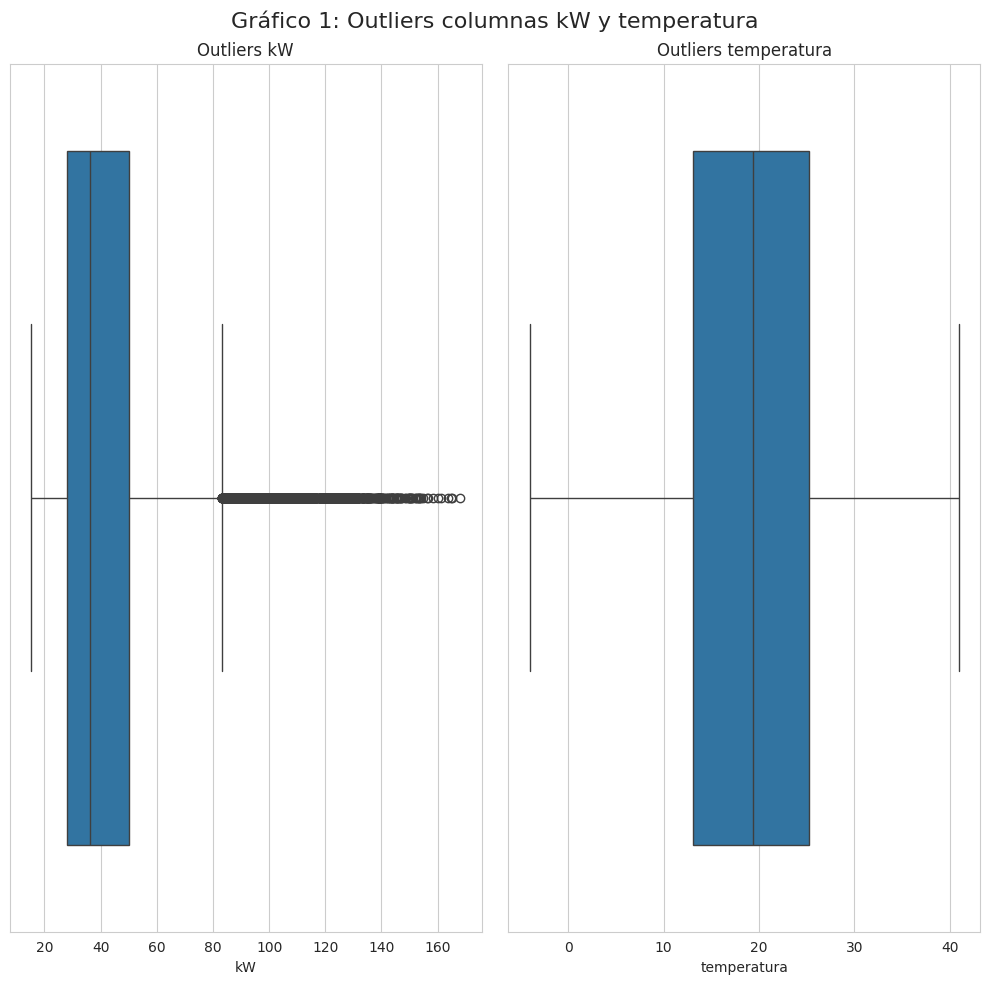

In [19]:
#Verificar Outliers de kW y temperatura - Hisplot y subplot
# Se crea una figura con cuadrícula 1x2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10)) # Axes[fila, columna], figsize(ancho, alto)

# Subplot 1
sns.boxplot(x=df_analisis['kW'], ax=axes[0])
axes[0].set_title("Outliers kW")
# Subplot 2
sns.boxplot(x=df_analisis['temperatura'], ax=axes[1])
axes[1].set_title("Outliers temperatura")


# Añadir título general
fig.suptitle('Gráfico 1: Outliers columnas kW y temperatura', fontsize=16)
plt.tight_layout()
plt.show()

Se visualizan varios valores outliers en kW relacionados a los picos de consumo

## 6.2 Visualización de df_analisis


In [20]:
fig = go.Figure() # Se crea figura

# kW y temperatura vs tiempo

fig.add_trace(go.Scatter(x=df_analisis['tiempo'], y=df_analisis['kW'], mode='lines', name='kW'))
fig.add_trace(go.Scatter(x=df_analisis['tiempo'], y=df_analisis['temperatura'], mode='lines', name='temperatura'))

# Colorear fondo para 2019
fig.add_vrect(
    x0="2019-01-01", x1="2019-12-31",
    fillcolor="lightblue", opacity=0.3,
    layer="below", line_width=0,
    annotation_text="2019", annotation_position="top left"
)

# Colorear fondo para 2020
fig.add_vrect(
    x0="2020-01-01", x1="2021-01-01",
    fillcolor="lightgreen", opacity=0.3,
    layer="below", line_width=0,
    annotation_text="2020", annotation_position="top left"
)



#Diseño

fig.update_layout(
    title='Gráfico 2: kW y temperatura vs tiempo ',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 6.3 Visualización de variables

In [21]:
print(df_analisis.dtypes)  # Verificar el tipo de datos

tiempo         datetime64[ns]
kW                    float64
temperatura           float64
año                     int32
mes                     int32
hora                    int32
día                     int32
dtype: object


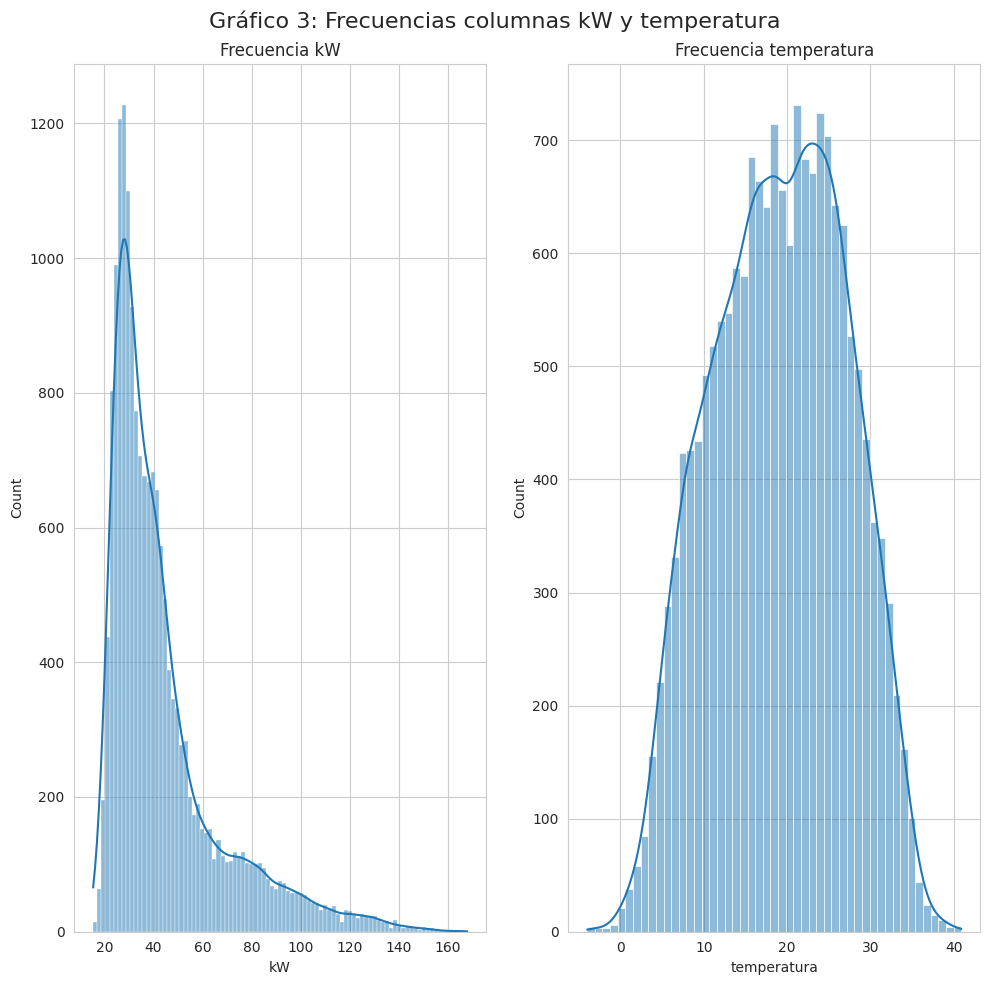

In [22]:
#Verificar frecuencia de kW y temperatura - Hisplot y subplot
# Se crea una figura con cuadrícula 1x2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10)) # Axes[fila, columna], figsize(ancho, alto)

# Subplot 1
sns.histplot(df_analisis['kW'], kde=True, ax=axes[0])
axes[0].set_title("Frecuencia kW")
# Subplot 2
sns.histplot(df_analisis['temperatura'], kde=True, ax=axes[1])
axes[1].set_title("Frecuencia temperatura")


# Añadir título general
fig.suptitle('Gráfico 3: Frecuencias columnas kW y temperatura', fontsize=16)
plt.tight_layout()
plt.show()

Se verifica que la distribución de la variable kW tiene asimetria positiva, la mayoria de los valores estan concentrados entre los 20 y 60 kW. Hay pocos valores con KW altos (picos). Para la temperatura la distribución es más simétrica, la mayoría de los valores de temperatura se encuentran en un rango central, aproximadamente entre los 15 y 25 grados.

In [23]:
asimetria_df_analisis_kw = df_analisis['kW'].skew()
curtosis_df_analisis_kw = df_analisis['kW'].kurt() #grado de apuntamiento o achatamiento de la distribución de frecuencia.
print("\nAsimetría kW:")
print(asimetria_df_analisis_kw)
print("Curtosis kW :")
print(curtosis_df_analisis_kw)

asimetria_df_analisis_t = df_analisis['temperatura'].skew()
curtosis_df_analisis_t = df_analisis['temperatura'].kurt() #grado de apuntamiento o achatamiento de la distribución de frecuencia.
print("\nAsimetría temperatura:")
print(asimetria_df_analisis_t)
print("Curtosis temperatura :")
print(curtosis_df_analisis_t)


Asimetría kW:
1.816978374935261
Curtosis kW :
3.355914025496519

Asimetría temperatura:
-0.07819929735349458
Curtosis temperatura :
-0.7637824056348017


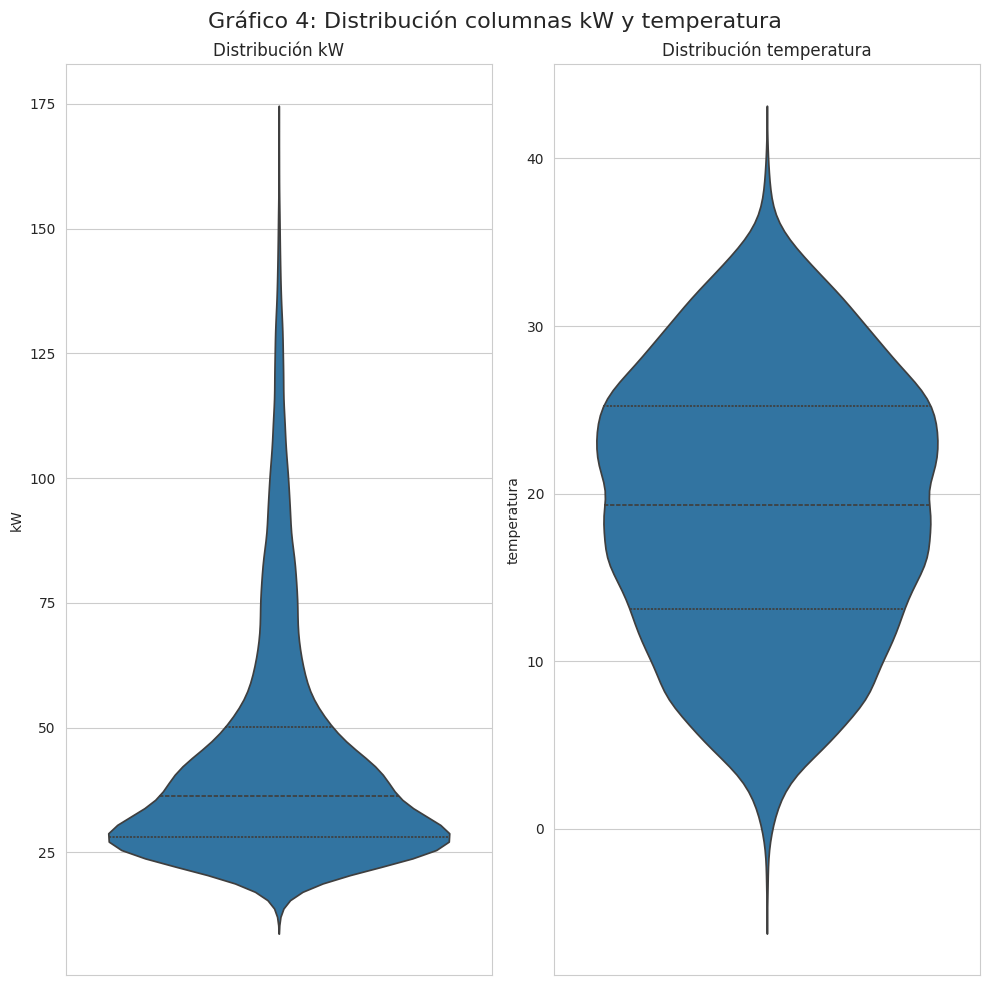

In [24]:
#Verificar distribución de datos kW y temperatura - Violinplot y subplot
# Se crea una figura con cuadrícula 1x2
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10)) # Axes[fila, columna], figsize(ancho, alto)

# Subplot 1
sns.violinplot(df_analisis['kW'], ax=axes[0], inner='quartile') # inner='quartile' muestra los cuartiles dentro
axes[0].set_title("Distribución kW")

# Subplot 2
sns.violinplot(df_analisis['temperatura'], ax=axes[1], inner='quartile')
axes[1].set_title("Distribución temperatura")

# Añadir título general
fig.suptitle('Gráfico 4: Distribución columnas kW y temperatura', fontsize=16)
plt.tight_layout()
plt.show()



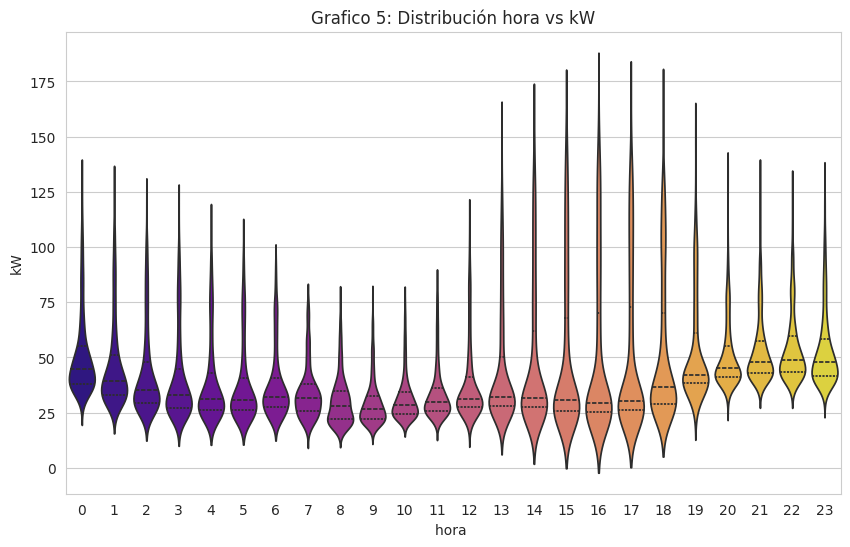

In [25]:
# Violinplot: Distribución datos hora vs kw
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_analisis, x='hora', y='kW', palette='plasma', inner='quartile') # inner='quartile' muestra los cuartiles dentro
plt.title('Grafico 5: Distribución hora vs kW')
plt.xlabel('hora ')
plt.ylabel('kW')
plt.show()

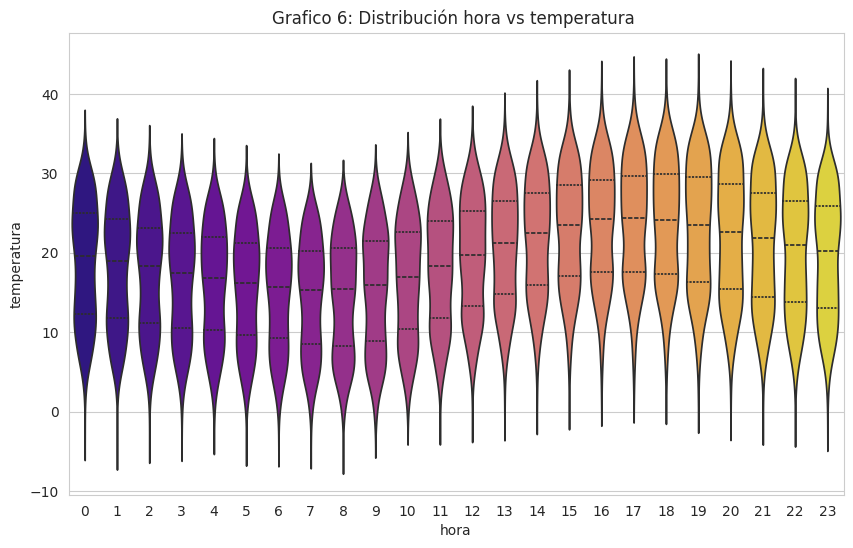

In [26]:
# Violinplot: Distribución datos hora vs kw
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_analisis, x='hora', y='temperatura', palette='plasma', inner='quartile') # inner='quartile' muestra los cuartiles dentro
plt.title('Grafico 6: Distribución hora vs temperatura ')
plt.xlabel('hora')
plt.ylabel('temperatura')
plt.show()

## 6.4 Correlaciones entre variables

In [27]:
print(df_analisis.dtypes)  # Verificar el tipo de datos

tiempo         datetime64[ns]
kW                    float64
temperatura           float64
año                     int32
mes                     int32
hora                    int32
día                     int32
dtype: object


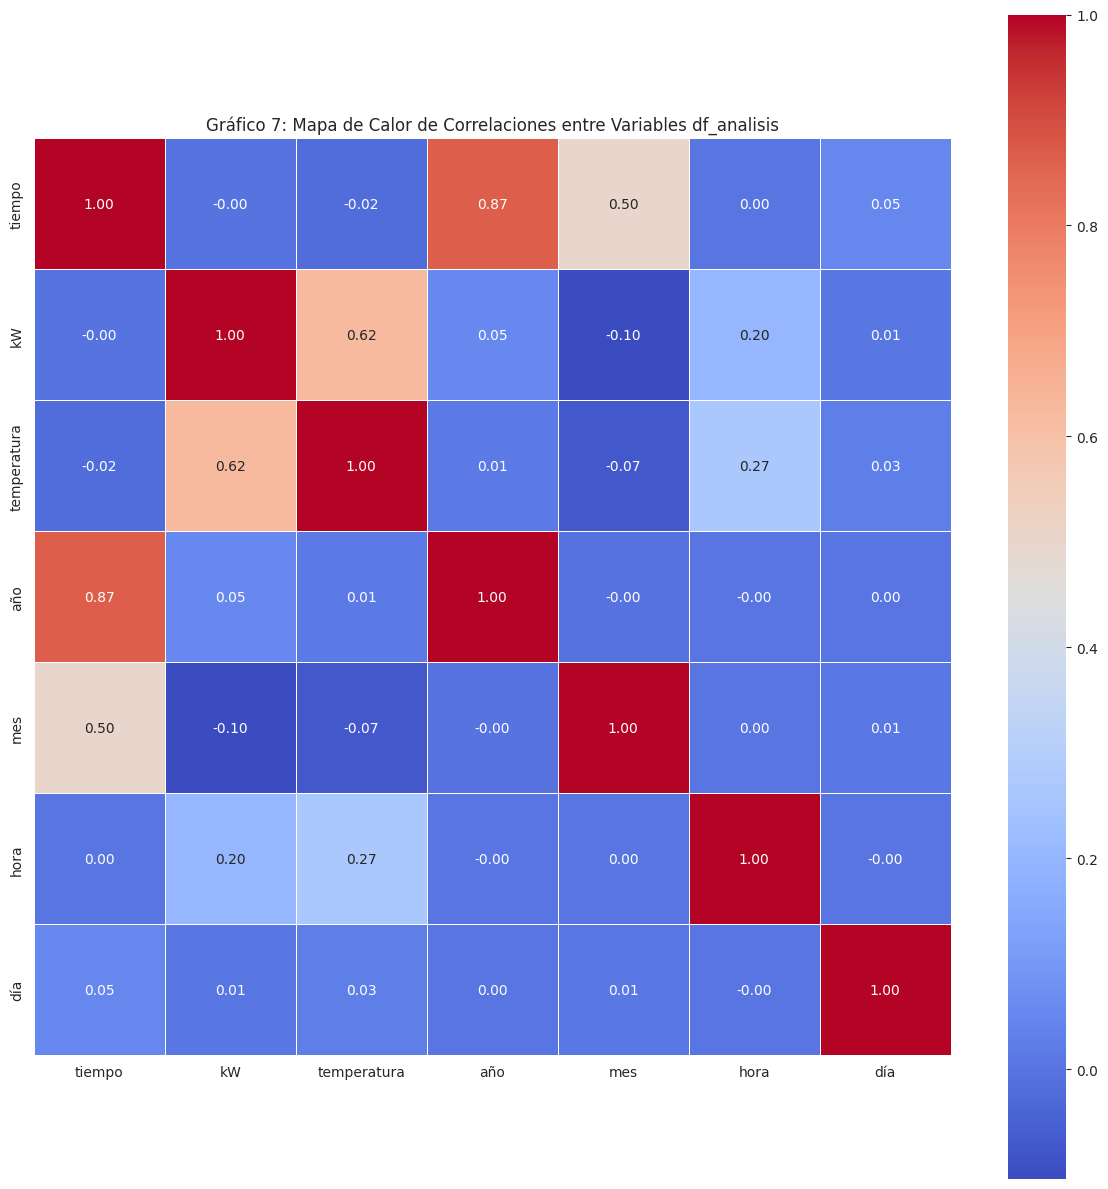

In [28]:
# Matriz de correlación-heatmap de seaborn
variables_numericas = ['tiempo','kW','temperatura','año','mes','hora','día']
correlaciones = df_analisis[variables_numericas].corr()
# Crear el heatmap
plt.figure(figsize=(12, 12)) #Tamaño de gráfico
sns.heatmap(correlaciones,
            cbar = True,
            square = True,
            annot=True,
            fmt= '.2f',
            annot_kws={'size': 10},
            cmap= 'coolwarm',
            linewidths=0.5)
plt.title('Gráfico 7: Mapa de Calor de Correlaciones entre Variables df_analisis')
plt.tight_layout()
plt.show()

Se puede observar los valores en rojo con correlacion positiva , es decir, si una variable aumenta la otra tambien aumenta.
 Por ejemplo kW y temperatura

# 7. Generación de df_base

Se crea df_base eliminando la columna temperatura para simular los datos de salida del equipo y se eligen columnas

In [29]:
df_base=df_analisis.copy()
df_base=df_base.drop('temperatura',axis=1)[['kW','tiempo','día','hora']].copy()

In [30]:
df_base.set_index('tiempo', inplace=True)

In [31]:
df_base.head(17546)

kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                      ...  ...   ...
2020-12-31 19:00:00  115.872   31    19
2020-12-31 20:00:00   94.416   31    20
2020-12-31 21:00:00   90.528   31    21
2020-12-31 22:00:00   84.624   31    22
2020-12-31 23:00:00   65.424   31    23

[17544 rows x 3 columns]

Se verifica que los datos no cambiaron con los de origen

In [32]:
df_base.describe()

kW           día          hora
count  17544.000000  17544.000000  17544.000000
mean      43.890794     15.738714     11.500000
std       23.436322      8.804172      6.922384
min       15.360000      1.000000      0.000000
25%       28.032000      8.000000      5.750000
50%       36.300000     16.000000     11.500000
75%       50.064000     23.000000     17.250000
max      168.000000     31.000000     23.000000

In [33]:
df_base

kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                      ...  ...   ...
2020-12-31 19:00:00  115.872   31    19
2020-12-31 20:00:00   94.416   31    20
2020-12-31 21:00:00   90.528   31    21
2020-12-31 22:00:00   84.624   31    22
2020-12-31 23:00:00   65.424   31    23

[17544 rows x 3 columns]

## 7.1 Verificar Valores faltantes (df_base)

In [34]:
print("Valores Nulos por Columna:")
df_base.isnull().sum()

Valores Nulos por Columna:


kW      0
día     0
hora    0
dtype: int64

El data set original no tiene valores faltantes

# 8. Generación de valores faltantes sobre df_base

Se generan datos NaN en el df_base utilizando multivariableAmputation **pyampute**

Pagina principal pyampute: https://rianneschouten.github.io/pyampute/build/html/examples.html

Para generar los valores faltantes se proponen dos patrones de datos faltantes:

 * Patron 1: Generación de NaN con MCAR-pyampute datos al completamente al azar.


 * Patron 2: Generación de NaN con mezcla de MNAR (peso 1) Y MAR (variable dependiente de hora peso 0,5 ) . Por ejemplo si ocurre una falla operativa en alguna hora y se suma a una falla de sobrecalentamiento.

Para cada patron se generan 5%, 10%, 15%, 20%, 30% de datos NaN.



In [35]:
df_patron1 = df_base.copy()

In [36]:
df_patron2 = df_base.copy()

## 8.1 Generación de valores faltantes Patron1

### 8.1.1 Generación de valores faltantes 5%




In [37]:
df_patron1_5kw = df_base[['kW','día','hora']]


# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW': 0},  # Se usa MCAR puro porque no tiene peso
    'freq': 1,
    'mechanism': 'MCAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.05,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron1_5 = amputer.fit_transform(df_patron1_5kw)


<Axes: >

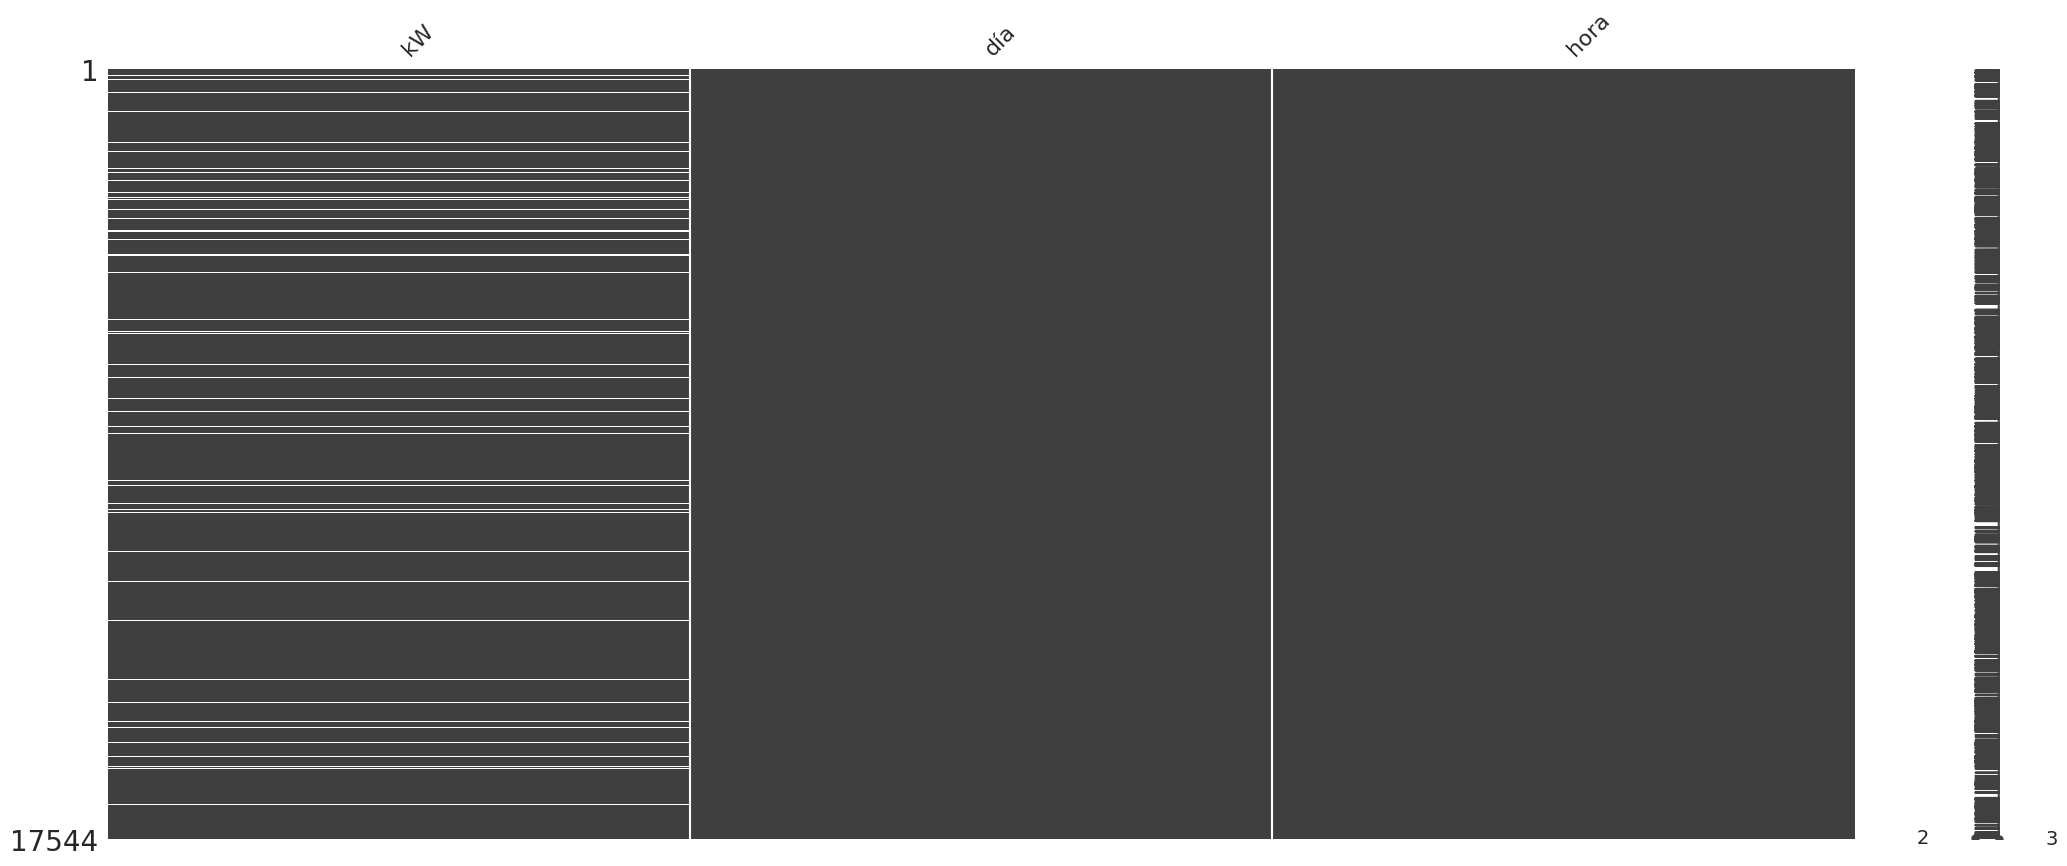

In [38]:
%matplotlib inline
msno.matrix(df_patron1_5)

In [39]:
# Se compara cant de valores nulos
print("Nulos Patron 1 MCAR:", df_patron1_5['kW'].isnull().sum())


Nulos Patron 1 MCAR: 864


Se filtran con una mascara las posiciones que fueron amputadas para luego poder comprar con las originales y calcular las métricas

In [40]:
#Mmask5: Posiciones que fueron amputadas
mask_patron1_5=df_patron1_5['kW'].isna()

In [41]:
print(mask_patron1_5)

tiempo
2019-01-01 00:00:00    False
2019-01-01 01:00:00    False
2019-01-01 02:00:00    False
2019-01-01 03:00:00    False
2019-01-01 04:00:00    False
                       ...  
2020-12-31 19:00:00    False
2020-12-31 20:00:00    False
2020-12-31 21:00:00    False
2020-12-31 22:00:00    False
2020-12-31 23:00:00    False
Name: kW, Length: 17544, dtype: bool


In [42]:
print("Cantidad de nulos mask mcar:", mask_patron1_5.sum())

Cantidad de nulos mask mcar: 864


Se compara con la cantidad de valores Nulos generados y coincide

###8.1.2 Generación de valores faltantes 10%


In [43]:
df_patron1_10kw = df_base[['kW','día','hora']]


# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW': 0},  # Se usa MCAR puro porque no tiene peso
    'freq': 1,
    'mechanism': 'MCAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.1,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron1_10 = amputer.fit_transform(df_patron1_10kw)



<Axes: >

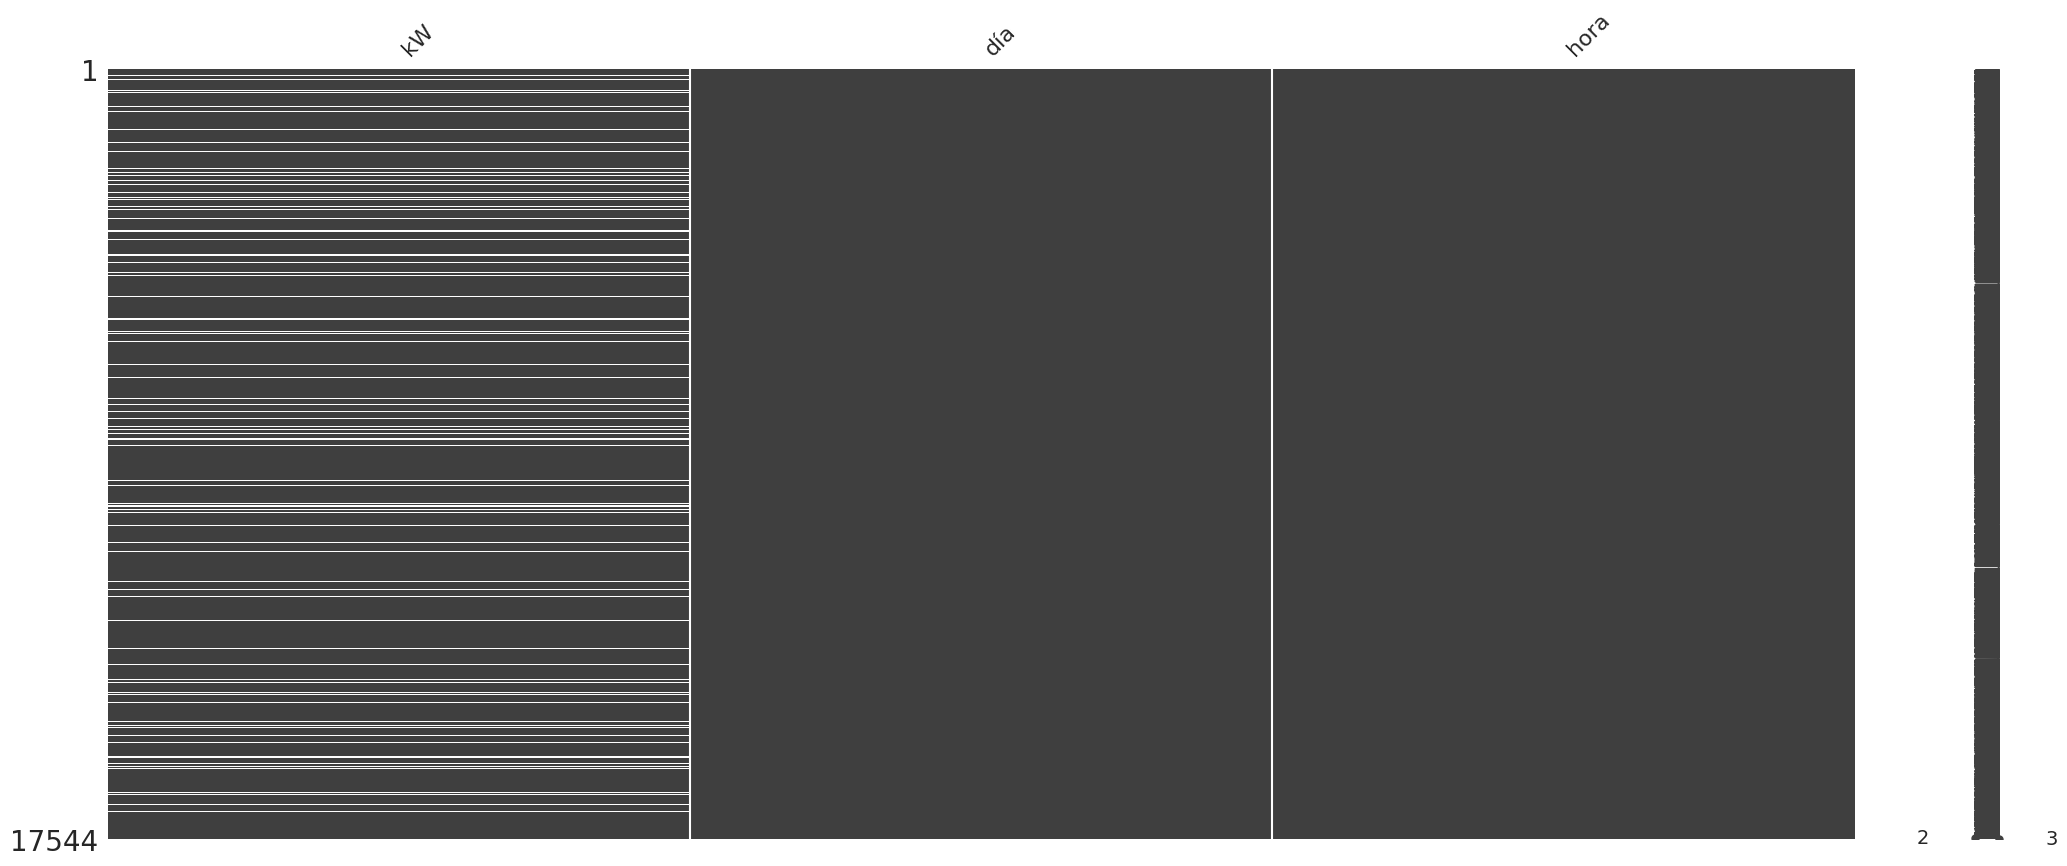

In [44]:
%matplotlib inline
msno.matrix(df_patron1_10)

In [45]:
# Se compara cant de valores nulos
print("Nulos Patron 1 MCAR:", df_patron1_10['kW'].isnull().sum())

Nulos Patron 1 MCAR: 1725


In [46]:
#Mmask10: Posiciones que fueron amputadas
mask_patron1_10=df_patron1_10['kW'].isna()

In [47]:
print("Cantidad de nulos mask mcar:", mask_patron1_10.sum())

Cantidad de nulos mask mcar: 1725


Se compara con la cantidad de valores Nulos generados y coincide

###8.1.3 Generación de valores faltantes 15%

In [48]:
df_patron1_15kw = df_base[['kW','día','hora']]

# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW': 0},  # Se usa MCAR puro porque no tiene peso
    'freq': 1,
    'mechanism': 'MCAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.15,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron1_15 = amputer.fit_transform(df_patron1_15kw)



<Axes: >

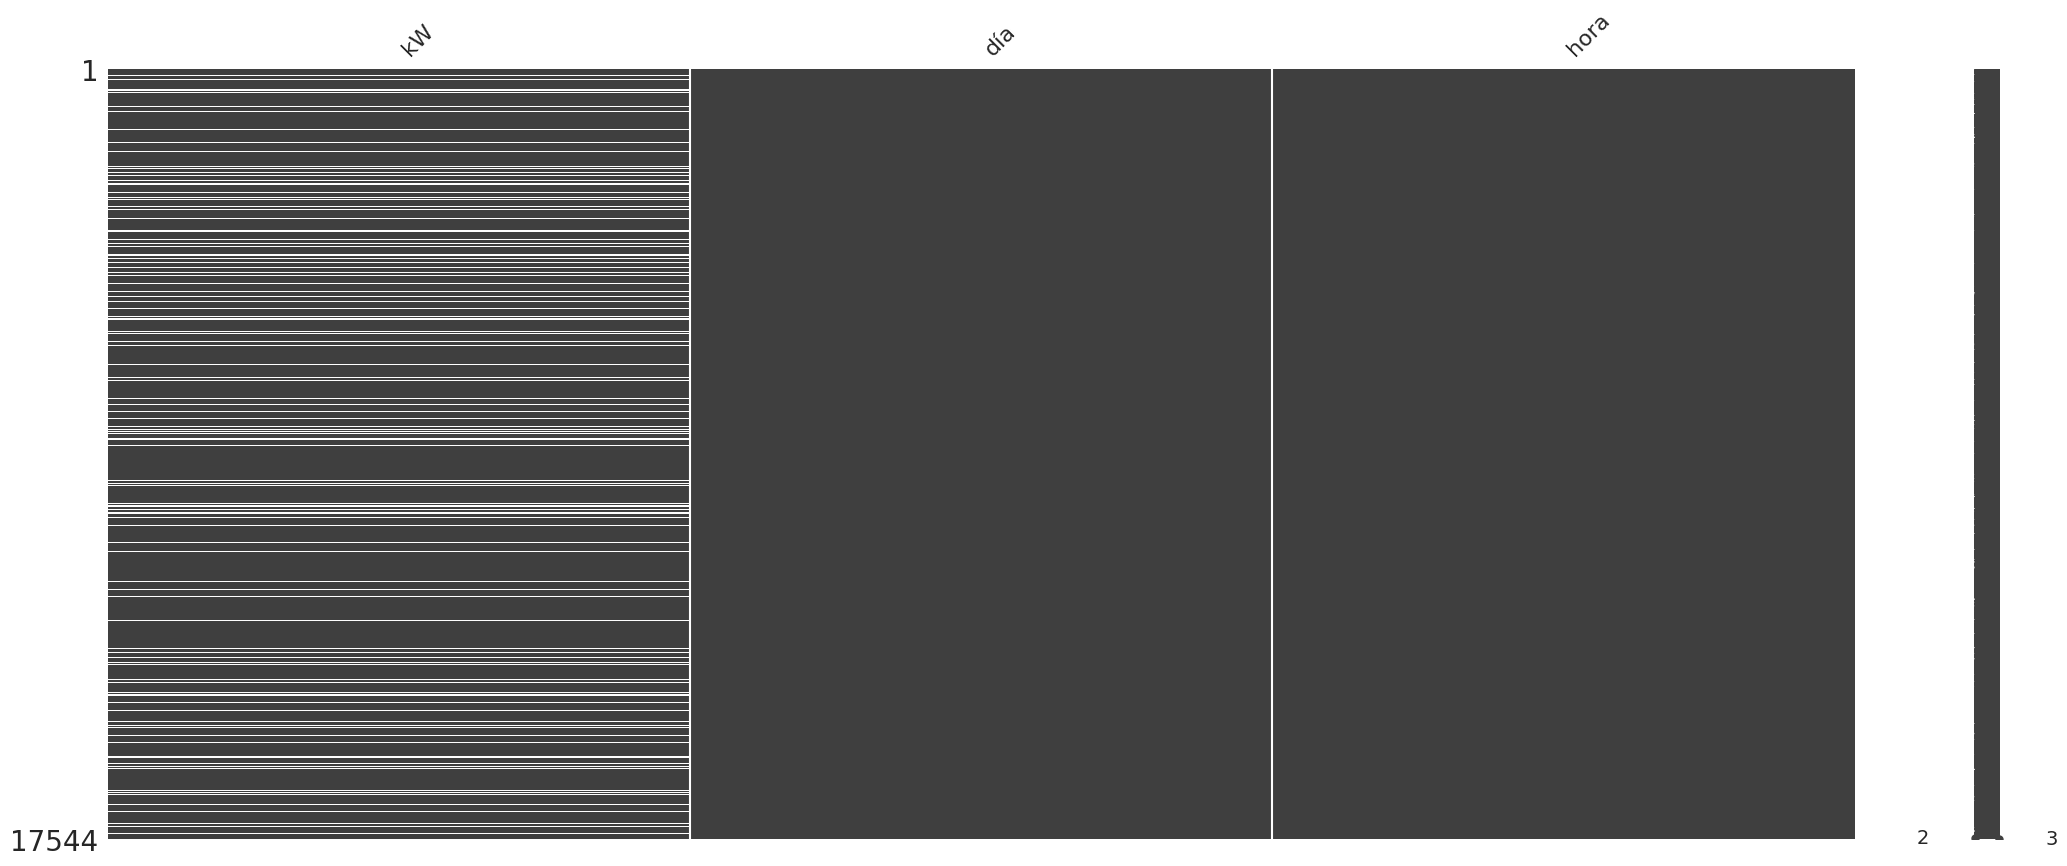

In [49]:
%matplotlib inline
msno.matrix(df_patron1_15)


In [50]:
# Se compara cant de valores nulos
print("Nulos Patron 1 MCAR:", df_patron1_15['kW'].isnull().sum())

Nulos Patron 1 MCAR: 2583


In [51]:
#Mmask15: Posiciones que fueron amputadas
mask_patron1_15=df_patron1_15['kW'].isna()
print("Cantidad de nulos mask mcar:", mask_patron1_15.sum())

Cantidad de nulos mask mcar: 2583


###8.1.4.Generación de valores faltantes 20%

In [52]:
df_patron1_20kw = df_base[['kW','día','hora']]


# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW': 0},  # Se usa MCAR puro porque no tiene peso
    'freq': 1,
    'mechanism': 'MCAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.20,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron1_20 = amputer.fit_transform(df_patron1_20kw)


<Axes: >

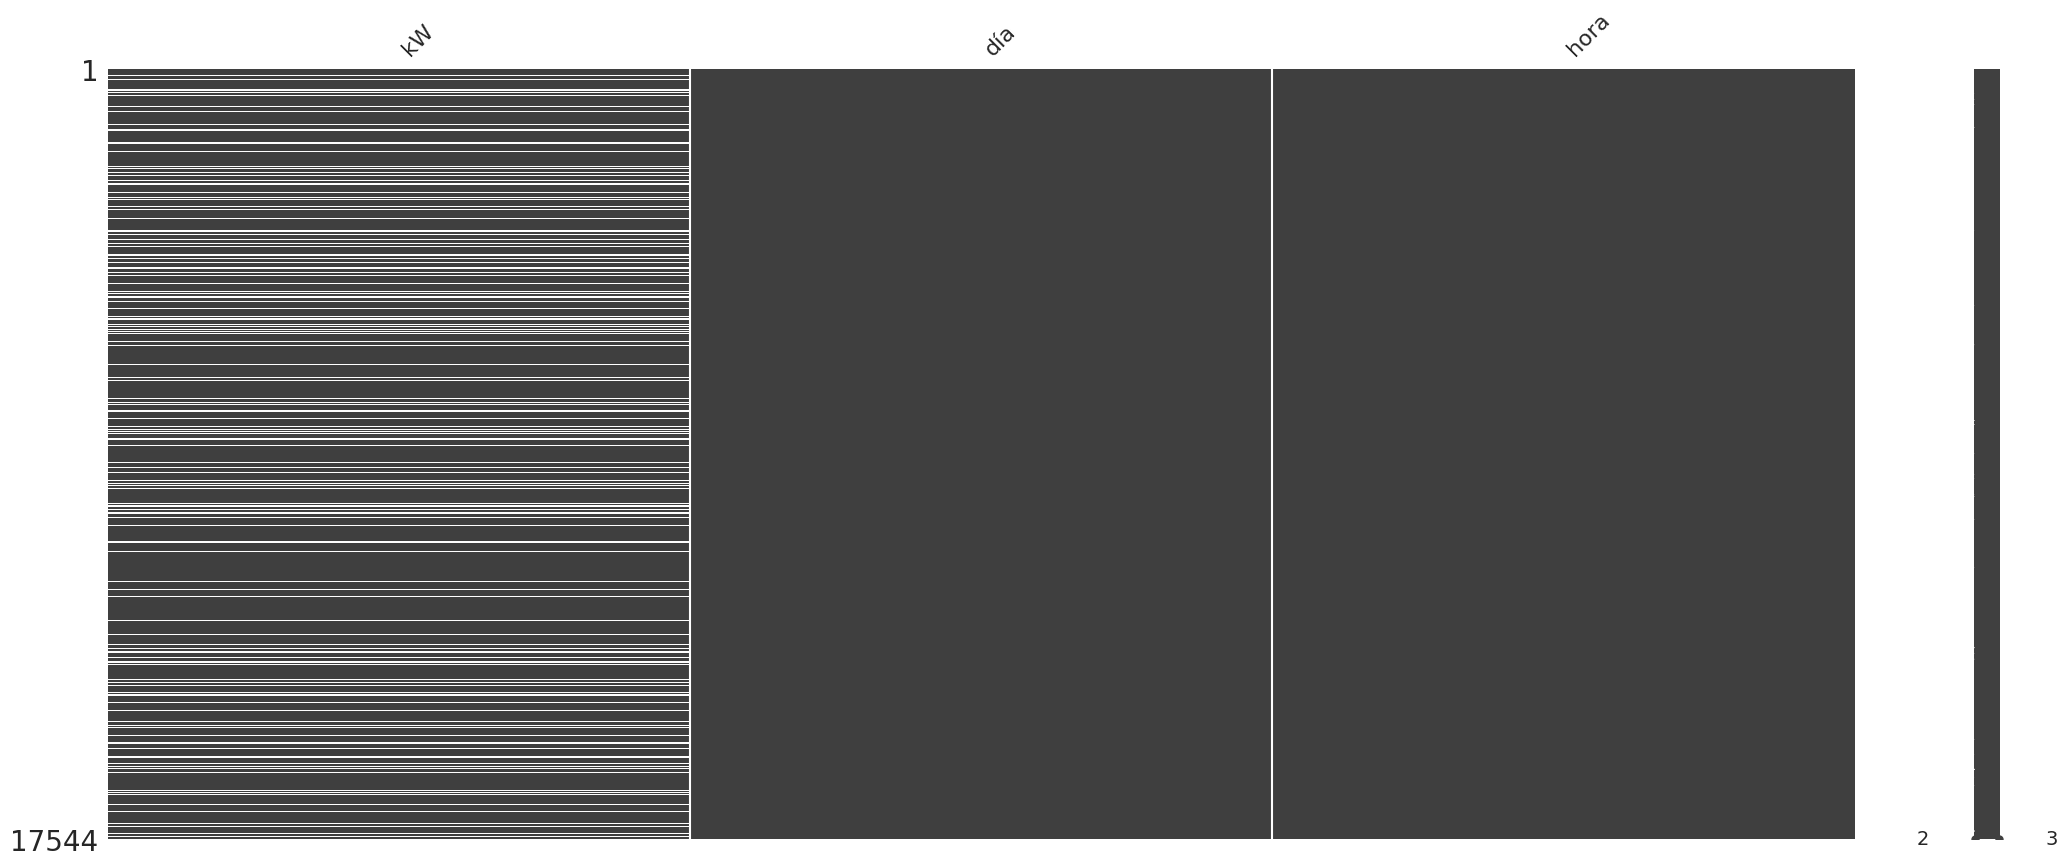

In [53]:
%matplotlib inline
msno.matrix(df_patron1_20)

In [54]:
# Se compara cant de valores nulos
print("Nulos Patron 1 MCAR:", df_patron1_20['kW'].isnull().sum())

Nulos Patron 1 MCAR: 3491


In [55]:
#Mmask20: Posiciones que fueron amputadas
mask_patron1_20=df_patron1_20['kW'].isna()
print("Cantidad de nulos mask mcar:", mask_patron1_20.sum())

Cantidad de nulos mask mcar: 3491


###8.1.5.Generación de valores faltantes 30%

In [56]:
df_patron1_30kw = df_base[['kW','día','hora']]


# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW': 0},  # Se usa MCAR puro porque no tiene peso
    'freq': 1,
    'mechanism': 'MCAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.30,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron1_30 = amputer.fit_transform(df_patron1_30kw)


<Axes: >

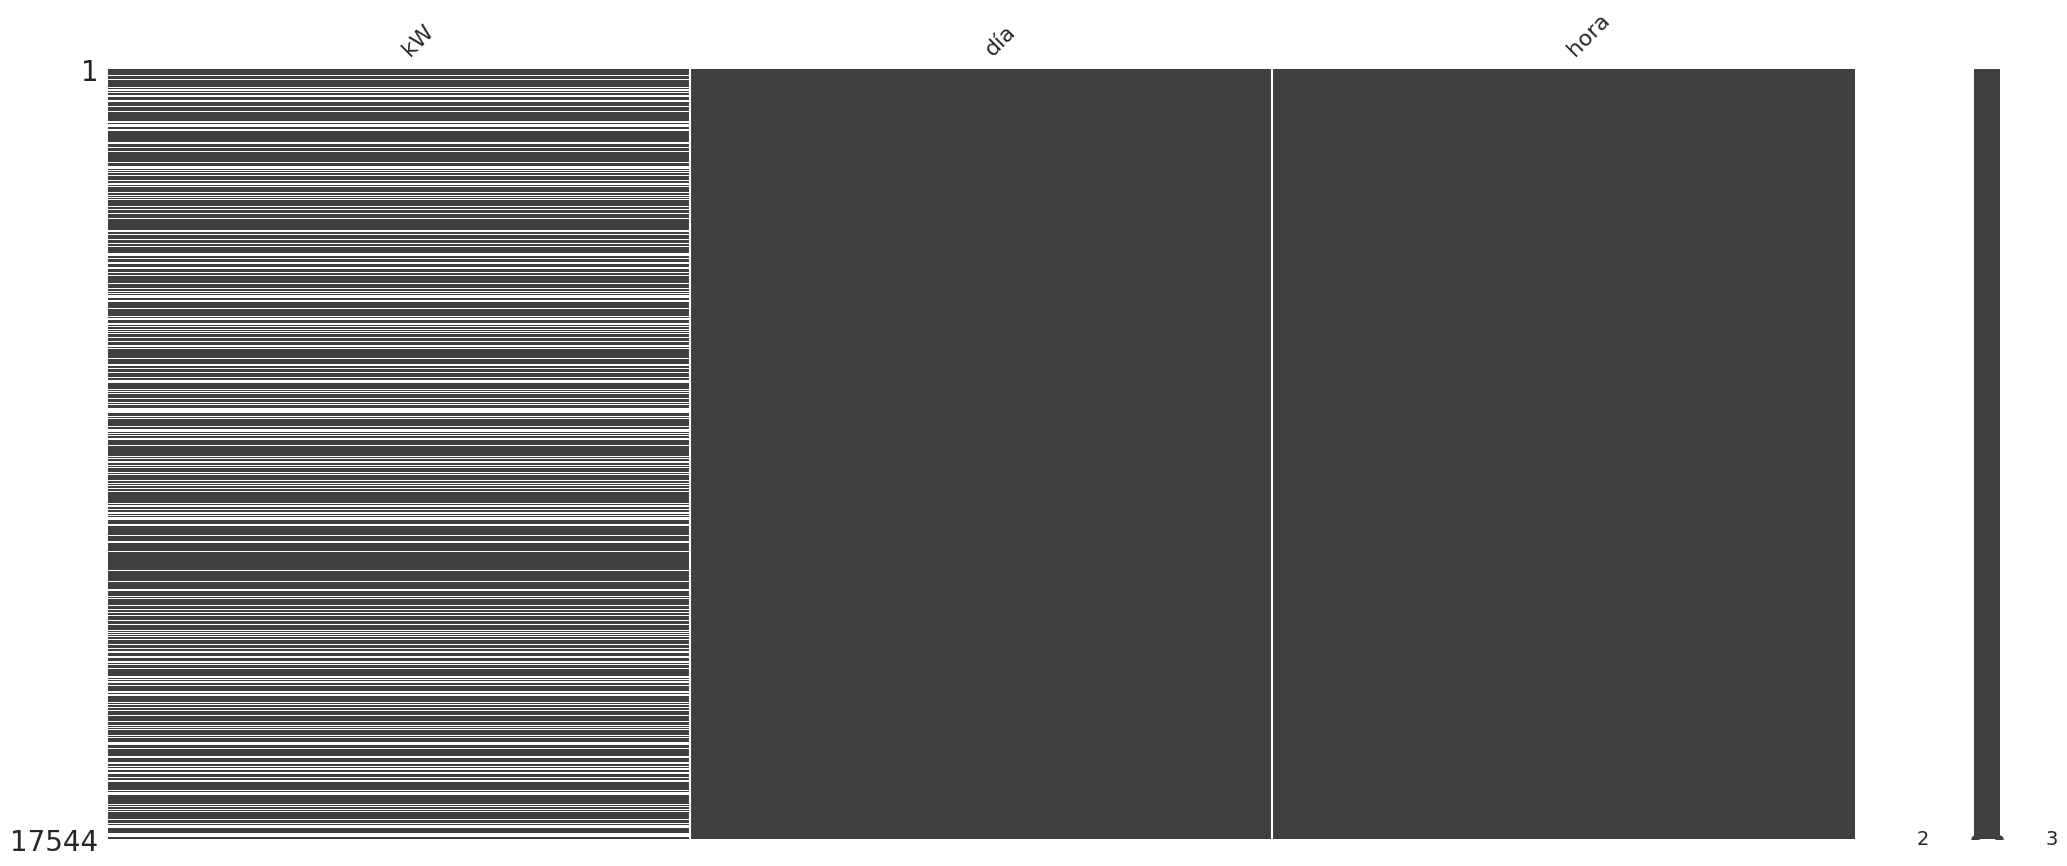

In [57]:
%matplotlib inline
msno.matrix(df_patron1_30)

In [58]:
# Se compara cant de valores nulos
print("Nulos Patron 1 MCAR:", df_patron1_30['kW'].isnull().sum())

Nulos Patron 1 MCAR: 5331


In [59]:
#Mmask30: Posiciones que fueron amputadas
mask_patron1_30=df_patron1_30['kW'].isna()
print("Cantidad de nulos mask mcar:", mask_patron1_30.sum())

Cantidad de nulos mask mcar: 5331


## 8.2 Generación de valores faltantes Patron2

###8.2.1 Generación de valores faltantes 5%


In [60]:
df_patron2_5kw = df_base[['kW','día','hora']]


# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW':1,'hora':0.5},  # KW se amputa en si mismo (MNAR) y de hora (MAR)
    'freq': 1,
    'mechanism': 'MAR+MNAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.05,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron2_5 = amputer.fit_transform(df_patron2_5kw)


<Axes: >

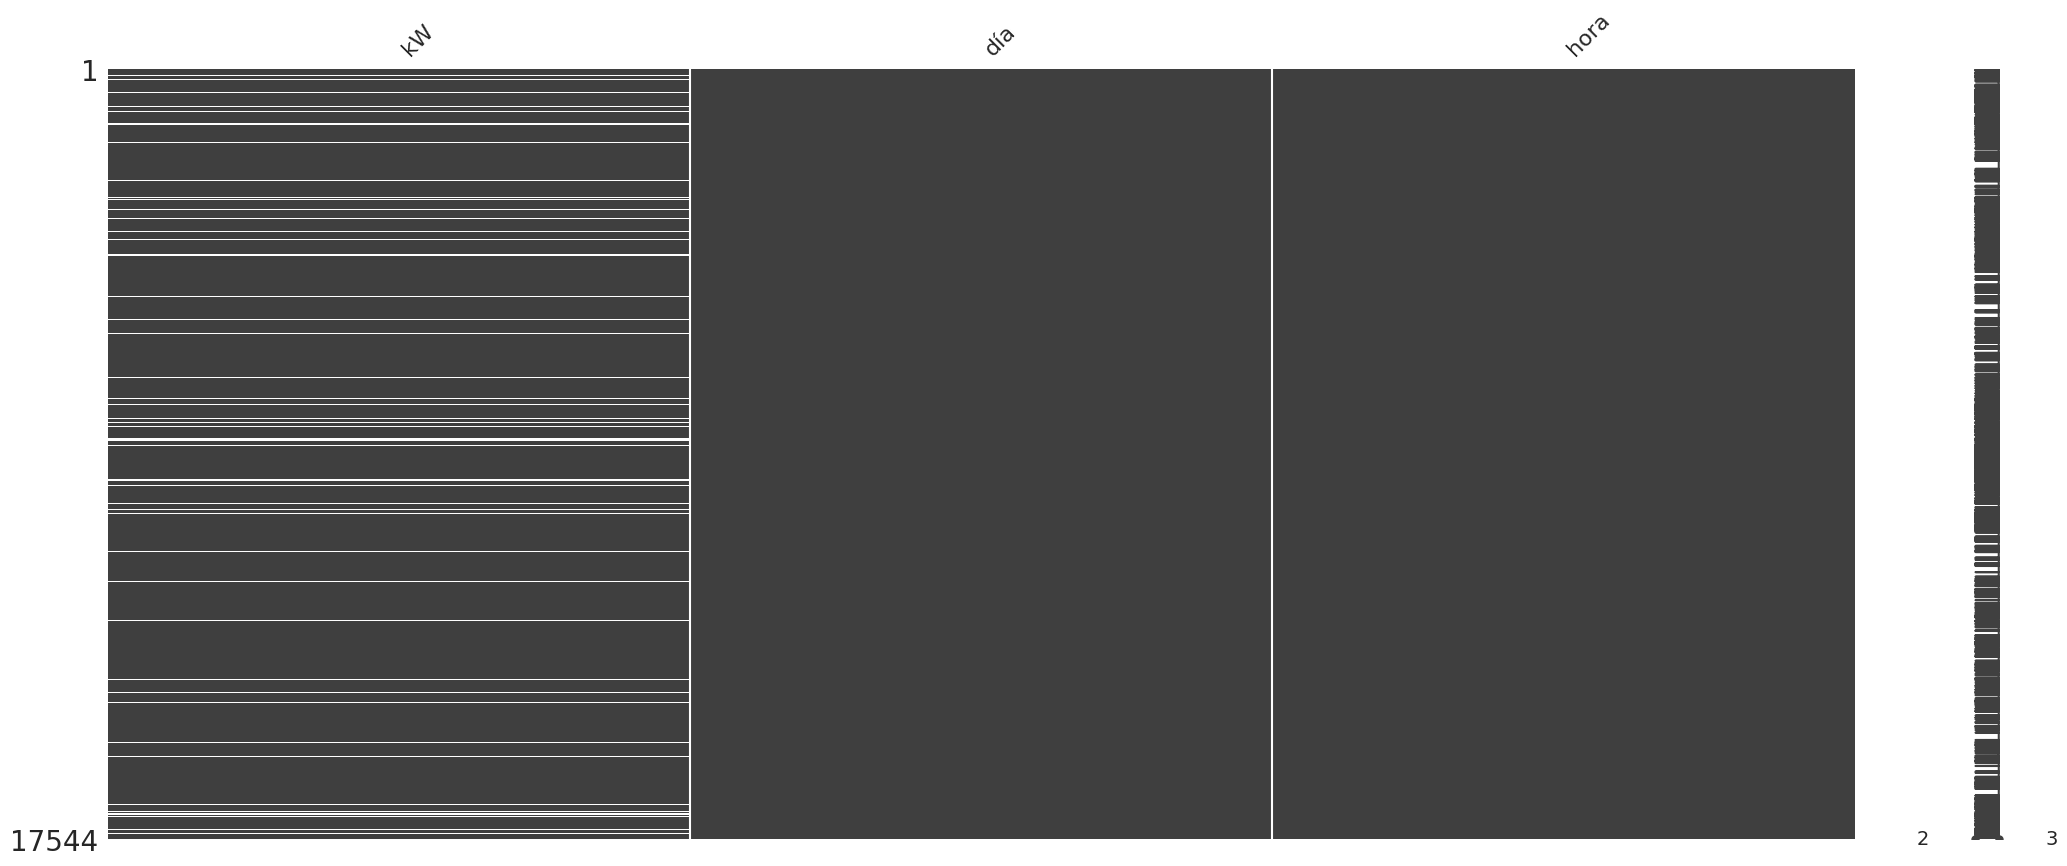

In [61]:
%matplotlib inline
msno.matrix(df_patron2_5)

In [62]:
# Se compara cant de valores nulos
print("Nulos Patron 2 MNAR+MAR:", df_patron2_5['kW'].isnull().sum())

Nulos Patron 2 MNAR+MAR: 1307


In [63]:
#Mmask5: Posiciones que fueron amputadas
mask_patron2_5=df_patron2_5['kW'].isna()
print("Cantidad de nulos mask MNAR+MAR:", mask_patron2_5.sum())

Cantidad de nulos mask MNAR+MAR: 1307


###8.2.2 Generación de valores faltantes 10%


In [64]:
df_patron2_10kw = df_base[['kW','día','hora']]

# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW':1,'hora':0.5},  # KW se amputa en si mismo (MNAR) y de hora (MAR)
    'freq': 1,
    'mechanism': 'MAR+MNAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.10,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron2_10 = amputer.fit_transform(df_patron2_10kw)


<Axes: >

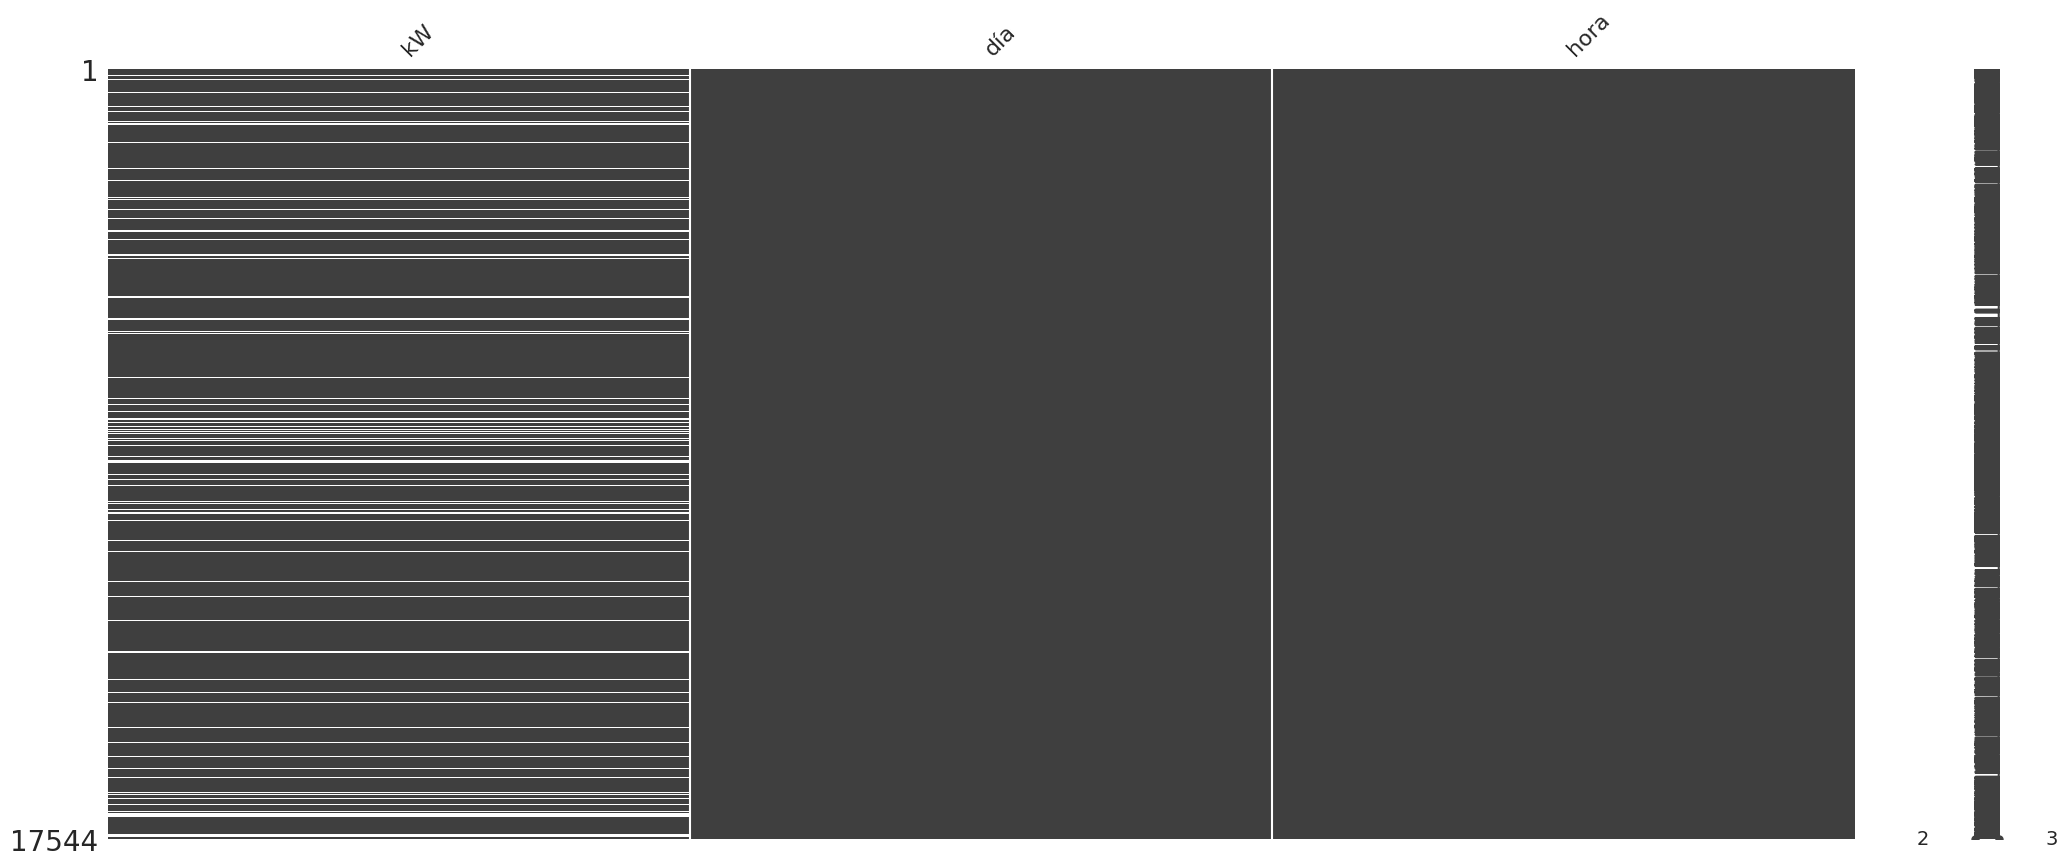

In [65]:
%matplotlib inline
msno.matrix(df_patron2_10)

In [66]:
# Se compara cant de valores nulos
print("Nulos Patron 2 MNAR+MAR:", df_patron2_10['kW'].isnull().sum())

Nulos Patron 2 MNAR+MAR: 1823


In [67]:
#Mmask5: Posiciones que fueron amputadas
mask_patron2_10=df_patron2_10['kW'].isna()
print("Cantidad de nulos mask MNAR+MAR:", mask_patron2_10.sum())

Cantidad de nulos mask MNAR+MAR: 1823


###8.2.3 Generación de valores faltantes 15%


In [68]:
df_patron2_15kw = df_base[['kW','día','hora']]


# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW':1,'hora':0.5},  # KW se amputa en si mismo (MNAR) y de hora (MAR)
    'freq': 1,
    'mechanism': 'MAR+MNAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.15,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron2_15 = amputer.fit_transform(df_patron2_15kw)


<Axes: >

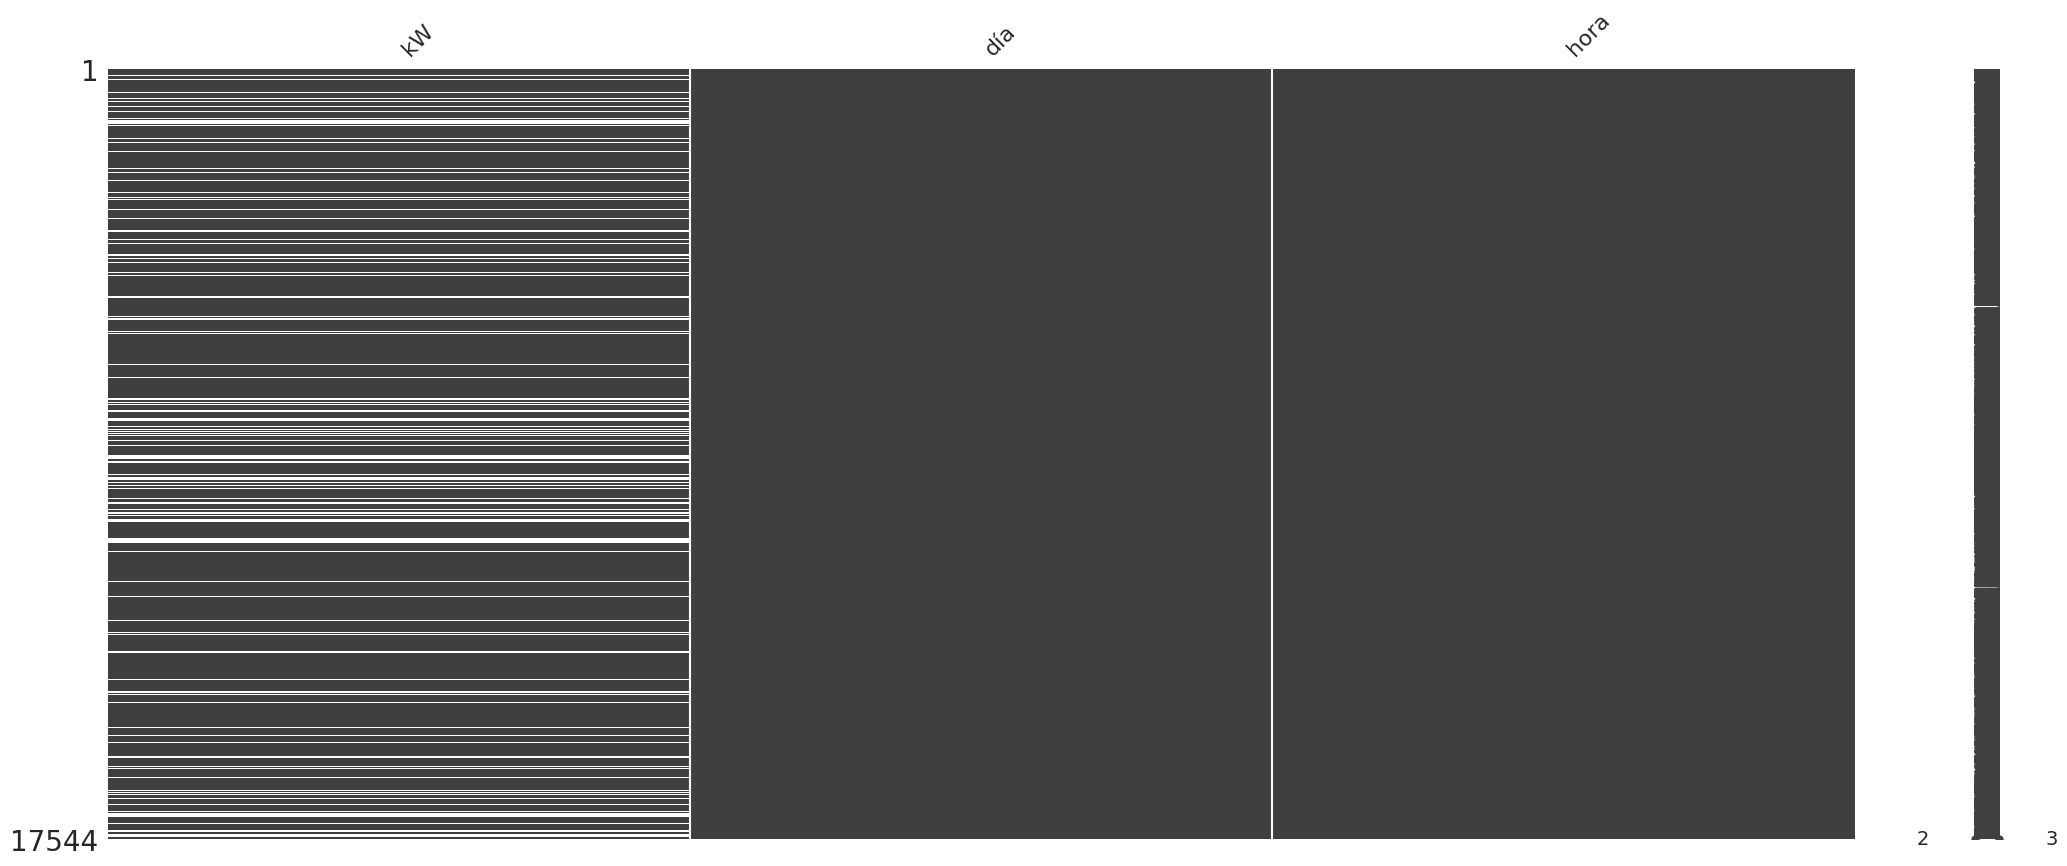

In [69]:
%matplotlib inline
msno.matrix(df_patron2_15)

In [70]:
# Se compara cant de valores nulos
print("Nulos Patron 2 MNAR+MAR:", df_patron2_15['kW'].isnull().sum())

Nulos Patron 2 MNAR+MAR: 2653


In [71]:
#Mmask15: Posiciones que fueron amputadas
mask_patron2_15=df_patron2_15['kW'].isna()
print("Cantidad de nulos mask MNAR+MAR:", mask_patron2_15.sum())

Cantidad de nulos mask MNAR+MAR: 2653


### 8.2.4 Generación de valores faltantes 20%


In [72]:
df_patron2_20kw = df_base[['kW','día','hora']]


# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW':1,'hora':0.5},  # KW se amputa en si mismo (MNAR) y de hora (MAR)
    'freq': 1,
    'mechanism': 'MAR+MNAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.20,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron2_20 = amputer.fit_transform(df_patron2_20kw)


<Axes: >

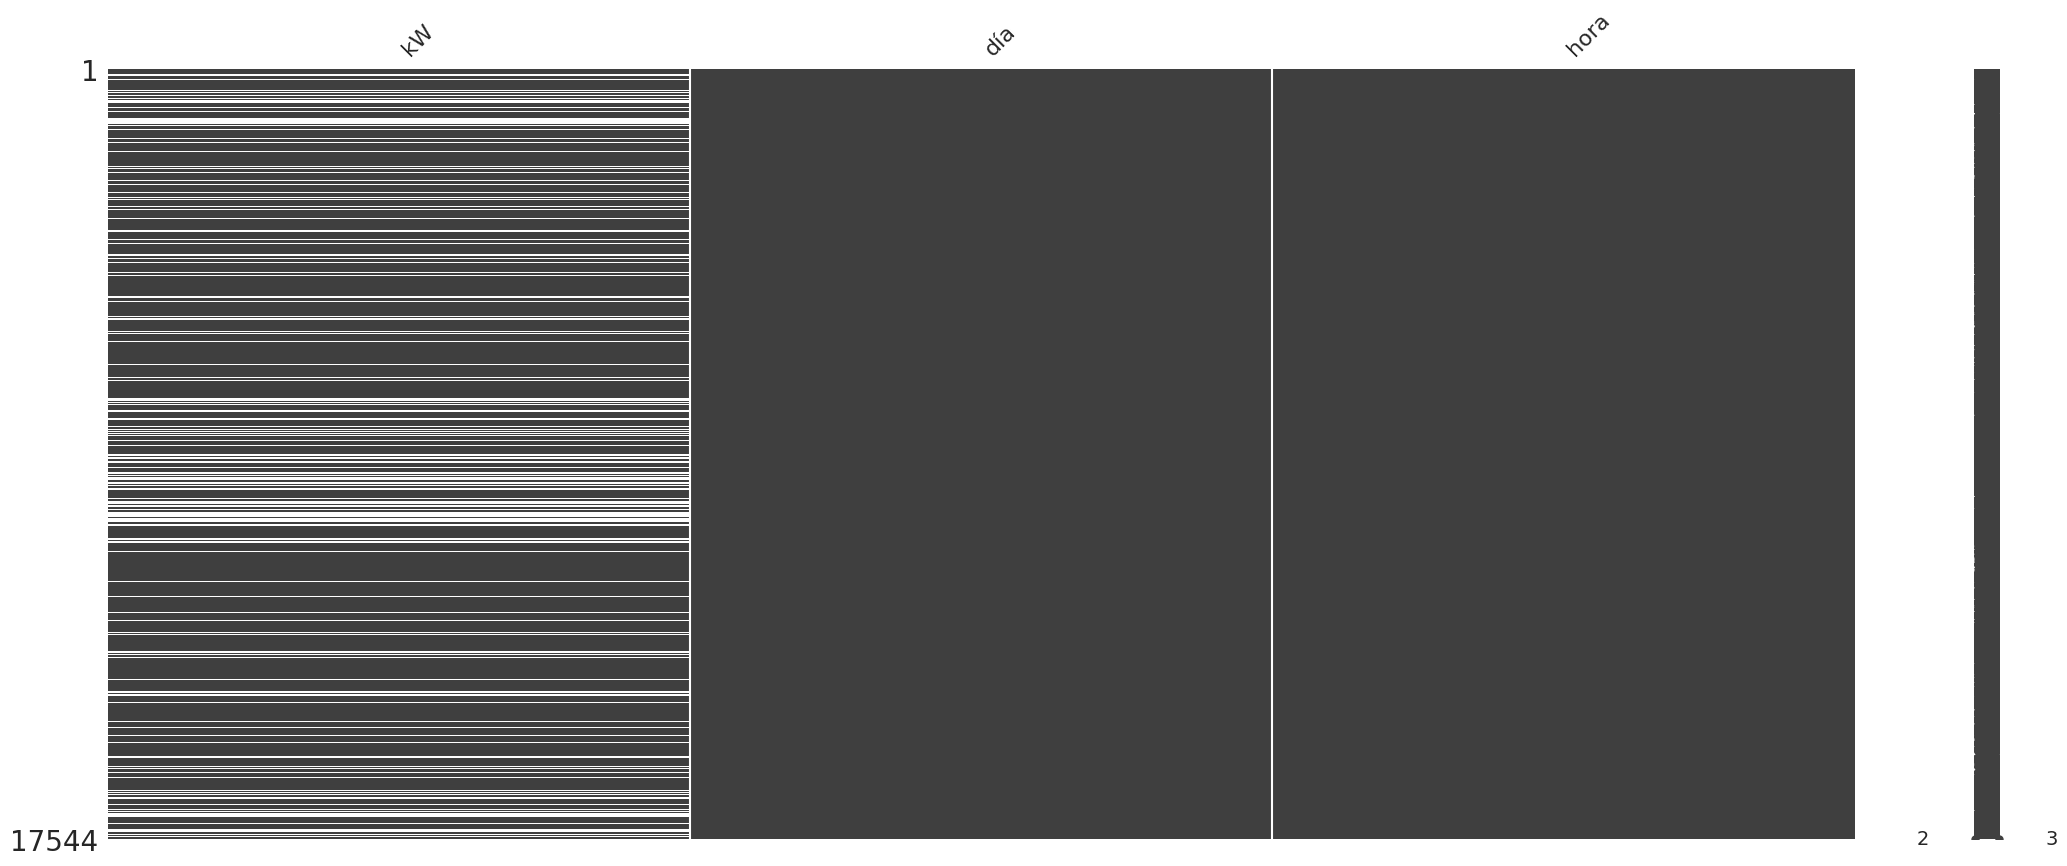

In [73]:
%matplotlib inline
msno.matrix(df_patron2_20)

In [74]:
# Se compara cant de valores nulos
print("Nulos Patron 2 MNAR+MAR:", df_patron2_20['kW'].isnull().sum())

Nulos Patron 2 MNAR+MAR: 3407


In [75]:
#Mmask20: Posiciones que fueron amputadas
mask_patron2_20=df_patron2_20['kW'].isna()
print("Cantidad de nulos mask MNAR+MAR:", mask_patron2_20.sum())

Cantidad de nulos mask MNAR+MAR: 3407


###8.2.5 Generación de valores faltantes 30%

In [76]:
df_patron2_30kw = df_base[['kW','día','hora']]


# Patterns
patterns = [{
    'incomplete_vars': ['kW'], #Se amputa la columna KW
    'weights': {'kW':1,'hora':0.5},  # KW se amputa en si mismo (MNAR) y de hora (MAR)
    'freq': 1,
    'mechanism': 'MAR+MNAR',
}]


# Aplicar amputación
amputer = MultivariateAmputation(
    prop=0.30,           # porcentaje de datos faltantes
    patterns=patterns,       # si es None, usa patrón simple
    std=True,
    seed=42,                 #Semilla
)

df_patron2_30 = amputer.fit_transform(df_patron2_30kw)

<Axes: >

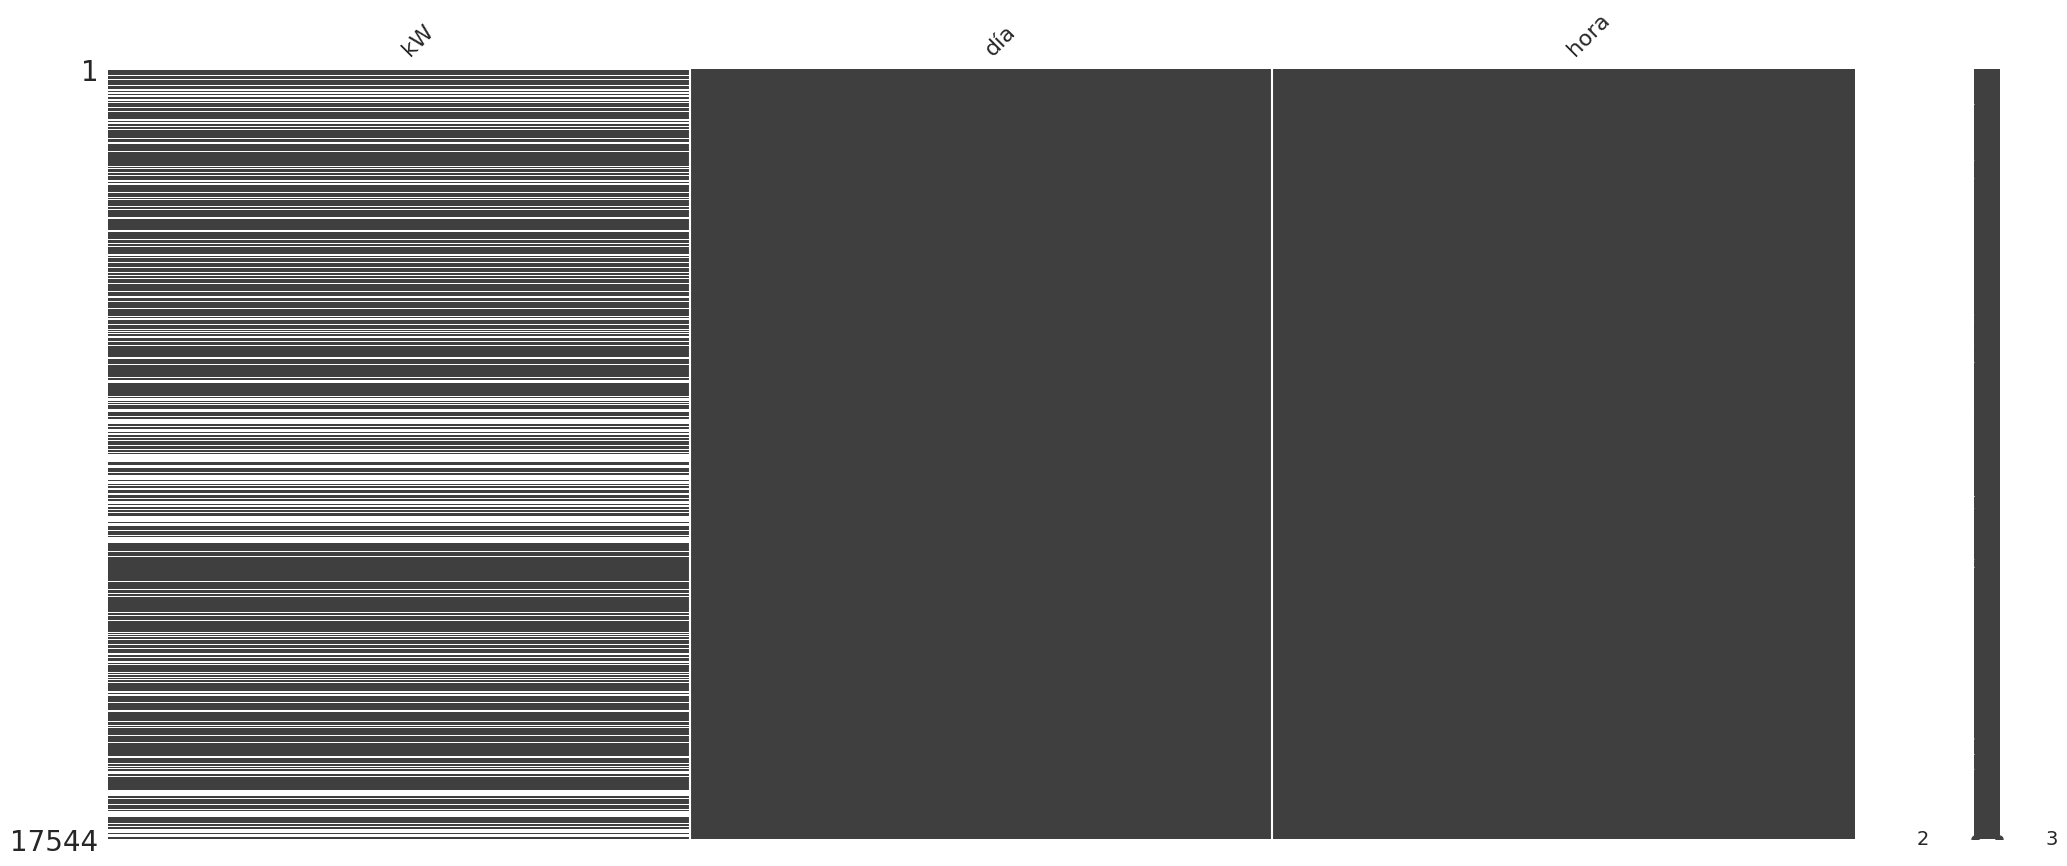

In [77]:
%matplotlib inline
msno.matrix(df_patron2_30)

In [78]:
# Se compara cant de valores nulos
print("Nulos Patron 2 MNAR+MAR:", df_patron2_30['kW'].isnull().sum())

Nulos Patron 2 MNAR+MAR: 5055


In [79]:
#Mmask30: Posiciones que fueron amputadas
mask_patron2_30=df_patron2_30['kW'].isna()
print("Cantidad de nulos mask MNAR+MAR:", mask_patron2_30.sum())

Cantidad de nulos mask MNAR+MAR: 5055


## 8.3 Visualización y Cantidad de NaN Patron1 y Patron2

In [80]:
datos_tabla1= ({

"Cantidad de datos NaN": ["5%","10%","15%","20%","30%"],

"Patron1": [df_patron1_5['kW'].isnull().sum(),df_patron1_10['kW'].isnull().sum(),df_patron1_15['kW'].isnull().sum(),df_patron1_20['kW'].isnull().sum(), df_patron1_30['kW'].isnull().sum()],

"Patron2": [df_patron2_5['kW'].isnull().sum(),df_patron2_10['kW'].isnull().sum(),df_patron2_15['kW'].isnull().sum(),df_patron2_20['kW'].isnull().sum(), df_patron2_30['kW'].isnull().sum()]

})

tabla1 = pd.DataFrame(datos_tabla1)
print(tabla1)

  Cantidad de datos NaN  Patron1  Patron2
0                    5%      864     1307
1                   10%     1725     1823
2                   15%     2583     2653
3                   20%     3491     3407
4                   30%     5331     5055


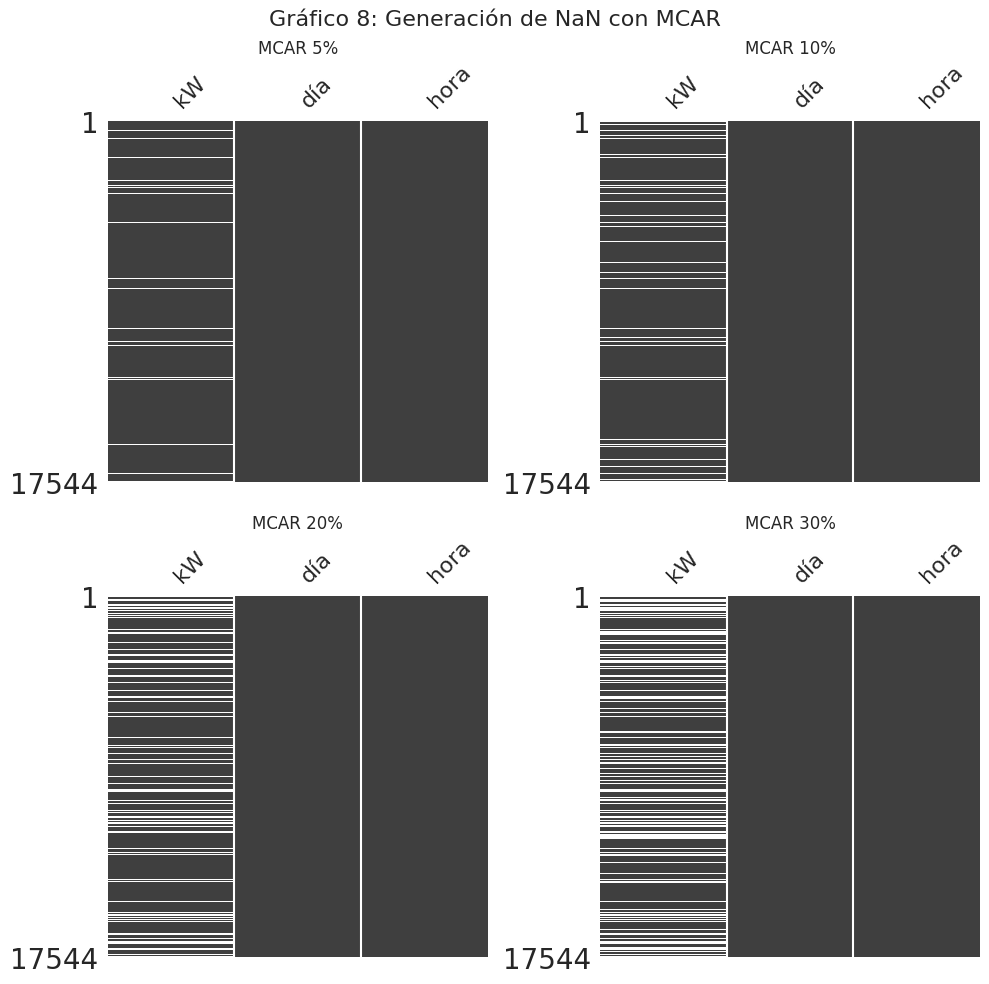

In [81]:
#Se genera un grafico múltiple con Subplots
# Se crea una figura con cuadrícula 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10)) # Axes[fila, columna], figsize(ancho, alto)

# Subplot 1

msno.matrix(df_patron1_5, ax=axes[0,0])
axes[0,0].set_title("MCAR 5%")

# Subplot 2
msno.matrix(df_patron1_10, ax=axes[0,1])
axes[0,1].set_title("MCAR 10%")

# Subplot 3
msno.matrix(df_patron1_20, ax=axes[1,0])
axes[1,0].set_title("MCAR 20%")

# Subplot 4
msno.matrix(df_patron1_30, ax=axes[1,1])
axes[1,1].set_title("MCAR 30%")


# Añadir título general
fig.suptitle('Gráfico 8: Generación de NaN con MCAR', fontsize=16)
plt.tight_layout()
plt.show()

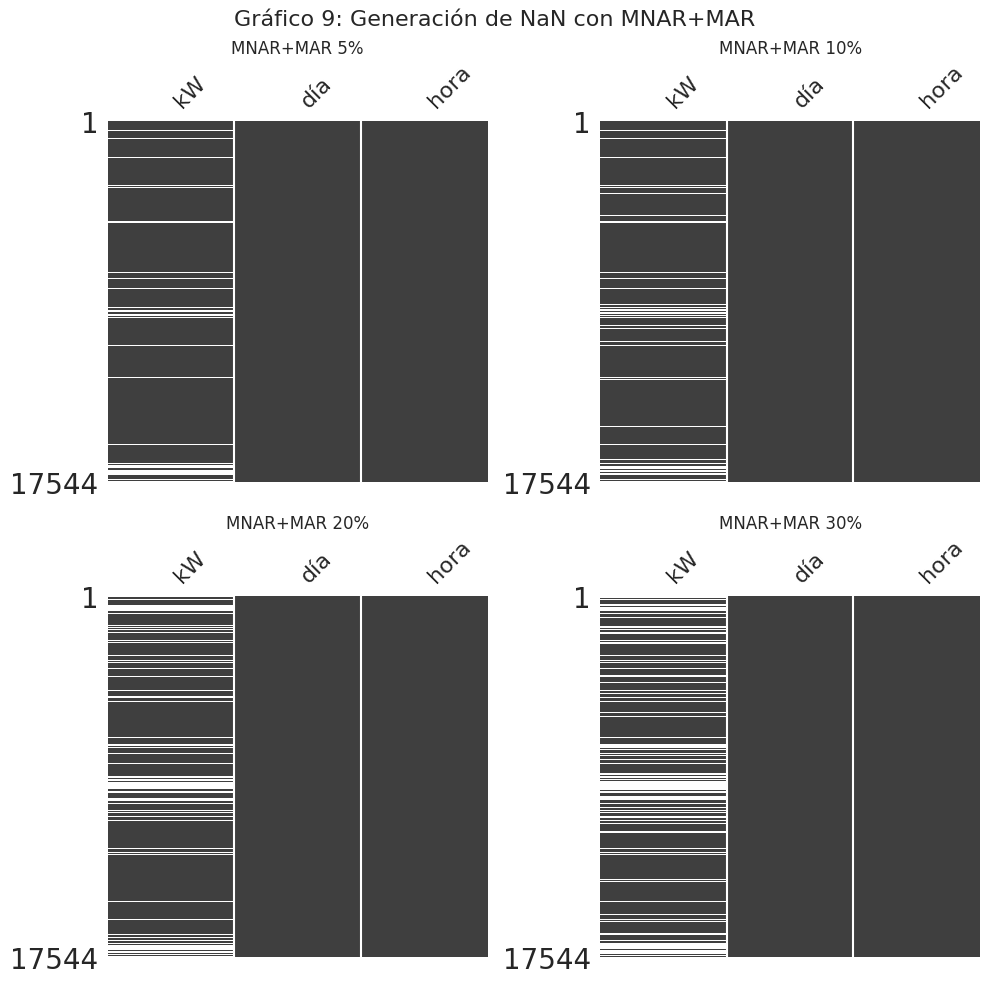

In [82]:
# Se crea una figura con cuadrícula 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10)) # Axes[fila, columna], figsize(ancho, alto)

# Subplot 1

msno.matrix(df_patron2_5, ax=axes[0,0])
axes[0,0].set_title("MNAR+MAR 5%")

# Subplot 2
msno.matrix(df_patron2_10, ax=axes[0,1])
axes[0,1].set_title("MNAR+MAR 10%")

# Subplot 3
msno.matrix(df_patron2_20, ax=axes[1,0])
axes[1,0].set_title("MNAR+MAR 20%")

# Subplot 4
msno.matrix(df_patron2_30, ax=axes[1,1])
axes[1,1].set_title("MNAR+MAR 30%")


# Añadir título general
fig.suptitle('Gráfico 9: Generación de NaN con MNAR+MAR', fontsize=16)
plt.tight_layout()
plt.show()

# 9. Imputacion Simple

Se realiza imputación simple a df_patron1 y df_patron 2 para 5,10,15,20,30% utilizando Simple imputer inputando con la mediana,media,moda,valor constante,interpolación lineal y temporal (asume una linea recta entre puntos conocidos), LOCF (utiliza el último valor concido)

##9.1 Imputación Patron1

###9.1.1 imputacion simple a 5%

In [83]:
df_patron1_5_imputed_median = df_patron1_5.copy()
df_patron1_5_imputed_mean = df_patron1_5.copy()
df_patron1_5_imputed_moda = df_patron1_5.copy()
df_patron1_5_imputed_constant = df_patron1_5.copy()
df_patron1_5_imputed_linear = df_patron1_5.copy()
df_patron1_5_imputed_time = df_patron1_5.copy()
df_patron1_5_imputed_locf = df_patron1_5.copy()

In [84]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')

# transformar el dataset
df_patron1_5_imputed_median['kW'] = imputermedian.fit_transform(df_patron1_5[['kW']])


print("Patron1 5% imputado mediana en la columna 'KW':")
print(df_patron1_5_imputed_median)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_5_imputed_median.isnull().sum())

# definir el imputador
imputermean = SimpleImputer(strategy='mean')

# transformar el dataset
df_patron1_5_imputed_mean['kW'] = imputermean.fit_transform(df_patron1_5[['kW']])


print("Patron1 5% imputado media en la columna 'KW':")
print(df_patron1_5_imputed_mean)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_5_imputed_mean.isnull().sum())

# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')

# transformar el dataset
df_patron1_5_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron1_5[['kW']])


print("Patron1 5% imputado moda en la columna 'KW':")
print(df_patron1_5_imputed_moda)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_5_imputed_moda.isnull().sum())

# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)

# transformar el dataset
df_patron1_5_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron1_5[['kW']])


print("Patron1 5% imputado valor constante en la columna 'KW':")
print(df_patron1_5_imputed_constant)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_5_imputed_constant.isnull().sum())


Patron1 5% imputado mediana en la columna 'KW':
                          kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                      ...  ...   ...
2020-12-31 19:00:00  115.872   31    19
2020-12-31 20:00:00   94.416   31    20
2020-12-31 21:00:00   90.528   31    21
2020-12-31 22:00:00   84.624   31    22
2020-12-31 23:00:00   65.424   31    23

[17544 rows x 3 columns]
Nulos en 'KW': kW      0
día     0
hora    0
dtype: int64
Patron1 5% imputado media en la columna 'KW':
                          kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                   

In [85]:
df_patron1_5_imputed_locf['kW'] = df_patron1_5['kW'].fillna(method='ffill').fillna(method='bfill')

In [86]:
df_patron1_5_imputed_linear['kW'] = df_patron1_5['kW'].interpolate(method='linear')
df_patron1_5_imputed_time['kW'] = df_patron1_5['kW'].interpolate(method='time')

###9.1.2 imputacion simple a 10%

In [87]:
df_patron1_10_imputed_median = df_patron1_10.copy()
df_patron1_10_imputed_mean = df_patron1_10.copy()
df_patron1_10_imputed_moda = df_patron1_10.copy()
df_patron1_10_imputed_constant = df_patron1_10.copy()
df_patron1_10_imputed_linear = df_patron1_10.copy()
df_patron1_10_imputed_time = df_patron1_10.copy()
df_patron1_10_imputed_locf = df_patron1_10.copy()

In [88]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron1_10_imputed_median['kW'] = imputermedian.fit_transform(df_patron1_10[['kW']])
print("Patron1 10% imputado mediana en la columna 'KW':")
print(df_patron1_10_imputed_median)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_10_imputed_median.isnull().sum())



# transformar el dataset
df_patron1_10_imputed_mean['kW'] = imputermean.fit_transform(df_patron1_10[['kW']])
print("Patron1 10% imputado media en la columna 'KW':")
print(df_patron1_10_imputed_mean)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_10_imputed_mean.isnull().sum())



# transformar el dataset
df_patron1_10_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron1_10[['kW']])
print("Patron1 10% imputado moda en la columna 'KW':")
print(df_patron1_10_imputed_moda)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_10_imputed_moda.isnull().sum())


# transformar el dataset
df_patron1_10_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron1_10[['kW']])
print("Patron1 10% imputado valor constante en la columna 'KW':")
print(df_patron1_10_imputed_constant)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_10_imputed_constant.isnull().sum())


Patron1 10% imputado mediana en la columna 'KW':
                          kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                      ...  ...   ...
2020-12-31 19:00:00  115.872   31    19
2020-12-31 20:00:00   94.416   31    20
2020-12-31 21:00:00   90.528   31    21
2020-12-31 22:00:00   84.624   31    22
2020-12-31 23:00:00   65.424   31    23

[17544 rows x 3 columns]
Nulos en 'KW': kW      0
día     0
hora    0
dtype: int64
Patron1 10% imputado media en la columna 'KW':
                          kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                 

In [89]:
df_patron1_10_imputed_locf['kW'] = df_patron1_10['kW'].fillna(method='ffill').fillna(method='bfill')
df_patron1_10_imputed_linear['kW'] = df_patron1_10['kW'].interpolate(method='linear')
df_patron1_10_imputed_time['kW'] = df_patron1_10['kW'].interpolate(method='time')

###9.1.3 imputacion simple a 15%

In [90]:
df_patron1_15_imputed_median = df_patron1_15.copy()
df_patron1_15_imputed_mean = df_patron1_15.copy()
df_patron1_15_imputed_moda = df_patron1_15.copy()
df_patron1_15_imputed_constant = df_patron1_15.copy()
df_patron1_15_imputed_linear = df_patron1_15.copy()
df_patron1_15_imputed_time = df_patron1_15.copy()
df_patron1_15_imputed_locf = df_patron1_15.copy()

In [91]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron1_15_imputed_median['kW'] = imputermedian.fit_transform(df_patron1_15[['kW']])
print("Patron1 15% imputado mediana en la columna 'KW':")
print(df_patron1_15_imputed_median)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_15_imputed_median.isnull().sum())



# transformar el dataset
df_patron1_15_imputed_mean['kW'] = imputermean.fit_transform(df_patron1_15[['kW']])
print("Patron1 15% imputado media en la columna 'KW':")
print(df_patron1_15_imputed_mean)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_15_imputed_mean.isnull().sum())



# transformar el dataset
df_patron1_15_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron1_15[['kW']])
print("Patron1 15% imputado moda en la columna 'KW':")
print(df_patron1_15_imputed_moda)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_15_imputed_moda.isnull().sum())


# transformar el dataset
df_patron1_15_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron1_15[['kW']])
print("Patron1 15% imputado valor constante en la columna 'KW':")
print(df_patron1_15_imputed_constant)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_15_imputed_constant.isnull().sum())

Patron1 15% imputado mediana en la columna 'KW':
                          kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                      ...  ...   ...
2020-12-31 19:00:00  115.872   31    19
2020-12-31 20:00:00   94.416   31    20
2020-12-31 21:00:00   90.528   31    21
2020-12-31 22:00:00   84.624   31    22
2020-12-31 23:00:00   65.424   31    23

[17544 rows x 3 columns]
Nulos en 'KW': kW      0
día     0
hora    0
dtype: int64
Patron1 15% imputado media en la columna 'KW':
                          kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                 

In [92]:
df_patron1_15_imputed_locf['kW'] = df_patron1_15['kW'].fillna(method='ffill').fillna(method='bfill')
df_patron1_15_imputed_linear['kW'] = df_patron1_15['kW'].interpolate(method='linear')
df_patron1_15_imputed_time['kW'] = df_patron1_15['kW'].interpolate(method='time')

###9.1.4 imputacion simple a 20%

In [93]:
df_patron1_20_imputed_median = df_patron1_20.copy()
df_patron1_20_imputed_mean = df_patron1_20.copy()
df_patron1_20_imputed_moda = df_patron1_20.copy()
df_patron1_20_imputed_constant = df_patron1_20.copy()
df_patron1_20_imputed_linear = df_patron1_20.copy()
df_patron1_20_imputed_time = df_patron1_20.copy()
df_patron1_20_imputed_locf = df_patron1_20.copy()

In [94]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron1_20_imputed_median['kW'] = imputermedian.fit_transform(df_patron1_20[['kW']])
print("Patron1 20% imputado mediana en la columna 'KW':")
print(df_patron1_20_imputed_median)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_20_imputed_median.isnull().sum())



# transformar el dataset
df_patron1_20_imputed_mean['kW'] = imputermean.fit_transform(df_patron1_20[['kW']])
print("Patron1 20% imputado media en la columna 'KW':")
print(df_patron1_20_imputed_mean)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_20_imputed_mean.isnull().sum())



# transformar el dataset
df_patron1_20_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron1_20[['kW']])
print("Patron1 20% imputado moda en la columna 'KW':")
print(df_patron1_20_imputed_moda)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_20_imputed_moda.isnull().sum())


# transformar el dataset
df_patron1_20_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron1_20[['kW']])
print("Patron1 20% imputado valor constante en la columna 'KW':")
print(df_patron1_20_imputed_constant)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_20_imputed_constant.isnull().sum())

Patron1 20% imputado mediana en la columna 'KW':
                          kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   57.840    1     3
2019-01-01 04:00:00   69.984    1     4
...                      ...  ...   ...
2020-12-31 19:00:00  115.872   31    19
2020-12-31 20:00:00   94.416   31    20
2020-12-31 21:00:00   90.528   31    21
2020-12-31 22:00:00   84.624   31    22
2020-12-31 23:00:00   36.240   31    23

[17544 rows x 3 columns]
Nulos en 'KW': kW      0
día     0
hora    0
dtype: int64
Patron1 20% imputado media en la columna 'KW':
                             kW  día  hora
tiempo                                    
2019-01-01 00:00:00   48.000000    1     0
2019-01-01 01:00:00   49.488000    1     1
2019-01-01 02:00:00   52.608000    1     2
2019-01-01 03:00:00   57.840000    1     3
2019-01-01 04:00:00   69.984000    1     4

In [95]:
df_patron1_20_imputed_locf['kW'] = df_patron1_20['kW'].fillna(method='ffill').fillna(method='bfill')
df_patron1_20_imputed_linear['kW'] = df_patron1_20['kW'].interpolate(method='linear')
df_patron1_20_imputed_time['kW'] = df_patron1_20['kW'].interpolate(method='time')

###9.1.5 imputacion simple a 30%

In [96]:
df_patron1_30_imputed_median = df_patron1_30.copy()
df_patron1_30_imputed_mean = df_patron1_30.copy()
df_patron1_30_imputed_moda = df_patron1_30.copy()
df_patron1_30_imputed_constant = df_patron1_30.copy()
df_patron1_30_imputed_linear = df_patron1_30.copy()
df_patron1_30_imputed_time = df_patron1_30.copy()
df_patron1_30_imputed_locf = df_patron1_30.copy()

In [97]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron1_30_imputed_median['kW'] = imputermedian.fit_transform(df_patron1_30[['kW']])
print("Patron1 30% imputado mediana en la columna 'KW':")
print(df_patron1_30_imputed_median)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_30_imputed_median.isnull().sum())



# transformar el dataset
df_patron1_30_imputed_mean['kW'] = imputermean.fit_transform(df_patron1_30[['kW']])
print("Patron1 30% imputado media en la columna 'KW':")
print(df_patron1_30_imputed_mean)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_30_imputed_mean.isnull().sum())



# transformar el dataset
df_patron1_30_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron1_30[['kW']])
print("Patron1 30% imputado moda en la columna 'KW':")
print(df_patron1_30_imputed_moda)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_30_imputed_moda.isnull().sum())


# transformar el dataset
df_patron1_30_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron1_30[['kW']])
print("Patron1 30% imputado valor constante en la columna 'KW':")
print(df_patron1_30_imputed_constant)

# Mostrar el total de nulos
print("Nulos en 'KW':" ,df_patron1_30_imputed_constant.isnull().sum())

Patron1 30% imputado mediana en la columna 'KW':
                          kW  día  hora
tiempo                                 
2019-01-01 00:00:00   48.000    1     0
2019-01-01 01:00:00   49.488    1     1
2019-01-01 02:00:00   52.608    1     2
2019-01-01 03:00:00   36.336    1     3
2019-01-01 04:00:00   69.984    1     4
...                      ...  ...   ...
2020-12-31 19:00:00  115.872   31    19
2020-12-31 20:00:00   94.416   31    20
2020-12-31 21:00:00   36.336   31    21
2020-12-31 22:00:00   84.624   31    22
2020-12-31 23:00:00   36.336   31    23

[17544 rows x 3 columns]
Nulos en 'KW': kW      0
día     0
hora    0
dtype: int64
Patron1 30% imputado media en la columna 'KW':
                             kW  día  hora
tiempo                                    
2019-01-01 00:00:00   48.000000    1     0
2019-01-01 01:00:00   49.488000    1     1
2019-01-01 02:00:00   52.608000    1     2
2019-01-01 03:00:00   43.841319    1     3
2019-01-01 04:00:00   69.984000    1     4

In [98]:
df_patron1_30_imputed_locf['kW'] = df_patron1_30['kW'].fillna(method='ffill').fillna(method='bfill')
df_patron1_30_imputed_linear['kW'] = df_patron1_30['kW'].interpolate(method='linear')
df_patron1_30_imputed_time['kW'] = df_patron1_30['kW'].interpolate(method='time')

##9.2 Imputación Patron2

###9.2.1 imputacion simple a 5%

In [99]:
df_patron2_5_imputed_median = df_patron2_5.copy()
df_patron2_5_imputed_mean = df_patron2_5.copy()
df_patron2_5_imputed_moda = df_patron2_5.copy()
df_patron2_5_imputed_constant = df_patron2_5.copy()
df_patron2_5_imputed_linear = df_patron2_5.copy()
df_patron2_5_imputed_time = df_patron2_5.copy()
df_patron2_5_imputed_locf = df_patron2_5.copy()

In [100]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron2_5_imputed_median['kW'] = imputermedian.fit_transform(df_patron2_5[['kW']])

df_patron2_5_imputed_mean['kW'] = imputermean.fit_transform(df_patron2_5[['kW']])

df_patron2_5_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron2_5[['kW']])

df_patron2_5_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron2_5[['kW']])

df_patron2_5_imputed_locf['kW'] = df_patron2_5['kW'].fillna(method='ffill').fillna(method='bfill')

df_patron2_5_imputed_linear['kW'] = df_patron2_5['kW'].interpolate(method='linear')
df_patron2_5_imputed_time['kW'] = df_patron2_5['kW'].interpolate(method='time')

###9.2.2 imputacion simple a 10%

In [101]:
df_patron2_10_imputed_median = df_patron2_10.copy()
df_patron2_10_imputed_mean = df_patron2_10.copy()
df_patron2_10_imputed_moda = df_patron2_10.copy()
df_patron2_10_imputed_constant = df_patron2_10.copy()
df_patron2_10_imputed_linear = df_patron2_10.copy()
df_patron2_10_imputed_time = df_patron2_10.copy()
df_patron2_10_imputed_locf = df_patron2_10.copy()

In [102]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron2_10_imputed_median['kW'] = imputermedian.fit_transform(df_patron2_10[['kW']])

df_patron2_10_imputed_mean['kW'] = imputermean.fit_transform(df_patron2_10[['kW']])

df_patron2_10_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron2_10[['kW']])

df_patron2_10_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron2_10[['kW']])

df_patron2_10_imputed_locf['kW'] = df_patron2_10['kW'].fillna(method='ffill').fillna(method='bfill')

df_patron2_10_imputed_linear['kW'] = df_patron2_10['kW'].interpolate(method='linear')
df_patron2_10_imputed_time['kW'] = df_patron2_10['kW'].interpolate(method='time')

###9.2.3 imputacion simple a 15%

In [103]:
df_patron2_15_imputed_median = df_patron2_15.copy()
df_patron2_15_imputed_mean = df_patron2_15.copy()
df_patron2_15_imputed_moda = df_patron2_15.copy()
df_patron2_15_imputed_constant = df_patron2_15.copy()
df_patron2_15_imputed_linear = df_patron2_15.copy()
df_patron2_15_imputed_time = df_patron2_15.copy()
df_patron2_15_imputed_locf = df_patron2_15.copy()

In [104]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron2_15_imputed_median['kW'] = imputermedian.fit_transform(df_patron2_15[['kW']])

df_patron2_15_imputed_mean['kW'] = imputermean.fit_transform(df_patron2_15[['kW']])

df_patron2_15_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron2_15[['kW']])

df_patron2_15_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron2_15[['kW']])

df_patron2_15_imputed_locf['kW'] = df_patron2_15['kW'].fillna(method='ffill').fillna(method='bfill')

df_patron2_15_imputed_linear['kW'] = df_patron2_15['kW'].interpolate(method='linear')
df_patron2_15_imputed_time['kW'] = df_patron2_15['kW'].interpolate(method='time')

###9.2.4 imputacion simple a 20%

In [105]:
df_patron2_20_imputed_median = df_patron2_20.copy()
df_patron2_20_imputed_mean = df_patron2_20.copy()
df_patron2_20_imputed_moda = df_patron2_20.copy()
df_patron2_20_imputed_constant = df_patron2_20.copy()
df_patron2_20_imputed_linear = df_patron2_20.copy()
df_patron2_20_imputed_time = df_patron2_20.copy()
df_patron2_20_imputed_locf = df_patron2_20.copy()

In [106]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron2_20_imputed_median['kW'] = imputermedian.fit_transform(df_patron2_20[['kW']])

df_patron2_20_imputed_mean['kW'] = imputermean.fit_transform(df_patron2_20[['kW']])

df_patron2_20_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron2_20[['kW']])

df_patron2_20_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron2_20[['kW']])

df_patron2_20_imputed_locf['kW'] = df_patron2_20['kW'].fillna(method='ffill').fillna(method='bfill')

df_patron2_20_imputed_linear['kW'] = df_patron2_20['kW'].interpolate(method='linear')
df_patron2_20_imputed_time['kW'] = df_patron2_20['kW'].interpolate(method='time')

###9.2.5 imputacion simple a 30%

In [107]:
df_patron2_30_imputed_median = df_patron2_30.copy()
df_patron2_30_imputed_mean = df_patron2_30.copy()
df_patron2_30_imputed_moda = df_patron2_30.copy()
df_patron2_30_imputed_constant = df_patron2_30.copy()
df_patron2_30_imputed_linear = df_patron2_30.copy()
df_patron2_30_imputed_time = df_patron2_30.copy()
df_patron2_30_imputed_locf = df_patron2_30.copy()


In [108]:
# definir el imputador
imputermedian = SimpleImputer(strategy='median')
# definir el imputador
imputermean = SimpleImputer(strategy='mean')
# definir el imputador
imputerfrecuent = SimpleImputer(strategy='most_frequent')
# definir el imputador
imputerconstant = SimpleImputer(strategy='constant',fill_value=0)


# transformar el dataset
df_patron2_30_imputed_median['kW'] = imputermedian.fit_transform(df_patron2_30[['kW']])

df_patron2_30_imputed_mean['kW'] = imputermean.fit_transform(df_patron2_30[['kW']])

df_patron2_30_imputed_moda['kW'] = imputerfrecuent.fit_transform(df_patron2_30[['kW']])

df_patron2_30_imputed_constant['kW'] = imputerconstant.fit_transform(df_patron2_30[['kW']])

df_patron2_30_imputed_locf['kW'] = df_patron2_30['kW'].fillna(method='ffill').fillna(method='bfill')

df_patron2_30_imputed_linear['kW'] = df_patron2_30['kW'].interpolate(method='linear')
df_patron2_30_imputed_time['kW'] = df_patron2_30['kW'].interpolate(method='time')



## 9.3 Imputación Simple-Visualización

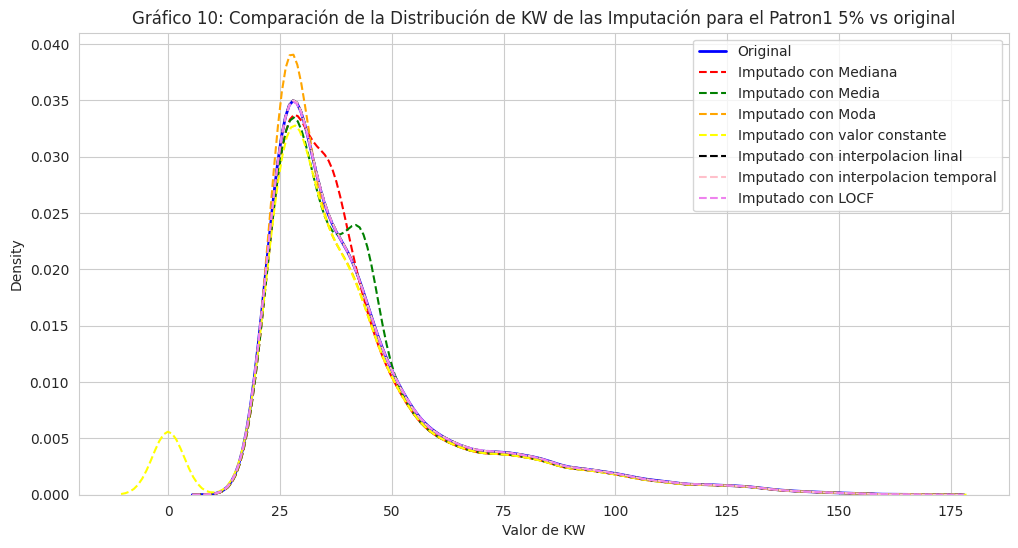

In [109]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_base.kW, label='Original', color='blue', linewidth=2)
sns.kdeplot(df_patron1_5_imputed_median.kW, label='Imputado con Mediana', color='red', linestyle='--')
sns.kdeplot(df_patron1_5_imputed_mean.kW, label='Imputado con Media', color='green', linestyle='--')
sns.kdeplot(df_patron1_5_imputed_moda.kW, label='Imputado con Moda', color='orange', linestyle='--')
sns.kdeplot(df_patron1_5_imputed_constant.kW, label='Imputado con valor constante', color='yellow', linestyle='--')
sns.kdeplot(df_patron1_5_imputed_linear.kW, label='Imputado con interpolacion linal', color='black', linestyle='--')
sns.kdeplot(df_patron1_5_imputed_time.kW, label='Imputado con interpolacion temporal', color='pink', linestyle='--')
sns.kdeplot(df_patron1_5_imputed_locf.kW, label='Imputado con LOCF', color='violet', linestyle='--')


plt.title('Gráfico 10: Comparación de la Distribución de KW de las Imputación para el Patron1 5% vs original')
plt.xlabel('Valor de KW')


plt.legend()
plt.show()

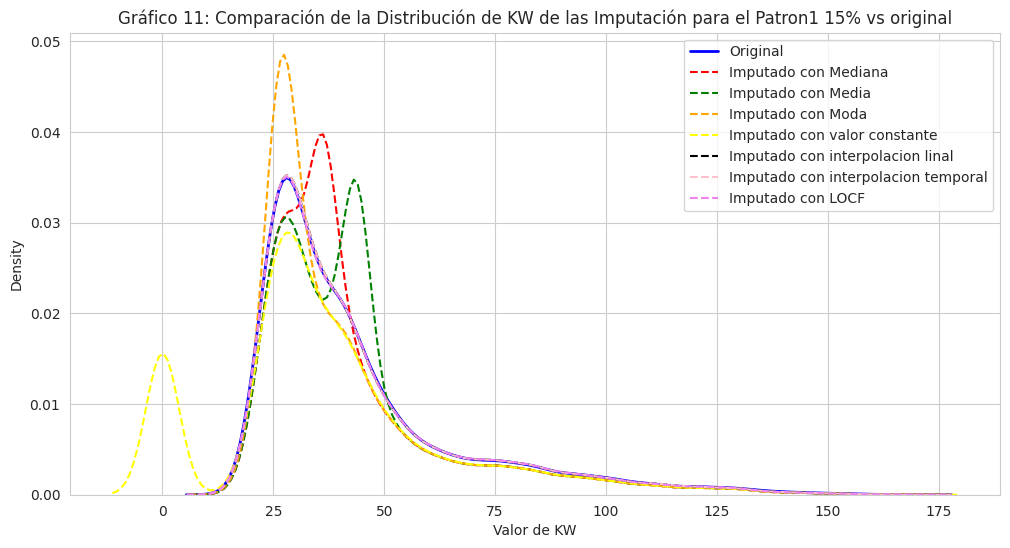

In [110]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_base.kW, label='Original', color='blue', linewidth=2)
sns.kdeplot(df_patron1_15_imputed_median.kW, label='Imputado con Mediana', color='red', linestyle='--')
sns.kdeplot(df_patron1_15_imputed_mean.kW, label='Imputado con Media', color='green', linestyle='--')
sns.kdeplot(df_patron1_15_imputed_moda.kW, label='Imputado con Moda', color='orange', linestyle='--')
sns.kdeplot(df_patron1_15_imputed_constant.kW, label='Imputado con valor constante', color='yellow', linestyle='--')
sns.kdeplot(df_patron1_15_imputed_linear.kW, label='Imputado con interpolacion linal', color='black', linestyle='--')
sns.kdeplot(df_patron1_15_imputed_time.kW, label='Imputado con interpolacion temporal', color='pink', linestyle='--')
sns.kdeplot(df_patron1_15_imputed_locf.kW, label='Imputado con LOCF', color='violet', linestyle='--')


plt.title('Gráfico 11: Comparación de la Distribución de KW de las Imputación para el Patron1 15% vs original')
plt.xlabel('Valor de KW')


plt.legend()
plt.show()

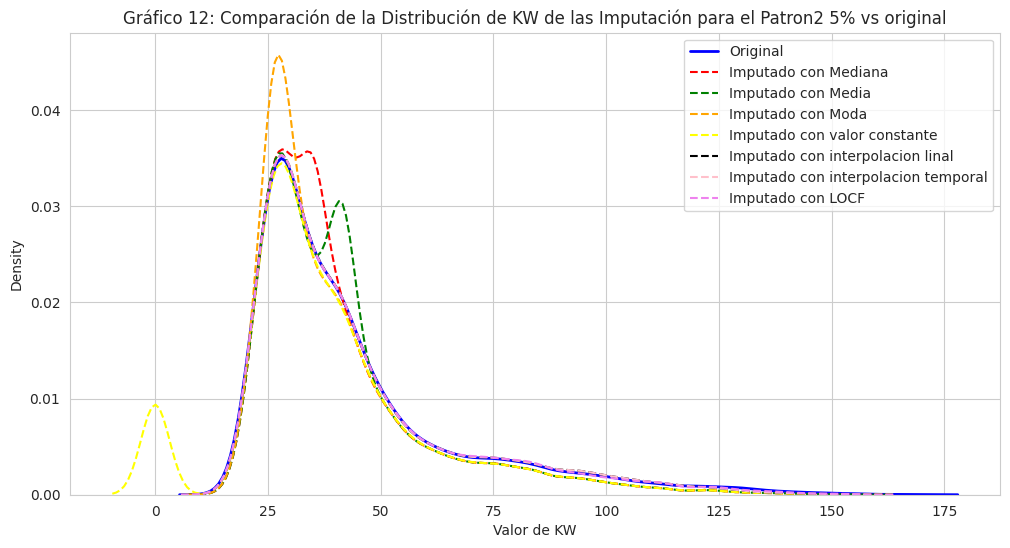

In [111]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_base.kW, label='Original', color='blue', linewidth=2)
sns.kdeplot(df_patron2_5_imputed_median.kW, label='Imputado con Mediana', color='red', linestyle='--')
sns.kdeplot(df_patron2_5_imputed_mean.kW, label='Imputado con Media', color='green', linestyle='--')
sns.kdeplot(df_patron2_5_imputed_moda.kW, label='Imputado con Moda', color='orange', linestyle='--')
sns.kdeplot(df_patron2_5_imputed_constant.kW, label='Imputado con valor constante', color='yellow', linestyle='--')
sns.kdeplot(df_patron2_5_imputed_linear.kW, label='Imputado con interpolacion linal', color='black', linestyle='--')
sns.kdeplot(df_patron2_5_imputed_time.kW, label='Imputado con interpolacion temporal', color='pink', linestyle='--')
sns.kdeplot(df_patron2_5_imputed_locf.kW, label='Imputado con LOCF', color='violet', linestyle='--')


plt.title('Gráfico 12: Comparación de la Distribución de KW de las Imputación para el Patron2 5% vs original')
plt.xlabel('Valor de KW')


plt.legend()
plt.show()

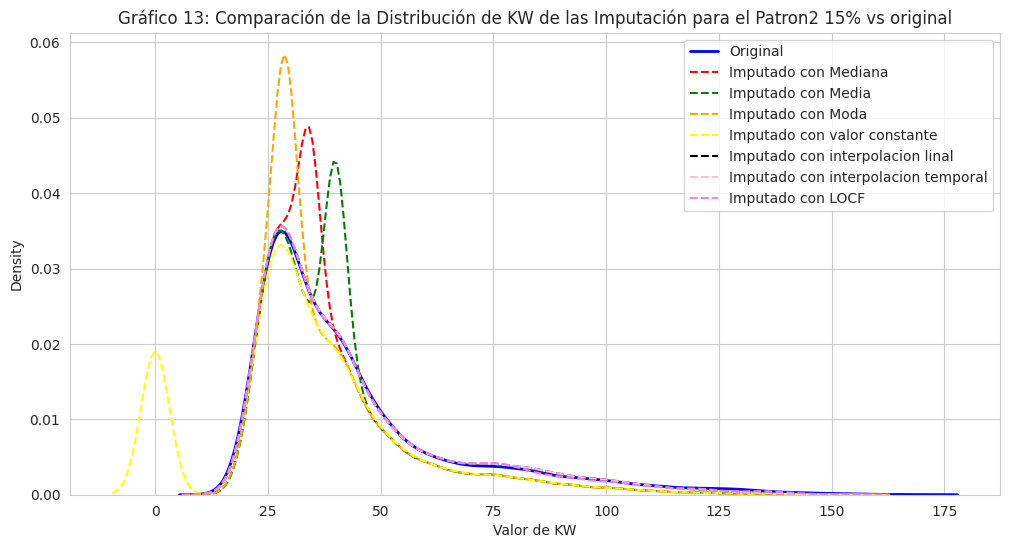

In [112]:
plt.figure(figsize=(12, 6))
sns.kdeplot(df_base.kW, label='Original', color='blue', linewidth=2)
sns.kdeplot(df_patron2_15_imputed_median.kW, label='Imputado con Mediana', color='red', linestyle='--')
sns.kdeplot(df_patron2_15_imputed_mean.kW, label='Imputado con Media', color='green', linestyle='--')
sns.kdeplot(df_patron2_15_imputed_moda.kW, label='Imputado con Moda', color='orange', linestyle='--')
sns.kdeplot(df_patron2_15_imputed_constant.kW, label='Imputado con valor constante', color='yellow', linestyle='--')
sns.kdeplot(df_patron2_15_imputed_linear.kW, label='Imputado con interpolacion linal', color='black', linestyle='--')
sns.kdeplot(df_patron2_15_imputed_time.kW, label='Imputado con interpolacion temporal', color='pink', linestyle='--')
sns.kdeplot(df_patron2_15_imputed_locf.kW, label='Imputado con LOCF', color='violet', linestyle='--')


plt.title('Gráfico 13: Comparación de la Distribución de KW de las Imputación para el Patron2 15% vs original')
plt.xlabel('Valor de KW')


plt.legend()
plt.show()

# 10.Imputacion avanzada - KNNImputer

Página principal KNNimputer: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

Parámetros:

* n_neighbors (default=5): número de vecinos cercanos

* weights (default="uniform"):

uniform: todos los vecinos tiene el mismo peso, promedio de los valores vecinos.

distance: Los vecinos mas cercanos tienen mayor influencia.

callable: Funcion definida por el usuario

* metric (default="nan_euclidean"): Especifica la métrica de distancia utilizada para encontrar los vecinos más cercanos.

* add_indicator (bool, default=False): Si es True, se agregan columnas binarias al conjunto de datos transformado para indicar dónde se imputaron los valores originales.

* missing_values (int, float, str, np.nan, default=np.nan): Define el valor que se debe considerar como "faltante" para la imputación.


Para poder estimar los valores NaN consecutivos se utiliza imputación avanzada

In [113]:
#df_analisis, sin NaN
#df_base_imp_avanzada, sin NaN, salida del instrumento

#df_patron2_5, con NaN 5%
#df_patron2_10, con NaN 10%
#df_patron2_15, con NaN 20%
#df_patron2_30, con NaN 30%

#df_patron1_5, con NaN 5%
#df_patron1_10, con NaN 10%
#df_patron1_15, con NaN 20%
#df_patron1_30, con NaN 30%


A df_analisis agregamos las columnas
 index= tiempo,
 kW,
 temperatura,
 año,
 mes,
 hora,
 dia,
 **estacion (verano,primavera,otoño,invierno)**,
 **tipo_dia (habil/no habil)**.

In [114]:
df_base_imp_avanzada=df_analisis.copy()

In [115]:
#Se agrega estacion por mes al df en una nueva columna
def asignar_estacion(mes):
    if mes in [12, 1, 2]:
        return 'verano'
    elif mes in [3,4,5]:
        return 'otoño'
    elif mes in [6,7, 8]:
        return 'invierno'
    elif mes in [9,10,11]:
        return 'primavera'


# Se agrega columna feriados en Argentina
años = df_base_imp_avanzada['tiempo'].dt.year.unique()
feriados_arg = holidays.AR(years=años)

# Función para clasificar cada fecha
def clasificar_dia(fecha):
    if fecha.weekday() >= 5 or fecha in feriados_arg:
        return 'no habil'
    else:
        return 'habil'

# Se Crean las nuevas columnas
df_base_imp_avanzada['estacion'] = df_base_imp_avanzada['mes'].apply(asignar_estacion)
df_base_imp_avanzada['tipo_dia'] = df_base_imp_avanzada['tiempo'].apply(clasificar_dia)


In [116]:
# se cambia el indice de df_base_imp_avanzada por 'tiempo'
df_base_imp_avanzada.set_index('tiempo', inplace=True)

In [117]:
df_base_imp_avanzada

kW  temperatura   año  mes  hora  día estacion  \
tiempo                                                                     
2019-01-01 00:00:00   48.000        27.55  2019    1     0    1   verano   
2019-01-01 01:00:00   49.488        26.75  2019    1     1    1   verano   
2019-01-01 02:00:00   52.608        25.80  2019    1     2    1   verano   
2019-01-01 03:00:00   57.840        24.65  2019    1     3    1   verano   
2019-01-01 04:00:00   69.984        24.05  2019    1     4    1   verano   
...                      ...          ...   ...  ...   ...  ...      ...   
2020-12-31 19:00:00  115.872        32.25  2020   12    19   31   verano   
2020-12-31 20:00:00   94.416        32.05  2020   12    20   31   verano   
2020-12-31 21:00:00   90.528        31.05  2020   12    21   31   verano   
2020-12-31 22:00:00   84.624        29.50  2020   12    22   31   verano   
2020-12-31 23:00:00   65.424        28.45  2020   12    23   31   verano   

                     tipo_dia  
tiempo                         
2019-01-01 00:00:00  no habil  
2019-01-01 01:00:00  no habil  
2019-01-01 02:00:00  no habil  
2019-01-01 03:00:00  no habil  
2019-01-01 04:00:00  no habil  
...                       ...  
2020-12-31 19:00:00     habil  
2020-12-31 20:00:00     habil  
2020-12-31 21:00:00     habil  
2020-12-31 22:00:00     habil  
2020-12-31 23:00:00     habil  

[17544 rows x 8 columns]

In [118]:
#Verificar cantidad de NaN
df_base_imp_avanzada.isna().sum()

kW             0
temperatura    0
año            0
mes            0
hora           0
día            0
estacion       0
tipo_dia       0
dtype: int64

In [119]:
print(df_base_imp_avanzada.dtypes)  # Verificar el tipo de datos

kW             float64
temperatura    float64
año              int32
mes              int32
hora             int32
día              int32
estacion        object
tipo_dia        object
dtype: object


Se realiza el mismo procedimiento para df de los patrones agregando las columnas tipo_dia y estacion

In [120]:
df_patron1_5_imp_avanzada=df_patron1_5.copy()
df_patron1_10_imp_avanzada=df_patron1_10.copy()
df_patron1_20_imp_avanzada=df_patron1_20.copy()
df_patron1_30_imp_avanzada=df_patron1_30.copy()


df_patron2_5_imp_avanzada=df_patron2_5.copy()
df_patron2_10_imp_avanzada=df_patron2_10.copy()
df_patron2_20_imp_avanzada=df_patron2_20.copy()
df_patron2_30_imp_avanzada=df_patron2_30.copy()


In [121]:
# Se une df patrones con las columnas 'temperatura', 'año', 'mes','estacion','tipo_dia' de df_base_imp_avanzada segun su indice

df_patron1_5_imp_avanzada = df_patron1_5_imp_avanzada.join(df_base_imp_avanzada[['temperatura', 'año', 'mes','estacion','tipo_dia']])
df_patron1_10_imp_avanzada = df_patron1_10_imp_avanzada.join(df_base_imp_avanzada[['temperatura', 'año', 'mes','estacion','tipo_dia']])
df_patron1_20_imp_avanzada = df_patron1_20_imp_avanzada.join(df_base_imp_avanzada[['temperatura', 'año', 'mes','estacion','tipo_dia']])
df_patron1_30_imp_avanzada = df_patron1_30_imp_avanzada.join(df_base_imp_avanzada[['temperatura', 'año', 'mes','estacion','tipo_dia']])

df_patron2_5_imp_avanzada = df_patron2_5_imp_avanzada.join(df_base_imp_avanzada[['temperatura', 'año', 'mes','estacion','tipo_dia']])
df_patron2_10_imp_avanzada = df_patron2_10_imp_avanzada.join(df_base_imp_avanzada[['temperatura', 'año', 'mes','estacion','tipo_dia']])
df_patron2_20_imp_avanzada = df_patron2_20_imp_avanzada.join(df_base_imp_avanzada[['temperatura', 'año', 'mes','estacion','tipo_dia']])
df_patron2_30_imp_avanzada = df_patron2_30_imp_avanzada.join(df_base_imp_avanzada[['temperatura', 'año', 'mes','estacion','tipo_dia']])


Es posible separar el df de imputacion avanzada para patrones  por estación y dia habil o no habil. estacion y tipo_dia son variables categoricas. Por ello para luego implementar el modelo KNN que solo usa valores numericos, hay que separarlas y codificarlas con OneHotEncoder

### Pre procesador

In [122]:
# Crear el preprocesador usando ColumnTransformer

# OneHotEncoder para las variables categóricas
# handle_unknown='ignore' es útil si aparecen valores en test que no estaban en train.
# RobustScalerEste escalador: escala los datos según el rango de cuantiles, StandardScaler es sensible a outliers.Como la columna KW tiene varios se utiliza otro escalador

#Definir variables
variables_numericas = ['kW','temperatura']
variables_categoricas = ['estacion', 'tipo_dia','hora','mes']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), variables_categoricas),
        ('num', RobustScaler(),variables_numericas),
    ],
    remainder='drop'
)



In [123]:
preprocessor

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['estacion', 'tipo_dia', 'hora', 'mes']),
                                ('num', RobustScaler(), ['kW', 'temperatura'])])

In [124]:
# Selección de K para KNN
k_neighbors = 4 # Se eligen 4 vecinos mas cercanos para la imputación

In [125]:
#df_patron1_5_imp_avanzada
#df_patron1_10_imp_avanzada
#df_patron1_20_imp_avanzada
#df_patron1_30_imp_avanzada


#df_patron2_5_imp_avanzada
#df_patron2_10_imp_avanzada
#df_patron2_20_imp_avanzada
#df_patron2_30_imp_avanzada

## 10.1 Imputación Patron1

### 10.1.1 imputacion avanzada a 5% (df_patron1_5_imputed_knn)

In [126]:
df_to_impute=df_patron1_5_imp_avanzada.copy()

# Se aplica la transformación, escalado y codificacion de variables categoricas
df_processed_array= preprocessor.fit_transform(df_to_impute)

#Se imputa con KNNImputer a df_processed_array

# --- Aplicar KNNImputer al df escalado ---
knn_imputer = KNNImputer(n_neighbors=k_neighbors,weights='distance')

df_patron1_5_knn_scaled_imputed_array = knn_imputer.fit_transform(df_processed_array)

# --- Reconstruir DataFrame imputado: Revertir el escalado, codificacion y convertir a Df ---

# Extraer el nombre de las columnas generadas por OneHotEncoder categoricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(variables_categoricas)

# Unir los nombres de las columnas en el orden en que fueron generadas por el ColumnTransformer
all_processed_columns = np.concatenate([cat_feature_names, variables_numericas])

#Covertir en df
df_imputed_processed = pd.DataFrame(df_patron1_5_knn_scaled_imputed_array, columns=all_processed_columns, index=df_to_impute.index)

# Revertir escalado solo para variables numéricas (RobustScaler)
scaler_num = preprocessor.named_transformers_['num']


# Separar las columnas numéricas escaladas y revertir su escalado
df_imputed_processed[variables_numericas] = scaler_num.inverse_transform(df_imputed_processed[variables_numericas])

df_patron1_5_imputed_knn= df_imputed_processed[variables_numericas].copy()

for col_cat in variables_categoricas:
    df_patron1_5_imputed_knn[col_cat] = df_to_impute[col_cat]



### 10.1.2 imputacion avanzada a 10%  (df_patron1_10_imputed_knn)

In [127]:
df_to_impute=df_patron1_10_imp_avanzada.copy()

# Se aplica la transformación, escalado y codificacion de variables categoricas
df_processed_array= preprocessor.fit_transform(df_to_impute)

#Se imputa con KNNImputer a df_processed_array

# --- Aplicar KNNImputer al df escalado ---
knn_imputer = KNNImputer(n_neighbors=k_neighbors,weights='distance')

df_patron1_10_knn_scaled_imputed_array = knn_imputer.fit_transform(df_processed_array)

# --- Reconstruir DataFrame imputado: Revertir el escalado, codificacion y convertir a Df ---

# Extraer el nombre de las columnas generadas por OneHotEncoder categoricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(variables_categoricas)

# Unir los nombres de las columnas en el orden en que fueron generadas por el ColumnTransformer
all_processed_columns = np.concatenate([cat_feature_names, variables_numericas])

#Covertir en df
df_imputed_processed = pd.DataFrame(df_patron1_10_knn_scaled_imputed_array, columns=all_processed_columns, index=df_to_impute.index)

# Revertir escalado solo para variables numéricas (RobustScaler)
scaler_num = preprocessor.named_transformers_['num']


# Separar las columnas numéricas escaladas y revertir su escalado
df_imputed_processed[variables_numericas] = scaler_num.inverse_transform(df_imputed_processed[variables_numericas])

df_patron1_10_imputed_knn= df_imputed_processed[variables_numericas].copy()

for col_cat in variables_categoricas:
    df_patron1_10_imputed_knn[col_cat] = df_to_impute[col_cat]

### 10.1.3 imputacion avanzada a 20%  (df_patron1_20_imputed_knn)

In [128]:
df_to_impute=df_patron1_20_imp_avanzada.copy()

# Se aplica la transformación, escalado y codificacion de variables categoricas
df_processed_array= preprocessor.fit_transform(df_to_impute)

#Se imputa con KNNImputer a df_processed_array

# --- Aplicar KNNImputer al df escalado ---
knn_imputer = KNNImputer(n_neighbors=k_neighbors,weights='distance')

df_patron1_20_knn_scaled_imputed_array = knn_imputer.fit_transform(df_processed_array)

# --- Reconstruir DataFrame imputado: Revertir el escalado, codificacion y convertir a Df ---

# Extraer el nombre de las columnas generadas por OneHotEncoder categoricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(variables_categoricas)

# Unir los nombres de las columnas en el orden en que fueron generadas por el ColumnTransformer
all_processed_columns = np.concatenate([cat_feature_names, variables_numericas])

#Covertir en df
df_imputed_processed = pd.DataFrame(df_patron1_20_knn_scaled_imputed_array, columns=all_processed_columns, index=df_to_impute.index)

# Revertir escalado solo para variables numéricas (RobustScaler)
scaler_num = preprocessor.named_transformers_['num']


# Separar las columnas numéricas escaladas y revertir su escalado
df_imputed_processed[variables_numericas] = scaler_num.inverse_transform(df_imputed_processed[variables_numericas])

df_patron1_20_imputed_knn= df_imputed_processed[variables_numericas].copy()

for col_cat in variables_categoricas:
    df_patron1_20_imputed_knn[col_cat] = df_to_impute[col_cat]

### 10.1.4 imputacion avanzada a 30%  (df_patron1_30_imputed_knn)

In [129]:
df_to_impute=df_patron1_30_imp_avanzada.copy()

# Se aplica la transformación, escalado y codificacion de variables categoricas
df_processed_array= preprocessor.fit_transform(df_to_impute)

#Se imputa con KNNImputer a df_processed_array

# --- Aplicar KNNImputer al df escalado ---
knn_imputer = KNNImputer(n_neighbors=k_neighbors,weights='distance')

df_patron1_30_knn_scaled_imputed_array = knn_imputer.fit_transform(df_processed_array)

# --- Reconstruir DataFrame imputado: Revertir el escalado, codificacion y convertir a Df ---

# Extraer el nombre de las columnas generadas por OneHotEncoder categoricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(variables_categoricas)

# Unir los nombres de las columnas en el orden en que fueron generadas por el ColumnTransformer
all_processed_columns = np.concatenate([cat_feature_names, variables_numericas])

#Covertir en df
df_imputed_processed = pd.DataFrame(df_patron1_30_knn_scaled_imputed_array, columns=all_processed_columns, index=df_to_impute.index)

# Revertir escalado solo para variables numéricas (RobustScaler)
scaler_num = preprocessor.named_transformers_['num']


# Separar las columnas numéricas escaladas y revertir su escalado
df_imputed_processed[variables_numericas] = scaler_num.inverse_transform(df_imputed_processed[variables_numericas])

df_patron1_30_imputed_knn= df_imputed_processed[variables_numericas].copy()

for col_cat in variables_categoricas:
    df_patron1_30_imputed_knn[col_cat] = df_to_impute[col_cat]

## 10.2 Imputación Patron2

### 10.2.1 imputacion avanzada a 5% (df_patron2_5_imputed_knn)

In [130]:
df_to_impute=df_patron2_5_imp_avanzada.copy()

# Se aplica la transformación, escalado y codificacion de variables categoricas
df_processed_array= preprocessor.fit_transform(df_to_impute)

#Se imputa con KNNImputer a df_processed_array

# --- Aplicar KNNImputer al df escalado ---
knn_imputer = KNNImputer(n_neighbors=k_neighbors,weights='distance')

df_patron2_5_knn_scaled_imputed_array = knn_imputer.fit_transform(df_processed_array)

# --- Reconstruir DataFrame imputado: Revertir el escalado, codificacion y convertir a Df ---

# Extraer el nombre de las columnas generadas por OneHotEncoder categoricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(variables_categoricas)

# Unir los nombres de las columnas en el orden en que fueron generadas por el ColumnTransformer
all_processed_columns = np.concatenate([cat_feature_names, variables_numericas])

#Covertir en df
df_imputed_processed = pd.DataFrame(df_patron2_5_knn_scaled_imputed_array, columns=all_processed_columns, index=df_to_impute.index)

# Revertir escalado solo para variables numéricas (RobustScaler)
scaler_num = preprocessor.named_transformers_['num']


# Separar las columnas numéricas escaladas y revertir su escalado
df_imputed_processed[variables_numericas] = scaler_num.inverse_transform(df_imputed_processed[variables_numericas])

df_patron2_5_imputed_knn= df_imputed_processed[variables_numericas].copy()

for col_cat in variables_categoricas:
    df_patron2_5_imputed_knn[col_cat] = df_to_impute[col_cat]


### 10.2.2 imputacion avanzada a 10% (df_patron2_10_imputed_knn)

In [131]:
df_to_impute=df_patron2_10_imp_avanzada.copy()

# Se aplica la transformación, escalado y codificacion de variables categoricas
df_processed_array= preprocessor.fit_transform(df_to_impute)

#Se imputa con KNNImputer a df_processed_array

# --- Aplicar KNNImputer al df escalado ---
knn_imputer = KNNImputer(n_neighbors=k_neighbors,weights='distance')

df_patron2_10_knn_scaled_imputed_array = knn_imputer.fit_transform(df_processed_array)

# --- Reconstruir DataFrame imputado: Revertir el escalado, codificacion y convertir a Df ---

# Extraer el nombre de las columnas generadas por OneHotEncoder categoricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(variables_categoricas)

# Unir los nombres de las columnas en el orden en que fueron generadas por el ColumnTransformer
all_processed_columns = np.concatenate([cat_feature_names, variables_numericas])

#Covertir en df
df_imputed_processed = pd.DataFrame(df_patron2_10_knn_scaled_imputed_array, columns=all_processed_columns, index=df_to_impute.index)

# Revertir escalado solo para variables numéricas (RobustScaler)
scaler_num = preprocessor.named_transformers_['num']


# Separar las columnas numéricas escaladas y revertir su escalado
df_imputed_processed[variables_numericas] = scaler_num.inverse_transform(df_imputed_processed[variables_numericas])

df_patron2_10_imputed_knn= df_imputed_processed[variables_numericas].copy()

for col_cat in variables_categoricas:
    df_patron2_10_imputed_knn[col_cat] = df_to_impute[col_cat]


### 10.2.3 imputacion avanzada a 20% (df_patron2_20_imputed_knn)

In [132]:
df_to_impute=df_patron2_20_imp_avanzada.copy()

# Se aplica la transformación, escalado y codificacion de variables categoricas
df_processed_array= preprocessor.fit_transform(df_to_impute)

#Se imputa con KNNImputer a df_processed_array

# --- Aplicar KNNImputer al df escalado ---
knn_imputer = KNNImputer(n_neighbors=k_neighbors,weights='distance')

df_patron2_20_knn_scaled_imputed_array = knn_imputer.fit_transform(df_processed_array)

# --- Reconstruir DataFrame imputado: Revertir el escalado, codificacion y convertir a Df ---

# Extraer el nombre de las columnas generadas por OneHotEncoder categoricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(variables_categoricas)

# Unir los nombres de las columnas en el orden en que fueron generadas por el ColumnTransformer
all_processed_columns = np.concatenate([cat_feature_names, variables_numericas])

#Covertir en df
df_imputed_processed = pd.DataFrame(df_patron2_20_knn_scaled_imputed_array, columns=all_processed_columns, index=df_to_impute.index)

# Revertir escalado solo para variables numéricas (RobustScaler)
scaler_num = preprocessor.named_transformers_['num']


# Separar las columnas numéricas escaladas y revertir su escalado
df_imputed_processed[variables_numericas] = scaler_num.inverse_transform(df_imputed_processed[variables_numericas])

df_patron2_20_imputed_knn= df_imputed_processed[variables_numericas].copy()

for col_cat in variables_categoricas:
    df_patron2_20_imputed_knn[col_cat] = df_to_impute[col_cat]


### 10.2.4 imputacion avanzada a 30% (df_patron2_30_imputed_knn)

In [133]:
df_to_impute=df_patron2_30_imp_avanzada.copy()

# Se aplica la transformación, escalado y codificacion de variables categoricas
df_processed_array= preprocessor.fit_transform(df_to_impute)

#Se imputa con KNNImputer a df_processed_array

# --- Aplicar KNNImputer al df escalado ---
knn_imputer = KNNImputer(n_neighbors=k_neighbors,weights='distance')

df_patron2_30_knn_scaled_imputed_array = knn_imputer.fit_transform(df_processed_array)

# --- Reconstruir DataFrame imputado: Revertir el escalado, codificacion y convertir a Df ---

# Extraer el nombre de las columnas generadas por OneHotEncoder categoricas
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(variables_categoricas)

# Unir los nombres de las columnas en el orden en que fueron generadas por el ColumnTransformer
all_processed_columns = np.concatenate([cat_feature_names, variables_numericas])

#Covertir en df
df_imputed_processed = pd.DataFrame(df_patron2_30_knn_scaled_imputed_array, columns=all_processed_columns, index=df_to_impute.index)

# Revertir escalado solo para variables numéricas (RobustScaler)
scaler_num = preprocessor.named_transformers_['num']


# Separar las columnas numéricas escaladas y revertir su escalado
df_imputed_processed[variables_numericas] = scaler_num.inverse_transform(df_imputed_processed[variables_numericas])

df_patron2_30_imputed_knn= df_imputed_processed[variables_numericas].copy()

for col_cat in variables_categoricas:
    df_patron2_30_imputed_knn[col_cat] = df_to_impute[col_cat]


#11 Imputacion Avanzada- RandomForest

Se prueba la imputación avanzada random forest Regressor (modelo supervisado)
Un algoritmo de aprendizaje supervisado que permite resolver problemas por medio de muchos arboles de decisión, en este caso se entrena con los datos completos del año 2019 y se prueba con los datos nuevos 2020 del dfbase.
Cada árbol de decisión del modelo aprende a hacer predicciones basándose en diferentes combinaciones de variables ára obtener una estimación precisa, el modelo admite valores NaN
Luego se alica a KW con NaN


Bibliografia: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [134]:
#BASES:
#df_base_imp_avanzada sin NaN con categóricas

#df_patron1_5_imp_avanzada
#df_patron1_10_imp_avanzada
#df_patron1_20_imp_avanzada
#df_patron1_30_imp_avanzada
#df_patron2_5_imp_avanzada
#df_patron2_10_imp_avanzada
#df_patron2_20_imp_avanzada
#df_patron2_30_imp_avanzada

In [135]:
# Se crea un nuevo preprocesador usando ColumnTransformer

#Definir variables
variables_numericas1 = ['temperatura']
variables_categoricas1 = ['estacion', 'tipo_dia','hora','mes']

preprocessor1 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), variables_categoricas1),
        ('num', RobustScaler(),variables_numericas1),
    ],
    remainder='drop'
)

In [136]:
#DATOS DE ENTRADA- ENTRENO EL MODELO CON DF COMPLETO
df_train = df_base_imp_avanzada[df_base_imp_avanzada['año'] == 2019].copy()
df_test = df_base_imp_avanzada[df_base_imp_avanzada['año'] == 2020].copy()

In [137]:
X_train = df_train[variables_categoricas1 + variables_numericas1] #variables a tener en cuenta predictorias de entrada
y_train = df_train['kW'] #variable objetivo de salida

X_test = df_test[variables_categoricas1 + variables_numericas1] #variables a tener en cuenta de testeo de entrada
y_test = df_test['kW'] #variable objetivo de salida


In [138]:
# Pipeline: incluye el preprocesador y el clasificador
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor1),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])
 # n_estimators: número de árboles en el bosque. 100 estandar
    # random_state: semilla

In [139]:
# Entrenar el pipeline completo (preprocesamiento + modelo)
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['estacion', 'tipo_dia',
                                                   'hora', 'mes']),
                                                 ('num', RobustScaler(),
                                                  ['temperatura'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [140]:
# Predicción sobre datos de 2020
y_pred = model_pipeline.predict(X_test)

print(f"Tamaño del conjunto de entrenamiento (X_train): {X_train.shape}")
print(f"Tamaño del conjunto de prueba (X_test): {X_test.shape}")
print(f"Tamaño del conjunto de entrenamiento (y_train): {y_train.shape}")
print(f"Tamaño del conjunto de prueba (y_test): {y_test.shape}")

Tamaño del conjunto de entrenamiento (X_train): (8760, 5)
Tamaño del conjunto de prueba (X_test): (8784, 5)
Tamaño del conjunto de entrenamiento (y_train): (8760,)
Tamaño del conjunto de prueba (y_test): (8784,)


In [141]:
#Seleccion variables a imputar y predicción
x_to_impute_1_5_imp_avanzada = df_patron1_5_imp_avanzada[variables_categoricas1 + variables_numericas1]
df_patron1_5_imp_avanzada['kW_imputado'] = model_pipeline.predict(x_to_impute_1_5_imp_avanzada)
x_to_impute_1_10_imp_avanzada = df_patron1_10_imp_avanzada[variables_categoricas1 + variables_numericas1]
df_patron1_10_imp_avanzada['kW_imputado'] = model_pipeline.predict(x_to_impute_1_10_imp_avanzada)
x_to_impute_1_20_imp_avanzada = df_patron1_20_imp_avanzada[variables_categoricas1 + variables_numericas1]
df_patron1_20_imp_avanzada['kW_imputado'] = model_pipeline.predict(x_to_impute_1_20_imp_avanzada)
x_to_impute_1_30_imp_avanzada = df_patron1_30_imp_avanzada[variables_categoricas1 + variables_numericas1]
df_patron1_30_imp_avanzada['kW_imputado'] = model_pipeline.predict(x_to_impute_1_30_imp_avanzada)

# Copia df
df_patron1_5_imputed_rf = df_patron1_5_imp_avanzada.copy()
df_patron1_10_imputed_rf = df_patron1_10_imp_avanzada.copy()
df_patron1_20_imputed_rf = df_patron1_20_imp_avanzada.copy()
df_patron1_30_imputed_rf = df_patron1_30_imp_avanzada.copy()

# Reemplazar los NaN en kW con valores imputados

df_patron1_5_imputed_rf['kW'] = df_patron1_5_imputed_rf['kW'].fillna(df_patron1_5_imputed_rf['kW_imputado'])
df_patron1_10_imputed_rf['kW'] = df_patron1_10_imputed_rf['kW'].fillna(df_patron1_10_imputed_rf['kW_imputado'])
df_patron1_20_imputed_rf['kW'] = df_patron1_20_imputed_rf['kW'].fillna(df_patron1_20_imputed_rf['kW_imputado'])
df_patron1_30_imputed_rf['kW'] = df_patron1_30_imputed_rf['kW'].fillna(df_patron1_30_imputed_rf['kW_imputado'])


In [142]:
#Seleccion variables a imputar y predicción
x_to_impute_2_5_imp_avanzada = df_patron2_5_imp_avanzada[variables_categoricas1 + variables_numericas1]
df_patron2_5_imp_avanzada['kW_imputado'] = model_pipeline.predict(x_to_impute_2_5_imp_avanzada)
x_to_impute_2_10_imp_avanzada = df_patron2_10_imp_avanzada[variables_categoricas1 + variables_numericas1]
df_patron2_10_imp_avanzada['kW_imputado'] = model_pipeline.predict(x_to_impute_2_10_imp_avanzada)
x_to_impute_2_20_imp_avanzada = df_patron2_20_imp_avanzada[variables_categoricas1 + variables_numericas1]
df_patron2_20_imp_avanzada['kW_imputado'] = model_pipeline.predict(x_to_impute_2_20_imp_avanzada)
x_to_impute_2_30_imp_avanzada = df_patron2_30_imp_avanzada[variables_categoricas1 + variables_numericas1]
df_patron2_30_imp_avanzada['kW_imputado'] = model_pipeline.predict(x_to_impute_2_30_imp_avanzada)

# Copia df
df_patron2_5_imputed_rf = df_patron2_5_imp_avanzada.copy()
df_patron2_10_imputed_rf = df_patron2_10_imp_avanzada.copy()
df_patron2_20_imputed_rf = df_patron2_20_imp_avanzada.copy()
df_patron2_30_imputed_rf = df_patron2_30_imp_avanzada.copy()

# Reemplazar los NaN en kW con valores imputados

df_patron2_5_imputed_rf['kW'] = df_patron2_5_imputed_rf['kW'].fillna(df_patron2_5_imputed_rf['kW_imputado'])
df_patron2_10_imputed_rf['kW'] = df_patron2_10_imputed_rf['kW'].fillna(df_patron2_10_imputed_rf['kW_imputado'])
df_patron2_20_imputed_rf['kW'] = df_patron2_20_imputed_rf['kW'].fillna(df_patron2_20_imputed_rf['kW_imputado'])
df_patron2_30_imputed_rf['kW'] = df_patron2_30_imputed_rf['kW'].fillna(df_patron2_30_imputed_rf['kW_imputado'])

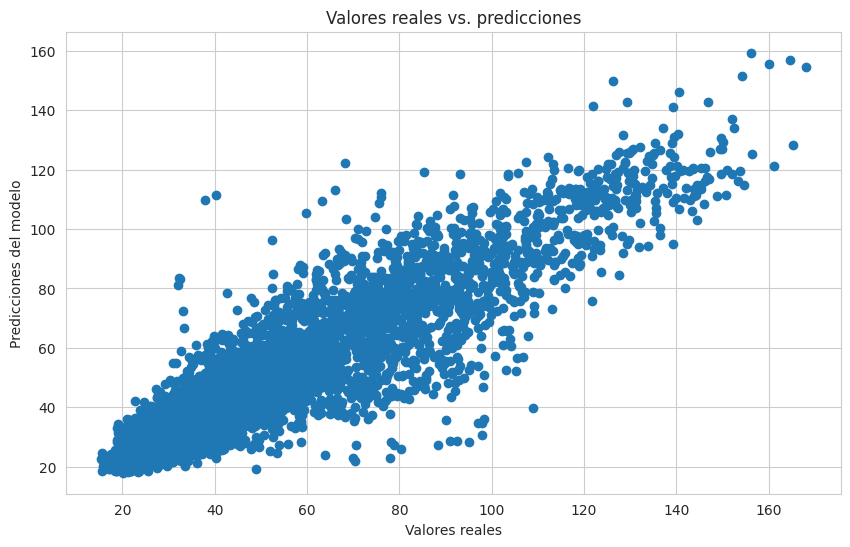

In [143]:
# Visualiza imputacion avanzada con scalert plot si los puntos se alinean a la diagonal estima bien el modelo
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones del modelo")
plt.title("Valores reales vs. predicciones de rf")
plt.grid(True)
plt.show()



# 12 Imputación-Métricas (solo en posiciones NaN. que tan bueno es el imputador?)

Se comparan los valores imputados con los originales pero solo en las posiciones donde se generaron los NaN segun las mascaras generadas.

Se calculan las siguientes métricas:

MAE (valor) - MeaN Absolute Error: Pormedio del valor absoluto de los errores de predicción, indica magnitud del error.

MAPE (%)- Mean Absolute Porcentage: Pormedio del valor absoluto de los errores porcentuales de predicción.

RMSE (valor) -Root Mean Squard Error: Raiz cuadrada de la medias de las diferencias de los valores.

DS (valor) -desviación estándar: Cuantifica la dispersión de un conjunto de datos.


In [144]:
# Se filtran los valores reales con la mascara de valores faltantes

true_vals_patron1_5= df_base.loc[mask_patron1_5, 'kW'].values
true_vals_patron1_10= df_base.loc[mask_patron1_10, 'kW'].values
true_vals_patron1_20= df_base.loc[mask_patron1_20, 'kW'].values
true_vals_patron1_30= df_base.loc[mask_patron1_30, 'kW'].values

true_vals_patron2_5= df_base.loc[mask_patron2_5, 'kW'].values
true_vals_patron2_10= df_base.loc[mask_patron2_10, 'kW'].values
true_vals_patron2_20= df_base.loc[mask_patron2_20, 'kW'].values
true_vals_patron2_30= df_base.loc[mask_patron2_30, 'kW'].values

# Se filtran los valores imputados con la mascara de valores faltantes.
imputed_vals_patron1_5_median= df_patron1_5_imputed_median.loc[mask_patron1_5, 'kW'].values
imputed_vals_patron1_10_median= df_patron1_10_imputed_median.loc[mask_patron1_10, 'kW'].values
imputed_vals_patron1_20_median= df_patron1_20_imputed_median.loc[mask_patron1_20, 'kW'].values
imputed_vals_patron1_30_median= df_patron1_30_imputed_median.loc[mask_patron1_30, 'kW'].values
imputed_vals_patron2_5_median= df_patron2_5_imputed_median.loc[mask_patron2_5, 'kW'].values
imputed_vals_patron2_10_median= df_patron2_10_imputed_median.loc[mask_patron2_10, 'kW'].values
imputed_vals_patron2_20_median= df_patron2_20_imputed_median.loc[mask_patron2_20, 'kW'].values
imputed_vals_patron2_30_median= df_patron2_30_imputed_median.loc[mask_patron2_30, 'kW'].values


imputed_vals_patron1_5_mean= df_patron1_5_imputed_mean.loc[mask_patron1_5, 'kW'].values
imputed_vals_patron1_10_mean= df_patron1_10_imputed_mean.loc[mask_patron1_10, 'kW'].values
imputed_vals_patron1_20_mean= df_patron1_20_imputed_mean.loc[mask_patron1_20, 'kW'].values
imputed_vals_patron1_30_mean= df_patron1_30_imputed_mean.loc[mask_patron1_30, 'kW'].values
imputed_vals_patron2_5_mean= df_patron2_5_imputed_mean.loc[mask_patron2_5, 'kW'].values
imputed_vals_patron2_10_mean= df_patron2_10_imputed_mean.loc[mask_patron2_10, 'kW'].values
imputed_vals_patron2_20_mean= df_patron2_20_imputed_mean.loc[mask_patron2_20, 'kW'].values
imputed_vals_patron2_30_mean= df_patron2_30_imputed_mean.loc[mask_patron2_30, 'kW'].values

imputed_vals_patron1_5_moda= df_patron1_5_imputed_moda.loc[mask_patron1_5, 'kW'].values
imputed_vals_patron1_10_moda= df_patron1_10_imputed_moda.loc[mask_patron1_10, 'kW'].values
imputed_vals_patron1_20_moda= df_patron1_20_imputed_moda.loc[mask_patron1_20, 'kW'].values
imputed_vals_patron1_30_moda= df_patron1_30_imputed_moda.loc[mask_patron1_30, 'kW'].values
imputed_vals_patron2_5_moda= df_patron2_5_imputed_moda.loc[mask_patron2_5, 'kW'].values
imputed_vals_patron2_10_moda= df_patron2_10_imputed_moda.loc[mask_patron2_10, 'kW'].values
imputed_vals_patron2_20_moda= df_patron2_20_imputed_moda.loc[mask_patron2_20, 'kW'].values
imputed_vals_patron2_30_moda= df_patron2_30_imputed_moda.loc[mask_patron2_30, 'kW'].values

imputed_vals_patron1_5_constant= df_patron1_5_imputed_constant.loc[mask_patron1_5, 'kW'].values
imputed_vals_patron1_10_constant= df_patron1_10_imputed_constant.loc[mask_patron1_10, 'kW'].values
imputed_vals_patron1_20_constant= df_patron1_20_imputed_constant.loc[mask_patron1_20, 'kW'].values
imputed_vals_patron1_30_constant= df_patron1_30_imputed_constant.loc[mask_patron1_30, 'kW'].values
imputed_vals_patron2_5_constant= df_patron2_5_imputed_constant.loc[mask_patron2_5, 'kW'].values
imputed_vals_patron2_10_constant= df_patron2_10_imputed_constant.loc[mask_patron2_10, 'kW'].values
imputed_vals_patron2_20_constant= df_patron2_20_imputed_constant.loc[mask_patron2_20, 'kW'].values
imputed_vals_patron2_30_constant= df_patron2_30_imputed_constant.loc[mask_patron2_30, 'kW'].values

imputed_vals_patron1_5_linear= df_patron1_5_imputed_linear.loc[mask_patron1_5, 'kW'].values
imputed_vals_patron1_10_linear= df_patron1_10_imputed_linear.loc[mask_patron1_10, 'kW'].values
imputed_vals_patron1_20_linear= df_patron1_20_imputed_linear.loc[mask_patron1_20, 'kW'].values
imputed_vals_patron1_30_linear= df_patron1_30_imputed_linear.loc[mask_patron1_30, 'kW'].values
imputed_vals_patron2_5_linear= df_patron2_5_imputed_linear.loc[mask_patron2_5, 'kW'].values
imputed_vals_patron2_10_linear= df_patron2_10_imputed_linear.loc[mask_patron2_10, 'kW'].values
imputed_vals_patron2_20_linear= df_patron2_20_imputed_linear.loc[mask_patron2_20, 'kW'].values
imputed_vals_patron2_30_linear= df_patron2_30_imputed_linear.loc[mask_patron2_30, 'kW'].values

imputed_vals_patron1_5_time= df_patron1_5_imputed_time.loc[mask_patron1_5, 'kW'].values
imputed_vals_patron1_10_time= df_patron1_10_imputed_time.loc[mask_patron1_10, 'kW'].values
imputed_vals_patron1_20_time= df_patron1_20_imputed_time.loc[mask_patron1_20, 'kW'].values
imputed_vals_patron1_30_time= df_patron1_30_imputed_time.loc[mask_patron1_30, 'kW'].values
imputed_vals_patron2_5_time= df_patron2_5_imputed_time.loc[mask_patron2_5, 'kW'].values
imputed_vals_patron2_10_time= df_patron2_10_imputed_time.loc[mask_patron2_10, 'kW'].values
imputed_vals_patron2_20_time= df_patron2_20_imputed_time.loc[mask_patron2_20, 'kW'].values
imputed_vals_patron2_30_time= df_patron2_30_imputed_time.loc[mask_patron2_30, 'kW'].values

imputed_vals_patron1_5_locf= df_patron1_5_imputed_locf.loc[mask_patron1_5, 'kW'].values
imputed_vals_patron1_10_locf= df_patron1_10_imputed_locf.loc[mask_patron1_10, 'kW'].values
imputed_vals_patron1_20_locf= df_patron1_20_imputed_locf.loc[mask_patron1_20, 'kW'].values
imputed_vals_patron1_30_locf= df_patron1_30_imputed_locf.loc[mask_patron1_30, 'kW'].values
imputed_vals_patron2_5_locf= df_patron2_5_imputed_locf.loc[mask_patron2_5, 'kW'].values
imputed_vals_patron2_10_locf= df_patron2_10_imputed_locf.loc[mask_patron2_10, 'kW'].values
imputed_vals_patron2_20_locf= df_patron2_20_imputed_locf.loc[mask_patron2_20, 'kW'].values
imputed_vals_patron2_30_locf= df_patron2_30_imputed_locf.loc[mask_patron2_30, 'kW'].values

imputed_vals_patron1_5_knn= df_patron1_5_imputed_knn.loc[mask_patron1_5, 'kW'].values
imputed_vals_patron1_10_knn= df_patron1_10_imputed_knn.loc[mask_patron1_10, 'kW'].values
imputed_vals_patron1_20_knn= df_patron1_20_imputed_knn.loc[mask_patron1_20, 'kW'].values
imputed_vals_patron1_30_knn= df_patron1_30_imputed_knn.loc[mask_patron1_30, 'kW'].values
imputed_vals_patron2_5_knn= df_patron2_5_imputed_knn.loc[mask_patron2_5, 'kW'].values
imputed_vals_patron2_10_knn= df_patron2_10_imputed_knn.loc[mask_patron2_10, 'kW'].values
imputed_vals_patron2_20_knn= df_patron2_20_imputed_knn.loc[mask_patron2_20, 'kW'].values
imputed_vals_patron2_30_knn= df_patron2_30_imputed_knn.loc[mask_patron2_30, 'kW'].values

imputed_vals_patron1_5_rf= df_patron1_5_imputed_rf.loc[mask_patron1_5, 'kW_imputado'].values
imputed_vals_patron1_10_rf= df_patron1_10_imputed_rf.loc[mask_patron1_10, 'kW_imputado'].values
imputed_vals_patron1_20_rf= df_patron1_20_imputed_rf.loc[mask_patron1_20, 'kW_imputado'].values
imputed_vals_patron1_30_rf= df_patron1_30_imputed_rf.loc[mask_patron1_30, 'kW_imputado'].values
imputed_vals_patron2_5_rf= df_patron2_5_imputed_rf.loc[mask_patron2_5, 'kW_imputado'].values
imputed_vals_patron2_10_rf= df_patron2_10_imputed_rf.loc[mask_patron2_10, 'kW_imputado'].values
imputed_vals_patron2_20_rf= df_patron2_20_imputed_rf.loc[mask_patron2_20, 'kW_imputado'].values
imputed_vals_patron2_30_rf= df_patron2_30_imputed_rf.loc[mask_patron2_30, 'kW_imputado'].values



## 12.1 Imputación Simple-Métricas-**Patron1**

In [145]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron1 5%
mae_patron1_5_median = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_median)
print("MAE Patron1 5% Mediana: ", mae_patron1_5_median)
mae_patron1_5_mean = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_mean)
print("MAE Patron1 5% Media: ", mae_patron1_5_mean)
mae_patron1_5_moda = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_moda)
print("MAE Patron1 5% Moda: ", mae_patron1_5_moda)
mae_patron1_5_constant = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_constant)
print("MAE Patron1 5% Constante: ", mae_patron1_5_constant)
mae_patron1_5_linear = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_linear)
print("MAE Patron1 5% Lineal: ", mae_patron1_5_linear)
mae_patron1_5_time = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_time)
print("MAE Patron1 5% Time: ", mae_patron1_5_linear)
mae_patron1_5_locf = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_locf)
print("MAE Patron1 5% LOCF: ", mae_patron1_5_locf)



#MAPE Patron1 5%
mape_patron1_5_median = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_median)
print("MAPE Patron1 5% Mediana: ", mape_patron1_5_median)
mape_patron1_5_mean = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_mean)
print("MAPE Patron1 5% Media: ", mape_patron1_5_mean)
mape_patron1_5_moda = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_moda)
print("MAPE Patron1 5% Moda: ", mape_patron1_5_moda)
mape_patron1_5_constant = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_constant)
print("MAPE Patron1 5% Conatante: ", mape_patron1_5_constant)
mape_patron1_5_linear = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_linear)
print("MAPE Patron1 5% Lineal: ", mape_patron1_5_linear)
mape_patron1_5_time = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_time)
print("MAPE Patron1 5% time: ", mape_patron1_5_time)
mape_patron1_5_locf = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_locf)
print("MAPE Patron1 5% LOCF: ", mape_patron1_5_locf)


#RMSE Patron1 5%
mse_patron1_5_median = mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_median)
rmse_patron1_5_median=np.sqrt(mse_patron1_5_median)
print("RMSE Patron1 5% Mediana: ", rmse_patron1_5_median)
mse_patron1_5_mean = mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_mean)
rmse_patron1_5_mean=np.sqrt(mse_patron1_5_mean)
print("RMSE Patron1 5% Media: ", rmse_patron1_5_mean)
mse_patron1_5_moda = mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_moda)
rmse_patron1_5_moda=np.sqrt(mse_patron1_5_moda)
print("RMSE Patron1 5% Moda: ", rmse_patron1_5_moda)
mse_patron1_5_constant = mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_constant)
rmse_patron1_5_constant=np.sqrt(mse_patron1_5_constant)
print("RMSE Patron1 5% Conatante: ", rmse_patron1_5_constant)
mse_patron1_5_linear = mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_linear)
rmse_patron1_5_linear=np.sqrt(mse_patron1_5_linear)
print("RMSE Patron1 5% Lineal: ", rmse_patron1_5_linear)
mse_patron1_5_time= mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_time)
rmse_patron1_5_time=np.sqrt(mse_patron1_5_time)
print("RMSE Patron1 5% time: ", rmse_patron1_5_time)
mse_patron1_5_locf = mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_locf)
rmse_patron1_5_locf=np.sqrt(mse_patron1_5_locf)
print("RMSE Patron1 5% LOCF: ", rmse_patron1_5_locf)


# DS Patron1 5%
ds_patron1_5_median = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_median)
print("DS Patron1 5% Mediana: ", ds_patron1_5_median)
ds_patron1_5_mean = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_mean)
print("DS Patron1 5% Media: ", ds_patron1_5_mean)
ds_patron1_5_moda = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_moda)
print("DS Patron1 5% Moda: ", ds_patron1_5_moda)
ds_patron1_5_constant = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_constant)
print("DS Patron1 5% Conatante: ", ds_patron1_5_constant)
ds_patron1_5_linear = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_linear)
print("DS Patron1 5% Lineal: ", ds_patron1_5_linear)
ds_patron1_5_time = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_time)
print("DS Patron1 5% time: ", ds_patron1_5_time)
ds_patron1_5_locf = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_locf)
print("DS Patron1 5% LOCF: ", ds_patron1_5_locf)


MAE Patron1 5% Mediana:  15.162259259259258
MAE Patron1 5% Media:  16.414207154942716
MAE Patron1 5% Moda:  17.314351851851853
MAE Patron1 5% Constante:  42.792129629629635
MAE Patron1 5% Lineal:  2.2557106481481477
MAE Patron1 5% Time:  2.2557106481481477
MAE Patron1 5% LOCF:  4.009083333333333
MAPE Patron1 5% Mediana:  0.32512078517408866
MAPE Patron1 5% Media:  0.42584211691991447
MAPE Patron1 5% Moda:  0.3079506165167925
MAPE Patron1 5% Conatante:  1.0
MAPE Patron1 5% Lineal:  0.057871678536553256
MAPE Patron1 5% time:  0.057871678536553256
MAPE Patron1 5% LOCF:  0.09595255574899449
RMSE Patron1 5% Mediana:  22.992700355322114
RMSE Patron1 5% Media:  22.083838357262884
RMSE Patron1 5% Moda:  27.138727380845474
RMSE Patron1 5% Conatante:  48.140699264028456
RMSE Patron1 5% Lineal:  3.178133222885316
RMSE Patron1 5% time:  3.178133222885316
RMSE Patron1 5% LOCF:  6.056051586208196
DS Patron1 5% Mediana:  22.053584003299864
DS Patron1 5% Media:  22.053584003299864
DS Patron1 5% Moda: 

In [146]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron1 10%
mae_patron1_10_median = mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_median)
print("MAE Patron1 10% Mediana: ", mae_patron1_10_median)
mae_patron1_10_mean = mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_mean)
print("MAE Patron1 10% Media: ", mae_patron1_10_mean)
mae_patron1_10_moda = mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_moda)
print("MAE Patron1 10% Moda: ", mae_patron1_10_moda)
mae_patron1_10_constant = mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_constant)
print("MAE Patron1 10% Constante: ", mae_patron1_10_constant)
mae_patron1_10_linear = mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_linear)
print("MAE Patron1 10% Lineal: ", mae_patron1_10_linear)
mae_patron1_10_time = mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_time)
print("MAE Patron1 10% time: ", mae_patron1_10_time)
mae_patron1_10_locf = mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_locf)
print("MAE Patron1 10% LOCF: ", mae_patron1_10_locf)



#MAPE Patron1 10%
mape_patron1_10_median = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_median)
print("MAPE Patron1 10% Mediana: ", mape_patron1_10_median)
mape_patron1_10_mean = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_mean)
print("MAPE Patron1 10% Media: ", mape_patron1_10_mean)
mape_patron1_10_moda = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_moda)
print("MAPE Patron1 10% Moda: ", mape_patron1_10_moda)
mape_patron1_10_constant = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_constant)
print("MAPE Patron1 10% Conatante: ", mape_patron1_10_constant)
mape_patron1_10_linear = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_linear)
print("MAPE Patron1 10% Lineal: ", mape_patron1_10_linear)
mape_patron1_10_time = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_time)
print("MAPE Patron1 10% time: ", mape_patron1_10_time)
mape_patron1_10_locf = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_locf)
print("MAPE Patron1 10% LOCF: ", mape_patron1_10_locf)


#RMSE Patron1 10%
mse_patron1_10_median = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_median)
rmse_patron1_10_median=np.sqrt(mse_patron1_10_median)
print("RMSE Patron1 10% Mediana: ", rmse_patron1_10_median)
mse_patron1_10_mean = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_mean)
rmse_patron1_10_mean=np.sqrt(mse_patron1_10_mean)
print("RMSE Patron1 10% Media: ", rmse_patron1_10_mean)
mse_patron1_10_moda = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_moda)
rmse_patron1_10_moda=np.sqrt(mse_patron1_10_moda)
print("RMSE Patron1 10% Moda: ", rmse_patron1_10_moda)
mse_patron1_10_constant = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_constant)
rmse_patron1_10_constant=np.sqrt(mse_patron1_10_constant)
print("RMSE Patron1 10% Conatante: ", rmse_patron1_10_constant)
mse_patron1_10_linear = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_linear)
rmse_patron1_10_linear=np.sqrt(mse_patron1_10_linear)
print("RMSE Patron1 10% Lineal: ", rmse_patron1_10_linear)
mse_patron1_10_time = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_time)
rmse_patron1_10_time=np.sqrt(mse_patron1_10_time)
print("RMSE Patron1 10% time: ", rmse_patron1_10_time)
mse_patron1_10_locf = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_locf)
rmse_patron1_10_locf=np.sqrt(mse_patron1_10_locf)
print("RMSE Patron1 10% LOCF: ", rmse_patron1_10_locf)


# DS Patron1 10%
ds_patron1_10_median = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_median)
print("DS Patron1 10% Mediana: ", ds_patron1_10_median)
ds_patron1_10_mean = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_mean)
print("DS Patron1 10% Media: ", ds_patron1_10_mean)
ds_patron1_10_moda = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_moda)
print("DS Patron1 10% Moda: ", ds_patron1_10_moda)
ds_patron1_10_constant = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_constant)
print("DS Patron1 10% Conatante: ", ds_patron1_10_constant)
ds_patron1_10_linear = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_linear)
print("DS Patron1 10% Lineal: ", ds_patron1_10_linear)
ds_patron1_10_time = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_time)
print("DS Patron1 10% time: ", ds_patron1_10_time)
ds_patron1_10_locf = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_locf)
print("DS Patron1 10% LOCF: ", ds_patron1_10_locf)




MAE Patron1 10% Mediana:  16.02600811594203
MAE Patron1 10% Media:  17.234835453634457
MAE Patron1 10% Moda:  18.367063188405798
MAE Patron1 10% Constante:  43.9440231884058
MAE Patron1 10% Lineal:  2.3819536231884055
MAE Patron1 10% time:  2.3819536231884055
MAE Patron1 10% LOCF:  4.361293913043478
MAPE Patron1 10% Mediana:  0.32598542944536113
MAPE Patron1 10% Media:  0.4254171546475964
MAPE Patron1 10% Moda:  0.31397838353764246
MAPE Patron1 10% Conatante:  1.0
MAPE Patron1 10% Lineal:  0.05904811345882712
MAPE Patron1 10% time:  0.05904811345882712
MAPE Patron1 10% LOCF:  0.10098225462602725
RMSE Patron1 10% Mediana:  24.640682193454804
RMSE Patron1 10% Media:  23.421187265556984
RMSE Patron1 10% Moda:  28.92165864572276
RMSE Patron1 10% Conatante:  49.795840206593354
RMSE Patron1 10% Lineal:  3.3529581726925985
RMSE Patron1 10% time:  3.352958172692598
RMSE Patron1 10% LOCF:  6.68233934495693
DS Patron1 10% Mediana:  23.42111286633138
DS Patron1 10% Media:  23.42111286633138
DS Pa

In [147]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron1 20%
mae_patron1_20_median = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_median)
print("MAE Patron1 20% Mediana: ", mae_patron1_20_median)
mae_patron1_20_mean = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_mean)
print("MAE Patron1 20% Media: ", mae_patron1_20_mean)
mae_patron1_20_moda = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_moda)
print("MAE Patron1 20% Moda: ", mae_patron1_20_moda)
mae_patron1_20_constant = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_constant)
print("MAE Patron1 20% Constante: ", mae_patron1_20_constant)
mae_patron1_20_linear = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_linear)
print("MAE Patron1 20% Lineal: ", mae_patron1_20_linear)
mae_patron1_20_time = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_time)
print("MAE Patron1 20% time: ", mae_patron1_20_time)
mae_patron1_20_locf = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_locf)
print("MAE Patron1 20% LOCF: ", mae_patron1_20_locf)



#MAPE Patron1 20%
mape_patron1_20_median = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_median)
print("MAPE Patron1 20% Mediana: ", mape_patron1_20_median)
mape_patron1_20_mean = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_mean)
print("MAPE Patron1 20% Media: ", mape_patron1_20_mean)
mape_patron1_20_moda = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_moda)
print("MAPE Patron1 20% Moda: ", mape_patron1_20_moda)
mape_patron1_20_constant = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_constant)
print("MAPE Patron1 20% Conatante: ", mape_patron1_20_constant)
mape_patron1_20_linear = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_linear)
print("MAPE Patron1 20% Lineal: ", mape_patron1_20_linear)
mape_patron1_20_time = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_time)
print("MAPE Patron1 20% time: ", mape_patron1_20_time)
mape_patron1_20_locf = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_locf)
print("MAPE Patron1 20% LOCF: ", mape_patron1_20_locf)


#RMSE Patron1 20%
mse_patron1_20_median = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_median)
rmse_patron1_20_median=np.sqrt(mse_patron1_20_median)
print("RMSE Patron1 20% Mediana: ", rmse_patron1_20_median)
mse_patron1_20_mean = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_mean)
rmse_patron1_20_mean=np.sqrt(mse_patron1_20_mean)
print("RMSE Patron1 20% Media: ", rmse_patron1_20_mean)
mse_patron1_20_moda = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_moda)
rmse_patron1_20_moda=np.sqrt(mse_patron1_20_moda)
print("RMSE Patron1 20% Moda: ", rmse_patron1_20_moda)
mse_patron1_20_constant = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_constant)
rmse_patron1_20_constant=np.sqrt(mse_patron1_20_constant)
print("RMSE Patron1 20% Conatante: ", rmse_patron1_20_constant)
mse_patron1_20_linear = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_linear)
rmse_patron1_20_linear=np.sqrt(mse_patron1_20_linear)
print("RMSE Patron1 20% Lineal: ", rmse_patron1_20_linear)
mse_patron1_20_time = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_time)
rmse_patron1_20_time=np.sqrt(mse_patron1_20_time)
print("RMSE Patron1 20% time: ", rmse_patron1_20_time)
mse_patron1_20_locf = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_locf)
rmse_patron1_20_locf=np.sqrt(mse_patron1_20_locf)
print("RMSE Patron1 20% LOCF: ", rmse_patron1_20_locf)


# DS Patron1 20%
ds_patron1_20_median = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_median)
print("DS Patron1 20% Mediana: ", ds_patron1_20_median)
ds_patron1_20_mean = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_mean)
print("DS Patron1 20% Media: ", ds_patron1_20_mean)
ds_patron1_20_moda = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_moda)
print("DS Patron1 20% Moda: ", ds_patron1_20_moda)
ds_patron1_20_constant = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_constant)
print("DS Patron1 20% Conatante: ", ds_patron1_20_constant)
ds_patron1_20_linear = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_linear)
print("DS Patron1 20% Lineal: ", ds_patron1_20_linear)
ds_patron1_20_time = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_time)
print("DS Patron1 20% time: ", ds_patron1_20_time)
ds_patron1_20_locf = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_locf)
print("DS Patron1 20% LOCF: ", ds_patron1_20_locf)





MAE Patron1 20% Mediana:  15.962917215697507
MAE Patron1 20% Media:  17.18493853763048
MAE Patron1 20% Moda:  18.362513892867376
MAE Patron1 20% Constante:  44.00174620452593
MAE Patron1 20% Lineal:  2.6097518189630478
MAE Patron1 20% time:  2.6097518189630478
MAE Patron1 20% LOCF:  4.833945574334002
MAPE Patron1 20% Mediana:  0.3215358678640522
MAPE Patron1 20% Media:  0.4207060398554418
MAPE Patron1 20% Moda:  0.31255988438186744
MAPE Patron1 20% Conatante:  1.0
MAPE Patron1 20% Lineal:  0.06420937150707333
MAPE Patron1 20% time:  0.06420937150707333
MAPE Patron1 20% LOCF:  0.11033784055784834
RMSE Patron1 20% Mediana:  24.8689166204658
RMSE Patron1 20% Media:  23.627050094902984
RMSE Patron1 20% Moda:  29.12205939752779
RMSE Patron1 20% Conatante:  49.94368807747101
RMSE Patron1 20% Lineal:  3.776368657833313
RMSE Patron1 20% time:  3.776368657833313
RMSE Patron1 20% LOCF:  7.691542060907318
DS Patron1 20% Mediana:  23.626644064111343
DS Patron1 20% Media:  23.626644064111343
DS Pat

In [148]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron1 30%
mae_patron1_30_median = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_median)
print("MAE Patron1 30% Mediana: ", mae_patron1_30_median)
mae_patron1_30_mean = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_mean)
print("MAE Patron1 30% Media: ", mae_patron1_30_mean)
mae_patron1_30_moda = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_moda)
print("MAE Patron1 30% Moda: ", mae_patron1_30_moda)
mae_patron1_30_constant = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_constant)
print("MAE Patron1 30% Constante: ", mae_patron1_30_constant)
mae_patron1_30_linear = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_linear)
print("MAE Patron1 30% Lineal: ", mae_patron1_30_linear)
mae_patron1_30_time = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_time)
print("MAE Patron1 30% time: ", mae_patron1_30_time)
mae_patron1_30_locf = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_locf)
print("MAE Patron1 30% LOCF: ", mae_patron1_30_locf)



#MAPE Patron1 30%
mape_patron1_30_median = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_median)
print("MAPE Patron1 30% Mediana: ", mape_patron1_30_median)
mape_patron1_30_mean = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_mean)
print("MAPE Patron1 30% Media: ", mape_patron1_30_mean)
mape_patron1_30_moda = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_moda)
print("MAPE Patron1 30% Moda: ", mape_patron1_30_moda)
mape_patron1_30_constant = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_constant)
print("MAPE Patron1 30% Conatante: ", mape_patron1_30_constant)
mape_patron1_30_linear = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_linear)
print("MAPE Patron1 30% Lineal: ", mape_patron1_30_linear)
mape_patron1_30_time = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_time)
print("MAPE Patron1 30% time: ", mape_patron1_30_time)
mape_patron1_30_locf = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_locf)
print("MAPE Patron1 30% LOCF: ", mape_patron1_30_locf)




#RMSE Patron1 30%
mse_patron1_30_median = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_median)
rmse_patron1_30_median=np.sqrt(mse_patron1_30_median)
print("RMSE Patron1 30% Mediana: ", rmse_patron1_30_median)
mse_patron1_30_mean = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_mean)
rmse_patron1_30_mean=np.sqrt(mse_patron1_30_mean)
print("RMSE Patron1 30% Media: ", rmse_patron1_30_mean)
mse_patron1_30_moda = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_moda)
rmse_patron1_30_moda=np.sqrt(mse_patron1_30_moda)
print("RMSE Patron1 30% Moda: ", rmse_patron1_30_moda)
mse_patron1_30_constant = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_constant)
rmse_patron1_30_constant=np.sqrt(mse_patron1_30_constant)
print("RMSE Patron1 30% Conatante: ", rmse_patron1_30_constant)
mse_patron1_30_linear = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_linear)
rmse_patron1_30_linear=np.sqrt(mse_patron1_30_linear)
print("RMSE Patron1 30% Lineal: ", rmse_patron1_30_linear)
mse_patron1_30_time = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_time)
rmse_patron1_30_time=np.sqrt(mse_patron1_30_time)
print("RMSE Patron1 30% time: ", rmse_patron1_30_time)
mse_patron1_30_locf = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_locf)
rmse_patron1_30_locf=np.sqrt(mse_patron1_30_locf)
print("RMSE Patron1 30% LOCF: ", rmse_patron1_30_locf)

# DS Patron1 30%
ds_patron1_30_median = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_median)
print("DS Patron1 30% Mediana: ", ds_patron1_30_median)
ds_patron1_30_mean = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_mean)
print("DS Patron1 30% Media: ", ds_patron1_30_mean)
ds_patron1_30_moda = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_moda)
print("DS Patron1 30% Moda: ", ds_patron1_30_moda)
ds_patron1_30_constant = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_constant)
print("DS Patron1 30% Conatante: ", ds_patron1_30_constant)
ds_patron1_30_linear = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_linear)
print("DS Patron1 30% Lineal: ", ds_patron1_30_linear)
ds_patron1_30_time = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_time)
print("DS Patron1 30% time: ", ds_patron1_30_time)
ds_patron1_30_locf = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_locf)
print("DS Patron1 30% LOCF: ", ds_patron1_30_locf)



MAE Patron1 30% Mediana:  16.01084374413806
MAE Patron1 30% Media:  17.2702300414132
MAE Patron1 30% Moda:  17.390379290939784
MAE Patron1 30% Constante:  44.004135809416624
MAE Patron1 30% Lineal:  2.9136854338058615
MAE Patron1 30% time:  2.9136854338058615
MAE Patron1 30% LOCF:  5.3059193397111235
MAPE Patron1 30% Mediana:  0.3233453617220393
MAPE Patron1 30% Media:  0.42274344973662387
MAPE Patron1 30% Moda:  0.29876354478705747
MAPE Patron1 30% Conatante:  1.0
MAPE Patron1 30% Lineal:  0.0708493669774141
MAPE Patron1 30% time:  0.0708493669774141
MAPE Patron1 30% LOCF:  0.12013852814917352
RMSE Patron1 30% Mediana:  24.803464823768635
RMSE Patron1 30% Media:  23.588939562041293
RMSE Patron1 30% Moda:  27.986054582065393
RMSE Patron1 30% Conatante:  49.927703019524664
RMSE Patron1 30% Lineal:  4.33117674989503
RMSE Patron1 30% time:  4.33117674989503
RMSE Patron1 30% LOCF:  8.512688945537363
DS Patron1 30% Mediana:  23.588377656639942
DS Patron1 30% Media:  23.588377656639942
DS Pa

## 12.2 Imputación Simple-Métricas-**Patron2**

In [149]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron2 5%
mae_patron2_5_median = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_median)
print("MAE Patron2 5% Mediana: ", mae_patron2_5_median)
mae_patron2_5_mean = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_mean)
print("MAE Patron2 5% Media: ", mae_patron2_5_mean)
mae_patron2_5_moda = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_moda)
print("MAE Patron2 5% Moda: ", mae_patron2_5_moda)
mae_patron2_5_constant = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_constant)
print("MAE Patron2 5% Constante: ", mae_patron2_5_constant)
mae_patron2_5_linear = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_linear)
print("MAE Patron2 5% Lineal: ", mae_patron2_5_linear)
mae_patron2_5_time = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_time)
print("MAE Patron2 5% time: ", mae_patron2_5_time)
mae_patron2_5_locf = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_locf)
print("MAE Patron2 5% LOCF: ", mae_patron2_5_locf)


#MAPE Patron2 5%
mape_patron2_5_median = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_median)
print("MAPE Patron2 5% Mediana: ", mape_patron2_5_median)
mape_patron2_5_mean = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_mean)
print("MAPE Patron2 5% Media: ", mape_patron2_5_mean)
mape_patron2_5_moda = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_moda)
print("MAPE Patron2 5% Moda: ", mape_patron2_5_moda)
mape_patron2_5_constant = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_constant)
print("MAPE Patron2 5% Conatante: ", mape_patron2_5_constant)
mape_patron2_5_linear = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_linear)
print("MAPE Patron2 5% Lineal: ", mape_patron2_5_linear)
mape_patron2_5_time = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_time)
print("MAPE Patron2 5% time: ", mape_patron2_5_time)
mape_patron2_5_locf = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_locf)
print("MAPE Patron2 5% LOCF: ", mape_patron2_5_locf)

#RMSE Patron2 5%
mse_patron2_5_median = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_median)
rmse_patron2_5_median=np.sqrt(mse_patron2_5_median)
print("RMSE Patron2 5% Mediana: ", rmse_patron2_5_median)
mse_patron2_5_mean = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_mean)
rmse_patron2_5_mean=np.sqrt(mse_patron2_5_mean)
print("RMSE Patron2 5% Media: ", rmse_patron2_5_mean)
mse_patron2_5_moda = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_moda)
rmse_patron2_5_moda=np.sqrt(mse_patron2_5_moda)
print("RMSE Patron2 5% Moda: ", rmse_patron2_5_moda)
mse_patron2_5_constant = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_constant)
rmse_patron2_5_constant=np.sqrt(mse_patron2_5_constant)
print("RMSE Patron2 5% Conatante: ", rmse_patron2_5_constant)
mse_patron2_5_linear = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_linear)
rmse_patron2_5_linear=np.sqrt(mse_patron2_5_linear)
print("RMSE Patron2 5% Lineal: ", rmse_patron2_5_linear)
mse_patron2_5_time = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_time)
rmse_patron2_5_time=np.sqrt(mse_patron2_5_time)
print("RMSE Patron2 5% time: ", rmse_patron2_5_time)
mse_patron2_5_locf = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_locf)
rmse_patron2_5_locf=np.sqrt(mse_patron2_5_locf)
print("RMSE Patron2 5% LOCF: ", rmse_patron2_5_locf)

# DS Patron2 5%
ds_patron2_5_median = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_median)
print("DS Patron2 5% Mediana: ", ds_patron2_5_median)
ds_patron2_5_mean = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_mean)
print("DS Patron2 5% Media: ", ds_patron2_5_mean)
ds_patron2_5_moda = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_moda)
print("DS Patron2 5% Moda: ", ds_patron2_5_moda)
ds_patron2_5_constant = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_constant)
print("DS Patron2 5% Conatante: ", ds_patron2_5_constant)
ds_patron2_5_linear = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_linear)
print("DS Patron2 5% Lineal: ", ds_patron2_5_linear)
ds_patron2_5_time = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_time)
print("DS Patron2 5% time: ", ds_patron2_5_time)
ds_patron2_5_locf = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_locf)
print("DS Patron2 5% LOCF: ", ds_patron2_5_locf)


MAE Patron2 5% Mediana:  40.47509104820199
MAE Patron2 5% Media:  36.70939644729732
MAE Patron2 5% Moda:  46.58503442999235
MAE Patron2 5% Constante:  73.06538944146902
MAE Patron2 5% Lineal:  5.751831894196086
MAE Patron2 5% time:  5.751831894196086
MAE Patron2 5% LOCF:  9.047449120122417
MAPE Patron2 5% Mediana:  0.4613077375636785
MAPE Patron2 5% Media:  0.4367631750663842
MAPE Patron2 5% Moda:  0.5293144591453581
MAPE Patron2 5% Conatante:  1.0
MAPE Patron2 5% Lineal:  0.06918243709599424
MAPE Patron2 5% time:  0.06918243709599424
MAPE Patron2 5% LOCF:  0.11234406331522966
RMSE Patron2 5% Mediana:  52.45765521375184
RMSE Patron2 5% Media:  48.06772382627301
RMSE Patron2 5% Moda:  58.66035921809567
RMSE Patron2 5% Conatante:  81.58037177374321
RMSE Patron2 5% Lineal:  10.475941745147358
RMSE Patron2 5% time:  10.475941745147356
RMSE Patron2 5% LOCF:  14.938282785461784
DS Patron2 5% Mediana:  36.287820608416624
DS Patron2 5% Media:  36.28782060841662
DS Patron2 5% Moda:  36.28782060

In [150]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron2 10%
mae_patron2_10_median = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_median)
print("MAE Patron2 10% Mediana: ", mae_patron2_10_median)
mae_patron2_10_mean = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_mean)
print("MAE Patron2 10% Media: ", mae_patron2_10_mean)
mae_patron2_10_moda = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_moda)
print("MAE Patron2 10% Moda: ", mae_patron2_10_moda)
mae_patron2_10_constant = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_constant)
print("MAE Patron2 10% Constante: ", mae_patron2_10_constant)
mae_patron2_10_linear = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_linear)
print("MAE Patron2 10% Lineal: ", mae_patron2_10_linear)
mae_patron2_10_time = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_time)
print("MAE Patron2 10% time: ", mae_patron2_10_time)
mae_patron2_10_locf = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_locf)
print("MAE Patron2 10% LOCF: ", mae_patron2_10_locf)


#MAPE Patron2 10%
mape_patron2_10_median = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_median)
print("MAPE Patron2 10% Mediana: ", mape_patron2_10_median)
mape_patron2_10_mean = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_mean)
print("MAPE Patron2 10% Media: ", mape_patron2_10_mean)
mape_patron2_10_moda = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_moda)
print("MAPE Patron2 10% Moda: ", mape_patron2_10_moda)
mape_patron2_10_constant = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_constant)
print("MAPE Patron2 10% Conatante: ", mape_patron2_10_constant)
mape_patron2_10_linear = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_linear)
print("MAPE Patron2 10% Lineal: ", mape_patron2_10_linear)
mape_patron2_10_time = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_time)
print("MAPE Patron2 10% time: ", mape_patron2_10_time)
mape_patron2_10_locf = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_locf)
print("MAPE Patron2 10% LOCF: ", mape_patron2_10_locf)


#RMSE Patron2 10%
mse_patron2_10_median = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_median)
rmse_patron2_10_median=np.sqrt(mse_patron2_10_median)
print("RMSE Patron2 10% Mediana: ", rmse_patron2_10_median)
mse_patron2_10_mean = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_mean)
rmse_patron2_10_mean=np.sqrt(mse_patron2_10_mean)
print("RMSE Patron2 10% Media: ", rmse_patron2_10_mean)
mse_patron2_10_moda = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_moda)
rmse_patron2_10_moda=np.sqrt(mse_patron2_10_moda)
print("RMSE Patron2 10% Moda: ", rmse_patron2_10_moda)
mse_patron2_10_constant = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_constant)
rmse_patron2_10_constant=np.sqrt(mse_patron2_10_constant)
print("RMSE Patron2 10% Conatante: ", rmse_patron2_10_constant)
mse_patron2_10_linear = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_linear)
rmse_patron2_10_linear=np.sqrt(mse_patron2_10_linear)
print("RMSE Patron2 10% Lineal: ", rmse_patron2_10_linear)
mse_patron2_10_time = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_time)
rmse_patron2_10_time=np.sqrt(mse_patron2_10_time)
print("RMSE Patron2 10% time: ", rmse_patron2_10_time)
mse_patron2_10_locf = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_locf)
rmse_patron2_10_locf=np.sqrt(mse_patron2_10_locf)
print("RMSE Patron2 10% LOCF: ", rmse_patron2_10_locf)


#DS Patron2 10%
ds_patron2_10_median = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_median)
print("DS Patron2 10% Mediana: ", ds_patron2_10_median)
ds_patron2_10_mean = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_mean)
print("DS Patron2 10% Media: ", ds_patron2_10_mean)
ds_patron2_10_moda = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_moda)
print("DS Patron2 10% Moda: ", ds_patron2_10_moda)
ds_patron2_10_constant = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_constant)
print("DS Patron2 10% Conatante: ", ds_patron2_10_constant)
ds_patron2_10_linear = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_linear)
print("DS Patron2 10% Lineal: ", ds_patron2_10_linear)
ds_patron2_10_time = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_time)
print("DS Patron2 10% time: ", ds_patron2_10_time)
ds_patron2_10_locf = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_locf)
print("DS Patron2 10% LOCF: ", ds_patron2_10_locf)


MAE Patron2 10% Mediana:  37.78769720241361
MAE Patron2 10% Media:  34.27829358950261
MAE Patron2 10% Moda:  43.59033680746023
MAE Patron2 10% Constante:  70.09492046077894
MAE Patron2 10% Lineal:  5.9155779954549015
MAE Patron2 10% time:  5.9155779954549015
MAE Patron2 10% LOCF:  9.37858475041141
MAPE Patron2 10% Mediana:  0.4440786520048036
MAPE Patron2 10% Media:  0.4197765813540268
MAPE Patron2 10% Moda:  0.5130822237440059
MAPE Patron2 10% Conatante:  1.0
MAPE Patron2 10% Lineal:  0.07317685001451471
MAPE Patron2 10% time:  0.07317685001451471
MAPE Patron2 10% LOCF:  0.11992500238592302
RMSE Patron2 10% Mediana:  49.76296480426791
RMSE Patron2 10% Media:  45.660838818732636
RMSE Patron2 10% Moda:  55.578910887044344
RMSE Patron2 10% Conatante:  78.37775135897917
RMSE Patron2 10% Lineal:  10.875491904547602
RMSE Patron2 10% time:  10.875491904547602
RMSE Patron2 10% LOCF:  15.786860858417292
DS Patron2 10% Mediana:  35.06813416318348
DS Patron2 10% Media:  35.06813416318348
DS Patr

In [151]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron2 20%
mae_patron2_20_median = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_median)
print("MAE Patron2 20% Mediana: ", mae_patron2_20_median)
mae_patron2_20_mean = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_mean)
print("MAE Patron2 20% Media: ", mae_patron2_20_mean)
mae_patron2_20_moda = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_moda)
print("MAE Patron2 20% Moda: ", mae_patron2_20_moda)
mae_patron2_20_constant = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_constant)
print("MAE Patron2 20% Constante: ", mae_patron2_20_constant)
mae_patron2_20_linear = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_linear)
print("MAE Patron2 20% Lineal: ", mae_patron2_20_linear)
mae_patron2_20_time = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_time)
print("MAE Patron2 20% time: ", mae_patron2_20_time)
mae_patron2_20_locf = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_locf)
print("MAE Patron2 20% LOCF: ", mae_patron2_20_locf)



#MAPE Patron2 20%
mape_patron2_20_median = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_median)
print("MAPE Patron2 20% Mediana: ", mape_patron2_20_median)
mape_patron2_20_mean = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_mean)
print("MAPE Patron2 20% Media: ", mape_patron2_20_mean)
mape_patron2_20_moda = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_moda)
print("MAPE Patron2 20% Moda: ", mape_patron2_20_moda)
mape_patron2_20_constant = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_constant)
print("MAPE Patron2 20% Conatante: ", mape_patron2_20_constant)
mape_patron2_20_linear = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_linear)
print("MAPE Patron2 20% Lineal: ", mape_patron2_20_linear)
mape_patron2_20_time = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_time)
print("MAPE Patron2 20% time: ", mape_patron2_20_time)
mape_patron2_20_locf = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_locf)
print("MAPE Patron2 20% LOCF: ", mape_patron2_20_locf)


#RMSE Patron2 20%
mse_patron2_20_median = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_median)
rmse_patron2_20_median=np.sqrt(mse_patron2_20_median)
print("RMSE Patron2 20% Mediana: ", rmse_patron2_20_median)
mse_patron2_20_mean = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_mean)
rmse_patron2_20_mean=np.sqrt(mse_patron2_20_mean)
print("RMSE Patron2 20% Media: ", rmse_patron2_20_mean)
mse_patron2_20_moda = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_moda)
rmse_patron2_20_moda=np.sqrt(mse_patron2_20_moda)
print("RMSE Patron2 20% Moda: ", rmse_patron2_20_moda)
mse_patron2_20_constant = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_constant)
rmse_patron2_20_constant=np.sqrt(mse_patron2_20_constant)
print("RMSE Patron2 20% Conatante: ", rmse_patron2_20_constant)
mse_patron2_20_linear = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_linear)
rmse_patron2_20_linear=np.sqrt(mse_patron2_20_linear)
print("RMSE Patron2 20% Lineal: ", rmse_patron2_20_linear)
mse_patron2_20_time = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_time)
rmse_patron2_20_time=np.sqrt(mse_patron2_20_time)
print("RMSE Patron2 20% time: ", rmse_patron2_20_time)
mse_patron2_20_locf = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_locf)
rmse_patron2_20_locf=np.sqrt(mse_patron2_20_locf)
print("RMSE Patron2 20% LOCF: ", rmse_patron2_20_locf)


# DS Patron2 20%
ds_patron2_20_median = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_median)
print("DS Patron2 20% Mediana: ", ds_patron2_20_median)
ds_patron2_20_mean = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_mean)
print("DS Patron2 20% Media: ", ds_patron2_20_mean)
ds_patron2_20_moda = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_moda)
print("DS Patron2 20% Moda: ", ds_patron2_20_moda)
ds_patron2_20_constant = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_constant)
print("DS Patron2 20% Conatante: ", ds_patron2_20_constant)
ds_patron2_20_linear = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_linear)
print("DS Patron2 20% Lineal: ", ds_patron2_20_linear)
ds_patron2_20_time = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_time)
print("DS Patron2 20% time: ", ds_patron2_20_time)
ds_patron2_20_locf = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_locf)
print("DS Patron2 20% LOCF: ", ds_patron2_20_locf)


MAE Patron2 20% Mediana:  31.993824479013792
MAE Patron2 20% Media:  29.21496549335584
MAE Patron2 20% Moda:  36.8007795714705
MAE Patron2 20% Constante:  63.203710008805395
MAE Patron2 20% Lineal:  6.615557857072973
MAE Patron2 20% time:  6.615557857072973
MAE Patron2 20% LOCF:  10.080051658350454
MAPE Patron2 20% Mediana:  0.4108849319750333
MAPE Patron2 20% Media:  0.39314425980031026
MAPE Patron2 20% Moda:  0.4707237361196477
MAPE Patron2 20% Conatante:  1.0
MAPE Patron2 20% Lineal:  0.0854422222460772
MAPE Patron2 20% time:  0.0854422222460772
MAPE Patron2 20% LOCF:  0.13711486362448386
RMSE Patron2 20% Mediana:  43.75483603065231
RMSE Patron2 20% Media:  40.36714736014417
RMSE Patron2 20% Moda:  48.65718647056152
RMSE Patron2 20% Conatante:  71.06183069430497
RMSE Patron2 20% Lineal:  12.892207474243252
RMSE Patron2 20% time:  12.892207474243252
RMSE Patron2 20% LOCF:  17.4485753579739
DS Patron2 20% Mediana:  32.481915318356705
DS Patron2 20% Media:  32.481915318356705
DS Patron

In [152]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron2 30%
mae_patron2_30_median = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_median)
print("MAE Patron2 30% Mediana: ", mae_patron2_30_median)
mae_patron2_30_mean = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_mean)
print("MAE Patron2 30% Media: ", mae_patron2_30_mean)
mae_patron2_30_moda = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_moda)
print("MAE Patron2 30% Moda: ", mae_patron2_30_moda)
mae_patron2_30_constant = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_constant)
print("MAE Patron2 30% Constante: ", mae_patron2_30_constant)
mae_patron2_30_linear = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_linear)
print("MAE Patron2 30% Lineal: ", mae_patron2_30_linear)
mae_patron2_30_time = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_time)
print("MAE Patron2 30% time: ", mae_patron2_30_time)
mae_patron2_30_locf = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_locf)
print("MAE Patron2 30% LOCF: ", mae_patron2_30_locf)



#MAPE Patron2 30%
mape_patron2_30_median = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_median)
print("MAPE Patron2 30% Mediana: ", mape_patron2_30_median)
mape_patron2_30_mean = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_mean)
print("MAPE Patron2 30% Media: ", mape_patron2_30_mean)
mape_patron2_30_moda = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_moda)
print("MAPE Patron2 30% Moda: ", mape_patron2_30_moda)
mape_patron2_30_constant = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_constant)
print("MAPE Patron2 30% Conatante: ", mape_patron2_30_constant)
mape_patron2_30_linear = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_linear)
print("MAPE Patron2 30% Lineal: ", mape_patron2_30_linear)
mape_patron2_30_time = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_time)
print("MAPE Patron2 30% time: ", mape_patron2_30_time)
mape_patron2_30_locf = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_locf)
print("MAPE Patron2 30% LOCF: ", mape_patron2_30_locf)


#RMSE Patron2 30%
mse_patron2_30_median = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_median)
rmse_patron2_30_median=np.sqrt(mse_patron2_30_median)
print("RMSE Patron2 30% Mediana: ", rmse_patron2_30_median)
mse_patron2_30_mean = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_mean)
rmse_patron2_30_mean=np.sqrt(mse_patron2_30_mean)
print("RMSE Patron2 30% Media: ", rmse_patron2_30_mean)
mse_patron2_30_moda = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_moda)
rmse_patron2_30_moda=np.sqrt(mse_patron2_30_moda)
print("RMSE Patron2 30% Moda: ", rmse_patron2_30_moda)
mse_patron2_30_constant = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_constant)
rmse_patron2_30_constant=np.sqrt(mse_patron2_30_constant)
print("RMSE Patron2 30% Conatante: ", rmse_patron2_30_constant)
mse_patron2_30_linear = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_linear)
rmse_patron2_30_linear=np.sqrt(mse_patron2_30_linear)
print("RMSE Patron2 30% Lineal: ", rmse_patron2_30_linear)
mse_patron2_30_time = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_time)
rmse_patron2_30_time=np.sqrt(mse_patron2_30_time)
print("RMSE Patron2 30% time: ", rmse_patron2_30_time)
mse_patron2_30_locf = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_locf)
rmse_patron2_30_locf=np.sqrt(mse_patron2_30_locf)
print("RMSE Patron2 30% LOCF: ", rmse_patron2_30_locf)

# DS Patron2 30%
ds_patron2_30_median = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_median)
print("DS Patron2 30% Mediana: ", ds_patron2_30_median)
ds_patron2_30_mean = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_mean)
print("DS Patron2 30% Media: ", ds_patron2_30_mean)
ds_patron2_30_moda = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_moda)
print("DS Patron2 30% Moda: ", ds_patron2_30_moda)
ds_patron2_30_constant = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_constant)
print("DS Patron2 30% Conatante: ", ds_patron2_30_constant)
ds_patron2_30_linear = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_linear)
print("DS Patron2 30% Lineal: ", ds_patron2_30_linear)
ds_patron2_30_time = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_time)
print("DS Patron2 30% time: ", ds_patron2_30_time)
ds_patron2_30_locf = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_locf)
print("DS Patron2 30% LOCF: ", ds_patron2_30_locf)



MAE Patron2 30% Mediana:  28.47061444114738
MAE Patron2 30% Media:  26.11425032771153
MAE Patron2 30% Moda:  32.48421839762611
MAE Patron2 30% Constante:  58.83993115727002
MAE Patron2 30% Lineal:  7.337524386487235
MAE Patron2 30% time:  7.337524386487235
MAE Patron2 30% LOCF:  10.715780019782393
MAPE Patron2 30% Mediana:  0.3872870901220922
MAPE Patron2 30% Media:  0.372454615332676
MAPE Patron2 30% Moda:  0.43996528165566406
MAPE Patron2 30% Conatante:  1.0
MAPE Patron2 30% Lineal:  0.09795842649815435
MAPE Patron2 30% time:  0.09795842649815435
MAPE Patron2 30% LOCF:  0.1514839876322891
RMSE Patron2 30% Mediana:  40.04929433300062
RMSE Patron2 30% Media:  37.09445472081032
RMSE Patron2 30% Moda:  44.162349920023004
RMSE Patron2 30% Conatante:  66.3109383153005
RMSE Patron2 30% Lineal:  14.598337034645967
RMSE Patron2 30% time:  14.598337034645967
RMSE Patron2 30% LOCF:  18.946826785129936
DS Patron2 30% Mediana:  30.57781943931437
DS Patron2 30% Media:  30.57781943931438
DS Patron2

## 12.3 Imputación Avanzada-Métricas-**Patron1**

In [153]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron1
mae_patron1_5_knn = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_knn)
print("MAE Patron1 5% KNN: ", mae_patron1_5_knn)
mae_patron1_5_rf = mean_absolute_error(true_vals_patron1_5,imputed_vals_patron1_5_rf)
print("MAE Patron1 5% RF: ", mae_patron1_5_rf)
mae_patron1_10_knn = mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_knn)
print("MAE Patron1 10% KNN: ", mae_patron1_10_knn)
mae_patron1_10_rf= mean_absolute_error(true_vals_patron1_10,imputed_vals_patron1_10_rf)
print("MAE Patron1 10% RF: ", mae_patron1_10_rf)
mae_patron1_20_knn = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_knn)
print("MAE Patron1 20% KNN: ", mae_patron1_20_knn)
mae_patron1_20_rf = mean_absolute_error(true_vals_patron1_20,imputed_vals_patron1_20_rf)
print("MAE Patron1 20% RF: ", mae_patron1_20_rf)
mae_patron1_30_knn = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_knn)
print("MAE Patron1 30% KNN: ", mae_patron1_30_knn)
mae_patron1_30_rf = mean_absolute_error(true_vals_patron1_30,imputed_vals_patron1_30_rf)
print("MAE Patron1 30% RF: ", mae_patron1_30_rf)


#MAPE Patron1
mape_patron1_5_knn = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_knn)
print("MAPE Patron1 5% KNN: ", mape_patron1_5_knn)
mape_patron1_5_rf = mean_absolute_percentage_error(true_vals_patron1_5,imputed_vals_patron1_5_rf)
print("MAPE Patron1 5% RF: ", mape_patron1_5_rf)
mape_patron1_10_knn = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_knn)
print("MAPE Patron1 10% KNN: ", mape_patron1_10_knn)
mape_patron1_10_rf = mean_absolute_percentage_error(true_vals_patron1_10,imputed_vals_patron1_10_rf)
print("MAPE Patron1 10% RF: ", mape_patron1_10_rf)
mape_patron1_20_knn = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_knn)
print("MAPE Patron1 20% KNN: ", mape_patron1_20_knn)
mape_patron1_20_rf = mean_absolute_percentage_error(true_vals_patron1_20,imputed_vals_patron1_20_rf)
print("MAPE Patron1 20% RF: ", mape_patron1_20_rf)
mape_patron1_30_knn = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_knn)
print("MAPE Patron1 30% KNN: ", mape_patron1_30_knn)
mape_patron1_30_rf = mean_absolute_percentage_error(true_vals_patron1_30,imputed_vals_patron1_30_rf)
print("MAPE Patron1 30% RF: ", mape_patron1_30_rf)


#RMSE Patron1
mse_patron1_5_knn = mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_knn)
rmse_patron1_5_knn=np.sqrt(mse_patron1_5_knn)
print("RMSE Patron1 5% KNN: ", rmse_patron1_5_knn)
mse_patron1_5_rf = mean_squared_error(true_vals_patron1_5,imputed_vals_patron1_5_rf)
rmse_patron1_5_rf=np.sqrt(mse_patron1_5_rf)
print("RMSE Patron1 5% RF: ", rmse_patron1_5_rf)

mse_patron1_10_knn = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_knn)
rmse_patron1_10_knn=np.sqrt(mse_patron1_10_knn)
print("RMSE Patron1 10% KNN: ", rmse_patron1_10_knn)
mse_patron1_10_rf = mean_squared_error(true_vals_patron1_10,imputed_vals_patron1_10_rf)
rmse_patron1_10_rf=np.sqrt(mse_patron1_10_rf)
print("RMSE Patron1 10% RF: ", rmse_patron1_10_rf)


mse_patron1_20_knn = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_knn)
rmse_patron1_20_knn=np.sqrt(mse_patron1_20_knn)
print("RMSE Patron1 20% KNN: ", rmse_patron1_20_knn)
mse_patron1_20_rf = mean_squared_error(true_vals_patron1_20,imputed_vals_patron1_20_rf)
rmse_patron1_20_rf=np.sqrt(mse_patron1_20_rf)
print("RMSE Patron1 20% RF: ", rmse_patron1_20_rf)

mse_patron1_30_knn = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_knn)
rmse_patron1_30_knn=np.sqrt(mse_patron1_30_knn)
print("RMSE Patron1 30% KNN: ", rmse_patron1_30_knn)
mse_patron1_30_rf = mean_squared_error(true_vals_patron1_30,imputed_vals_patron1_30_rf)
rmse_patron1_30_rf=np.sqrt(mse_patron1_30_rf)
print("RMSE Patron1 30% RF: ", rmse_patron1_30_rf)

# DS Patron1
ds_patron1_5_knn = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_knn)
print("DS Patron1 5% KNN: ", ds_patron1_5_knn)
ds_patron1_5_rf = np.std(true_vals_patron1_5 - imputed_vals_patron1_5_rf)
print("DS Patron1 5% RF: ", ds_patron1_5_rf)

ds_patron1_10_knn = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_knn)
print("DS Patron1 10% KNN: ", ds_patron1_10_knn)
ds_patron1_10_rf = np.std(true_vals_patron1_10 - imputed_vals_patron1_10_rf)
print("DS Patron1 10% RF: ", ds_patron1_10_rf)

ds_patron1_20_knn = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_knn)
print("DS Patron1 20% KNN: ", ds_patron1_20_knn)
ds_patron1_20_rf = np.std(true_vals_patron1_20 - imputed_vals_patron1_20_rf)
print("DS Patron1 20% RF: ", ds_patron1_20_rf)

ds_patron1_30_knn = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_knn)
print("DS Patron1 30% KNN: ", ds_patron1_30_knn)
ds_patron1_30_rf = np.std(true_vals_patron1_30 - imputed_vals_patron1_30_rf)
print("DS Patron1 30% RF: ", ds_patron1_30_rf)


MAE Patron1 5% KNN:  5.562865841280967
MAE Patron1 5% RF:  3.99370580812089
MAE Patron1 10% KNN:  5.700083226801052
MAE Patron1 10% RF:  4.105919669690695
MAE Patron1 20% KNN:  5.719010552910142
MAE Patron1 20% RF:  4.075228505661435
MAE Patron1 30% KNN:  5.809749575853595
MAE Patron1 30% RF:  4.073049901474751
MAPE Patron1 5% KNN:  0.12943472664837352
MAPE Patron1 5% RF:  0.0904912198302905
MAPE Patron1 10% KNN:  0.12896602020018824
MAPE Patron1 10% RF:  0.089772984627437
MAPE Patron1 20% KNN:  0.12961795219408867
MAPE Patron1 20% RF:  0.088745764291498
MAPE Patron1 30% KNN:  0.13091309532475523
MAPE Patron1 30% RF:  0.0892702962587205
RMSE Patron1 5% KNN:  8.738575615458492
RMSE Patron1 5% RF:  6.884606731973517
RMSE Patron1 10% KNN:  9.056850569437778
RMSE Patron1 10% RF:  7.183841600086878
RMSE Patron1 20% KNN:  8.94566499283674
RMSE Patron1 20% RF:  7.219805530931081
RMSE Patron1 30% KNN:  9.09960259132357
RMSE Patron1 30% RF:  7.120466854868781
DS Patron1 5% KNN:  8.7312013644268

## 12.4 Imputación Avanzada-Métricas-**Patron2**

In [154]:
#Se calculan las métricas MAE,MAPE,RMSE,DS

#MAE Patron2
mae_patron2_5_knn = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_knn)
print("MAE Patron2 5% KNN: ", mae_patron2_5_knn)
mae_patron2_5_rf = mean_absolute_error(true_vals_patron2_5,imputed_vals_patron2_5_rf)
print("MAE Patron2 5% RF: ", mae_patron2_5_rf)
mae_patron2_10_knn = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_knn)
print("MAE Patron2 10% KNN: ", mae_patron2_10_knn)
mae_patron2_10_rf = mean_absolute_error(true_vals_patron2_10,imputed_vals_patron2_10_rf)
print("MAE Patron2 10% RF: ", mae_patron2_10_rf)
mae_patron2_20_knn = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_knn)
print("MAE Patron2 20% KNN: ", mae_patron2_20_knn)
mae_patron2_20_rf = mean_absolute_error(true_vals_patron2_20,imputed_vals_patron2_20_rf)
print("MAE Patron2 20% RF: ", mae_patron2_20_rf)
mae_patron2_30_knn = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_knn)
print("MAE Patron2 30% KNN: ", mae_patron2_30_knn)
mae_patron2_30_rf = mean_absolute_error(true_vals_patron2_30,imputed_vals_patron2_30_rf)
print("MAE Patron2 30% RF: ", mae_patron2_30_rf)

#MAPE Patron2
mape_patron2_5_knn = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_knn)
print("MAPE Patron2 5% KNN: ", mape_patron2_5_knn)
mape_patron2_5_rf = mean_absolute_percentage_error(true_vals_patron2_5,imputed_vals_patron2_5_rf)
print("MAPE Patron2 5% RF: ", mape_patron2_5_rf)
mape_patron2_10_knn = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_knn)
print("MAPE Patron2 10% KNN: ", mape_patron2_10_knn)
mape_patron2_10_rf = mean_absolute_percentage_error(true_vals_patron2_10,imputed_vals_patron2_10_rf)
print("MAPE Patron2 10% RF: ", mape_patron2_10_rf)
mape_patron2_20_knn = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_knn)
print("MAPE Patron2 20% KNN: ", mape_patron2_20_knn)
mape_patron2_20_rf = mean_absolute_percentage_error(true_vals_patron2_20,imputed_vals_patron2_20_rf)
print("MAPE Patron2 20% RF: ", mape_patron2_20_rf)
mape_patron2_30_knn = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_knn)
print("MAPE Patron2 30% KNN: ", mape_patron2_30_knn)
mape_patron2_30_rf = mean_absolute_percentage_error(true_vals_patron2_30,imputed_vals_patron2_30_rf)
print("MAPE Patron2 30% RF: ", mape_patron2_30_rf)


#RMSE Patron2
mse_patron2_5_knn = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_knn)
rmse_patron2_5_knn=np.sqrt(mse_patron1_5_knn)
print("RMSE Patron2 5% KNN: ", rmse_patron1_5_knn)
mse_patron2_5_rf = mean_squared_error(true_vals_patron2_5,imputed_vals_patron2_5_rf)
rmse_patron2_5_rf=np.sqrt(mse_patron1_5_rf)
print("RMSE Patron2 5% RF: ", rmse_patron1_5_rf)

mse_patron2_10_knn = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_knn)
rmse_patron2_10_knn=np.sqrt(mse_patron1_10_knn)
print("RMSE Patron2 10% KNN: ", rmse_patron1_10_knn)
mse_patron2_10_rf = mean_squared_error(true_vals_patron2_10,imputed_vals_patron2_10_rf)
rmse_patron2_10_rf=np.sqrt(mse_patron1_10_rf)
print("RMSE Patron2 10% RF: ", rmse_patron1_10_rf)


mse_patron2_20_knn = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_knn)
rmse_patron2_20_knn=np.sqrt(mse_patron2_20_knn)
print("RMSE Patron2 20% KNN: ", rmse_patron2_20_knn)
mse_patron2_20_rf = mean_squared_error(true_vals_patron2_20,imputed_vals_patron2_20_rf)
rmse_patron2_20_rf=np.sqrt(mse_patron2_20_rf)
print("RMSE Patron2 20% RF: ", rmse_patron2_20_rf)


mse_patron2_30_knn = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_knn)
rmse_patron2_30_knn=np.sqrt(mse_patron2_30_knn)
print("RMSE Patron2 30% KNN: ", rmse_patron2_30_knn)
mse_patron2_30_rf = mean_squared_error(true_vals_patron2_30,imputed_vals_patron2_30_rf)
rmse_patron2_30_rf=np.sqrt(mse_patron2_30_rf)
print("RMSE Patron2 30% RF: ", rmse_patron2_30_rf)

# DS Patron2
ds_patron2_5_knn = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_knn)
print("DS Patron2 5% KNN: ", ds_patron2_5_knn)
ds_patron2_5_rf = np.std(true_vals_patron2_5 - imputed_vals_patron2_5_rf)
print("DS Patron2 5% RF: ", ds_patron2_5_rf)

ds_patron2_10_knn = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_knn)
print("DS Patron2 10% KNN: ", ds_patron2_10_knn)
ds_patron2_10_rf = np.std(true_vals_patron2_10 - imputed_vals_patron2_10_rf)
print("DS Patron2 10% RF: ", ds_patron2_10_rf)

ds_patron2_20_knn = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_knn)
print("DS Patron2 20% KNN: ", ds_patron2_20_knn)
ds_patron2_20_rf = np.std(true_vals_patron2_20 - imputed_vals_patron2_20_rf)
print("DS Patron2 20% RF: ", ds_patron2_20_rf)

ds_patron2_30_knn = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_knn)
print("DS Patron2 30% KNN: ", ds_patron2_30_knn)
ds_patron2_30_rf = np.std(true_vals_patron2_30 - imputed_vals_patron2_30_rf)
print("DS Patron2 30% RF: ", ds_patron2_30_rf)

MAE Patron2 5% KNN:  10.18499297876306
MAE Patron2 5% RF:  7.238304092634727
MAE Patron2 10% KNN:  9.999412590922464
MAE Patron2 10% RF:  6.950280751627234
MAE Patron2 20% KNN:  9.720468117677926
MAE Patron2 20% RF:  6.290664057620102
MAE Patron2 30% KNN:  9.871268360103034
MAE Patron2 30% RF:  5.935464265786306
MAPE Patron2 5% KNN:  0.1337338574748559
MAPE Patron2 5% RF:  0.09413892621316862
MAPE Patron2 10% KNN:  0.135905265751755
MAPE Patron2 10% RF:  0.09397417604840172
MAPE Patron2 20% KNN:  0.13905702871983266
MAPE Patron2 20% RF:  0.09323512951128421
MAPE Patron2 30% KNN:  0.1468058310342105
MAPE Patron2 30% RF:  0.09428057545685872
RMSE Patron2 5% KNN:  8.738575615458492
RMSE Patron2 5% RF:  6.884606731973517
RMSE Patron2 10% KNN:  9.056850569437778
RMSE Patron2 10% RF:  7.183841600086878
RMSE Patron2 20% KNN:  15.104262938625327
RMSE Patron2 20% RF:  10.365408815196927
RMSE Patron2 30% KNN:  15.9674619883498
RMSE Patron2 30% RF:  9.962191926612006
DS Patron2 5% KNN:  14.306953

## 12.5 Imputación Simple-Métricas-**verificación**

Se verifican que los valores y mascaras esten bien aplicadas

In [155]:
print("Patron1 5 %:", true_vals_patron1_5.shape)
print(imputed_vals_patron1_5_median.shape)
print(imputed_vals_patron1_5_mean.shape)
print(imputed_vals_patron1_5_moda.shape)
print(imputed_vals_patron1_5_constant.shape)
print(imputed_vals_patron1_5_linear.shape)
print(imputed_vals_patron1_5_time.shape)
print(imputed_vals_patron1_5_locf.shape)


print("Patron1 10 %:",true_vals_patron1_10.shape)
print(imputed_vals_patron1_10_median.shape)
print(imputed_vals_patron1_10_mean.shape)
print(imputed_vals_patron1_10_moda.shape)
print(imputed_vals_patron1_10_constant.shape)
print(imputed_vals_patron1_10_linear.shape)
print(imputed_vals_patron1_10_time.shape)
print(imputed_vals_patron1_10_locf.shape)

print("Patron1 20 %:" ,true_vals_patron1_20.shape)
print(imputed_vals_patron1_20_median.shape)
print(imputed_vals_patron1_20_mean.shape)
print(imputed_vals_patron1_20_moda.shape)
print(imputed_vals_patron1_20_constant.shape)
print(imputed_vals_patron1_20_linear.shape)
print(imputed_vals_patron1_20_time.shape)
print(imputed_vals_patron1_20_locf.shape)

print("Patron1 30 %:" ,true_vals_patron1_30.shape)
print(imputed_vals_patron1_30_median.shape)
print(imputed_vals_patron1_30_mean.shape)
print(imputed_vals_patron1_30_moda.shape)
print(imputed_vals_patron1_30_constant.shape)
print(imputed_vals_patron1_30_linear.shape)
print(imputed_vals_patron1_30_time.shape)
print(imputed_vals_patron1_30_locf.shape)

Patron1 5 %: (864,)
(864,)
(864,)
(864,)
(864,)
(864,)
(864,)
(864,)
Patron1 10 %: (1725,)
(1725,)
(1725,)
(1725,)
(1725,)
(1725,)
(1725,)
(1725,)
Patron1 20 %: (3491,)
(3491,)
(3491,)
(3491,)
(3491,)
(3491,)
(3491,)
(3491,)
Patron1 30 %: (5331,)
(5331,)
(5331,)
(5331,)
(5331,)
(5331,)
(5331,)
(5331,)


In [156]:
print("Patron2 5 %:", true_vals_patron2_5.shape)
print(imputed_vals_patron2_5_median.shape)
print(imputed_vals_patron2_5_mean.shape)
print(imputed_vals_patron2_5_moda.shape)
print(imputed_vals_patron2_5_constant.shape)
print(imputed_vals_patron2_5_linear.shape)
print(imputed_vals_patron2_5_time.shape)
print(imputed_vals_patron2_5_locf.shape)


print("Patron2 10 %:",true_vals_patron2_10.shape)
print(imputed_vals_patron2_10_median.shape)
print(imputed_vals_patron2_10_mean.shape)
print(imputed_vals_patron2_10_moda.shape)
print(imputed_vals_patron2_10_constant.shape)
print(imputed_vals_patron2_10_linear.shape)
print(imputed_vals_patron2_10_time.shape)
print(imputed_vals_patron2_10_locf.shape)

print("Patron2 20 %:" ,true_vals_patron2_20.shape)
print(imputed_vals_patron2_20_median.shape)
print(imputed_vals_patron2_20_mean.shape)
print(imputed_vals_patron2_20_moda.shape)
print(imputed_vals_patron2_20_constant.shape)
print(imputed_vals_patron2_20_linear.shape)
print(imputed_vals_patron2_20_time.shape)
print(imputed_vals_patron2_20_locf.shape)

print("Patron2 30 %:" ,true_vals_patron2_30.shape)
print(imputed_vals_patron2_30_median.shape)
print(imputed_vals_patron2_30_mean.shape)
print(imputed_vals_patron2_30_moda.shape)
print(imputed_vals_patron2_30_constant.shape)
print(imputed_vals_patron2_30_linear.shape)
print(imputed_vals_patron2_30_time.shape)
print(imputed_vals_patron2_30_locf.shape)


Patron2 5 %: (1307,)
(1307,)
(1307,)
(1307,)
(1307,)
(1307,)
(1307,)
(1307,)
Patron2 10 %: (1823,)
(1823,)
(1823,)
(1823,)
(1823,)
(1823,)
(1823,)
(1823,)
Patron2 20 %: (3407,)
(3407,)
(3407,)
(3407,)
(3407,)
(3407,)
(3407,)
(3407,)
Patron2 30 %: (5055,)
(5055,)
(5055,)
(5055,)
(5055,)
(5055,)
(5055,)
(5055,)


#  Imputación-Métricas 5,20 (total, como afecta a los datos totales?)

In [157]:
true_vals_patron1_5_T= df_base['kW'].values
true_vals_patron1_20_T= df_base['kW'].values

true_vals_patron2_5_T= df_base['kW'].values
true_vals_patron2_20_T= df_base['kW'].values

# Se filtran los valores de la columna kW
imputed_vals_patron1_5_median_T= df_patron1_5_imputed_median[ 'kW'].values
imputed_vals_patron1_20_median_T= df_patron1_20_imputed_median['kW'].values
imputed_vals_patron2_5_median_T= df_patron2_5_imputed_median['kW'].values
imputed_vals_patron2_20_median_T= df_patron2_20_imputed_median['kW'].values


imputed_vals_patron1_5_mean_T= df_patron1_5_imputed_mean['kW'].values
imputed_vals_patron1_20_mean_T= df_patron1_20_imputed_mean['kW'].values
imputed_vals_patron2_5_mean_T= df_patron2_5_imputed_mean['kW'].values
imputed_vals_patron2_20_mean_T= df_patron2_20_imputed_mean['kW'].values


imputed_vals_patron1_5_moda_T= df_patron1_5_imputed_moda['kW'].values
imputed_vals_patron1_20_moda_T= df_patron1_20_imputed_moda[ 'kW'].values
imputed_vals_patron2_5_moda_T= df_patron2_5_imputed_moda['kW'].values
imputed_vals_patron2_20_moda_T= df_patron2_20_imputed_moda['kW'].values


imputed_vals_patron1_5_linear_T= df_patron1_5_imputed_linear[ 'kW'].values
imputed_vals_patron1_20_linear_T= df_patron1_20_imputed_linear[ 'kW'].values
imputed_vals_patron2_5_linear_T= df_patron2_5_imputed_linear['kW'].values
imputed_vals_patron2_20_linear_T= df_patron2_20_imputed_linear['kW'].values

imputed_vals_patron1_5_time_T= df_patron1_5_imputed_time['kW'].values
imputed_vals_patron1_20_time_T= df_patron1_20_imputed_time['kW'].values
imputed_vals_patron2_5_time_T= df_patron2_5_imputed_time['kW'].values
imputed_vals_patron2_20_time_T= df_patron2_20_imputed_time['kW'].values

imputed_vals_patron1_5_locf_T= df_patron1_5_imputed_locf['kW'].values
imputed_vals_patron1_20_locf_T= df_patron1_20_imputed_locf[ 'kW'].values
imputed_vals_patron2_5_locf_T= df_patron2_5_imputed_locf['kW'].values
imputed_vals_patron2_20_locf_T= df_patron2_20_imputed_locf['kW'].values

imputed_vals_patron1_5_knn_T= df_patron1_5_imputed_knn['kW'].values
imputed_vals_patron1_20_knn_T= df_patron1_20_imputed_knn['kW'].values
imputed_vals_patron2_5_knn_T= df_patron2_5_imputed_knn['kW'].values
imputed_vals_patron2_20_knn_T= df_patron2_20_imputed_knn[ 'kW'].values

imputed_vals_patron1_5_rf_T= df_patron1_5_imputed_rf['kW_imputado'].values
imputed_vals_patron1_20_rf_T= df_patron1_20_imputed_rf['kW_imputado'].values
imputed_vals_patron2_5_rf_T= df_patron2_5_imputed_rf[ 'kW_imputado'].values
imputed_vals_patron2_20_rf_T= df_patron2_20_imputed_rf['kW_imputado'].values

In [158]:
#Se calcula la metrica MAPE

#MAPE Patron1 5%
mape_patron1_5_median_T = mean_absolute_percentage_error(true_vals_patron1_5_T,imputed_vals_patron1_5_median_T)
print("MAPE Patron1 5% Mediana: ", mape_patron1_5_median)
mape_patron1_5_mean_T = mean_absolute_percentage_error(true_vals_patron1_5_T,imputed_vals_patron1_5_mean_T)
print("MAPE Patron1 5% Media: ", mape_patron1_5_mean_T)
mape_patron1_5_moda_T = mean_absolute_percentage_error(true_vals_patron1_5_T,imputed_vals_patron1_5_moda_T)
print("MAPE Patron1 5% Moda: ", mape_patron1_5_moda_T)
mape_patron1_5_linear_T = mean_absolute_percentage_error(true_vals_patron1_5_T,imputed_vals_patron1_5_linear_T)
print("MAPE Patron1 5% Lineal: ", mape_patron1_5_linear_T)
mape_patron1_5_time_T = mean_absolute_percentage_error(true_vals_patron1_5_T,imputed_vals_patron1_5_time_T)
print("MAPE Patron1 5% time: ", mape_patron1_5_time_T)
mape_patron1_5_locf_T = mean_absolute_percentage_error(true_vals_patron1_5_T,imputed_vals_patron1_5_locf_T)
print("MAPE Patron1 5% LOCF: ", mape_patron1_5_locf_T)
mape_patron1_5_knn_T = mean_absolute_percentage_error(true_vals_patron1_5_T,imputed_vals_patron1_5_knn_T)
print("MAPE Patron1 5% knn: ", mape_patron1_5_knn_T)
mape_patron1_5_rf_T = mean_absolute_percentage_error(true_vals_patron1_5_T,imputed_vals_patron1_5_rf_T)
print("MAPE Patron1 5% RF: ", mape_patron1_5_rf_T)

#MAPE Patron2 5%
mape_patron2_5_median_T = mean_absolute_percentage_error(true_vals_patron2_5_T,imputed_vals_patron2_5_median_T)
print("MAPE Patron2 5% Mediana: ", mape_patron2_5_median)
mape_patron2_5_mean_T = mean_absolute_percentage_error(true_vals_patron2_5_T,imputed_vals_patron2_5_mean_T)
print("MAPE Patron2 5% Media: ", mape_patron2_5_mean_T)
mape_patron2_5_moda_T = mean_absolute_percentage_error(true_vals_patron2_5_T,imputed_vals_patron2_5_moda_T)
print("MAPE Patron2 5% Moda: ", mape_patron2_5_moda_T)
mape_patron2_5_linear_T = mean_absolute_percentage_error(true_vals_patron2_5_T,imputed_vals_patron2_5_linear_T)
print("MAPE Patron2 5% Lineal: ", mape_patron2_5_linear_T)
mape_patron2_5_time_T = mean_absolute_percentage_error(true_vals_patron2_5_T,imputed_vals_patron2_5_time_T)
print("MAPE Patron2 5% time: ", mape_patron2_5_time_T)
mape_patron2_5_locf_T = mean_absolute_percentage_error(true_vals_patron2_5_T,imputed_vals_patron2_5_locf_T)
print("MAPE Patron2 5% LOCF: ", mape_patron2_5_locf_T)
mape_patron2_5_knn_T = mean_absolute_percentage_error(true_vals_patron2_5_T,imputed_vals_patron2_5_knn_T)
print("MAPE Patron2 5% knn: ", mape_patron2_5_knn_T)
mape_patron2_5_rf_T = mean_absolute_percentage_error(true_vals_patron2_5_T,imputed_vals_patron2_5_rf_T)
print("MAPE Patron2 5% RF: ", mape_patron2_5_rf_T)




MAPE Patron1 5% Mediana:  0.32512078517408866
MAPE Patron1 5% Media:  0.020971704800433547
MAPE Patron1 5% Moda:  0.015165830635573915
MAPE Patron1 5% Lineal:  0.0028500416242351807
MAPE Patron1 5% time:  0.0028500416242351807
MAPE Patron1 5% LOCF:  0.004725433662057184
MAPE Patron1 5% knn:  0.006374350423175718
MAPE Patron1 5% RF:  0.09015679171696475
MAPE Patron2 5% Mediana:  0.4613077375636785
MAPE Patron2 5% Media:  0.032538159473994764
MAPE Patron2 5% Moda:  0.039433082427210615
MAPE Patron2 5% Lineal:  0.00515398114936528
MAPE Patron2 5% time:  0.00515398114936528
MAPE Patron2 5% LOCF:  0.008369453417293955
MAPE Patron2 5% knn:  0.009962958944347736
MAPE Patron2 5% RF:  0.09015679171696475


In [159]:
#Se calcula la metrica MAPE

#MAPE Patron1 20%
mape_patron1_20_median_T = mean_absolute_percentage_error(true_vals_patron1_20_T,imputed_vals_patron1_20_median_T)
print("MAPE Patron1 20% Mediana: ", mape_patron1_20_median)
mape_patron1_20_mean_T = mean_absolute_percentage_error(true_vals_patron1_20_T,imputed_vals_patron1_20_mean_T)
print("MAPE Patron1 20% Media: ", mape_patron1_20_mean_T)
mape_patron1_20_moda_T = mean_absolute_percentage_error(true_vals_patron1_20_T,imputed_vals_patron1_20_moda_T)
print("MAPE Patron1 20% Moda: ", mape_patron1_20_moda_T)
mape_patron1_20_linear_T = mean_absolute_percentage_error(true_vals_patron1_20_T,imputed_vals_patron1_20_linear_T)
print("MAPE Patron1 20% Lineal: ", mape_patron1_20_linear_T)
mape_patron1_20_time_T = mean_absolute_percentage_error(true_vals_patron1_20_T,imputed_vals_patron1_20_time_T)
print("MAPE Patron1 20% time: ", mape_patron1_20_time_T)
mape_patron1_20_locf_T = mean_absolute_percentage_error(true_vals_patron1_20_T,imputed_vals_patron1_20_locf_T)
print("MAPE Patron1 20% LOCF: ", mape_patron1_20_locf_T)
mape_patron1_20_knn_T = mean_absolute_percentage_error(true_vals_patron1_20_T,imputed_vals_patron1_20_knn_T)
print("MAPE Patron1 20% knn: ", mape_patron1_20_knn_T)
mape_patron1_20_rf_T = mean_absolute_percentage_error(true_vals_patron1_20_T,imputed_vals_patron1_20_rf_T)
print("MAPE Patron1 20% RF: ", mape_patron1_20_rf_T)

#MAPE Patron2 20%
mape_patron2_20_median_T = mean_absolute_percentage_error(true_vals_patron2_20_T,imputed_vals_patron2_20_median_T)
print("MAPE Patron2 20% Mediana: ", mape_patron2_20_median)
mape_patron2_20_mean_T = mean_absolute_percentage_error(true_vals_patron2_20_T,imputed_vals_patron2_20_mean_T)
print("MAPE Patron2 20% Media: ", mape_patron2_20_mean_T)
mape_patron2_20_moda_T = mean_absolute_percentage_error(true_vals_patron2_20_T,imputed_vals_patron2_20_moda_T)
print("MAPE Patron2 20% Moda: ", mape_patron2_20_moda_T)
mape_patron2_20_linear_T = mean_absolute_percentage_error(true_vals_patron2_20_T,imputed_vals_patron2_20_linear_T)
print("MAPE Patron2 20% Lineal: ", mape_patron2_20_linear_T)
mape_patron2_20_time_T = mean_absolute_percentage_error(true_vals_patron2_20_T,imputed_vals_patron2_20_time_T)
print("MAPE Patron2 20% time: ", mape_patron2_20_time_T)
mape_patron2_20_locf_T = mean_absolute_percentage_error(true_vals_patron2_20_T,imputed_vals_patron2_20_locf_T)
print("MAPE Patron2 20% LOCF: ", mape_patron2_20_locf_T)
mape_patron2_20_knn_T = mean_absolute_percentage_error(true_vals_patron2_20_T,imputed_vals_patron2_20_knn_T)
print("MAPE Patron2 20% knn: ", mape_patron2_20_knn_T)
mape_patron2_20_rf_T = mean_absolute_percentage_error(true_vals_patron2_20_T,imputed_vals_patron2_20_rf_T)
print("MAPE Patron2 20% RF: ", mape_patron2_20_rf_T)


MAPE Patron1 20% Mediana:  0.3215358678640522
MAPE Patron1 20% Media:  0.08371436303781048
MAPE Patron1 20% Moda:  0.062194856154645414
MAPE Patron1 20% Lineal:  0.012776727994254047
MAPE Patron1 20% time:  0.012776727994254047
MAPE Patron1 20% LOCF:  0.021955620234122692
MAPE Patron1 20% knn:  0.025792081116596192
MAPE Patron1 20% RF:  0.09015679171696475
MAPE Patron2 20% Mediana:  0.4108849319750333
MAPE Patron2 20% Media:  0.07634761132806983
MAPE Patron2 20% Moda:  0.09141334752391927
MAPE Patron2 20% Lineal:  0.01659266137667493
MAPE Patron2 20% time:  0.01659266137667493
MAPE Patron2 20% LOCF:  0.026627356382160083
MAPE Patron2 20% knn:  0.027004519884203708
MAPE Patron2 20% RF:  0.09015679171696475


# 14 Visualizacion y graficos

## 14.1 Aplicamos mask a los df originales e imputados

Se aplica mask a los df base,amputados e imputados. Al aplicar las máscaras solo se muestran los valores donde se encuentran las NaN



In [160]:
#BASES
df_true_vals_patron1_5_T= df_base[mask_patron1_5.to_numpy()]
df_true_vals_patron1_10_T= df_base[mask_patron1_10.to_numpy()]
df_true_vals_patron1_15_T= df_base[mask_patron1_15.to_numpy()]
df_true_vals_patron1_20_T= df_base[mask_patron1_20.to_numpy()]
df_true_vals_patron1_30_T= df_base[mask_patron1_30.to_numpy()]

df_true_vals_patron2_5_T= df_base[mask_patron2_5.to_numpy()]
df_true_vals_patron2_10_T= df_base[mask_patron2_10.to_numpy()]
df_true_vals_patron2_15_T= df_base[mask_patron2_15.to_numpy()]
df_true_vals_patron2_20_T= df_base[mask_patron2_20.to_numpy()]
df_true_vals_patron2_30_T= df_base[mask_patron2_30.to_numpy()]

In [161]:
# AMPUTADOS
df_patron1_5_T=df_patron1_5.copy()
df_patron1_5_T= df_patron1_5_T[mask_patron1_5.to_numpy()]
df_patron1_10_T=df_patron1_10.copy()
df_patron1_10_T= df_patron1_10_T[mask_patron1_10.to_numpy()]
df_patron1_15_T=df_patron1_15.copy()
df_patron1_15_T= df_patron1_15_T[mask_patron1_15.to_numpy()]
df_patron1_20_T=df_patron1_20.copy()
df_patron1_20_T= df_patron1_20_T[mask_patron1_20.to_numpy()]
df_patron1_30_T=df_patron1_30.copy()
df_patron1_30_T= df_patron1_30_T[mask_patron1_30.to_numpy()]

df_patron2_5_T=df_patron2_5.copy()
df_patron2_5_T= df_patron2_5_T[mask_patron2_5.to_numpy()]
df_patron2_10_T=df_patron2_10.copy()
df_patron2_10_T= df_patron2_10_T[mask_patron2_10.to_numpy()]
df_patron2_15_T=df_patron2_15.copy()
df_patron2_15_T= df_patron2_15_T[mask_patron2_15.to_numpy()]
df_patron2_20_T=df_patron2_20.copy()
df_patron2_20_T= df_patron2_20_T[mask_patron2_20.to_numpy()]
df_patron2_30_T=df_patron2_30.copy()
df_patron2_30_T= df_patron2_30_T[mask_patron2_30.to_numpy()]

In [162]:
#IMPUTADOS PATRON 1
df_patron1_5_imputed_median_T= df_patron1_5_imputed_median.copy()
df_patron1_5_imputed_median_T= df_patron1_5_imputed_median_T[mask_patron1_5.to_numpy()]
df_patron1_5_imputed_mean_T= df_patron1_5_imputed_mean.copy()
df_patron1_5_imputed_mean_T= df_patron1_5_imputed_mean_T[mask_patron1_5.to_numpy()]
df_patron1_5_imputed_moda_T= df_patron1_5_imputed_moda.copy()
df_patron1_5_imputed_moda_T= df_patron1_5_imputed_moda_T[mask_patron1_5.to_numpy()]
df_patron1_5_imputed_constant_T = df_patron1_5_imputed_constant.copy()
df_patron1_5_imputed_constant_T= df_patron1_5_imputed_constant_T[mask_patron1_5.to_numpy()]
df_patron1_5_imputed_linear_T = df_patron1_5_imputed_linear.copy()
df_patron1_5_imputed_linear_T= df_patron1_5_imputed_linear_T[mask_patron1_5.to_numpy()]
df_patron1_5_imputed_time_T = df_patron1_5_imputed_time.copy()
df_patron1_5_imputed_time_T= df_patron1_5_imputed_time_T[mask_patron1_5.to_numpy()]
df_patron1_5_imputed_locf_T = df_patron1_5_imputed_locf.copy()
df_patron1_5_imputed_locf_T= df_patron1_5_imputed_locf_T[mask_patron1_5.to_numpy()]
df_patron1_5_imputed_knn_T = df_patron1_5_imputed_knn.copy()
df_patron1_5_imputed_knn_T= df_patron1_5_imputed_knn_T[mask_patron1_5.to_numpy()]
df_patron1_5_imputed_rf_T = df_patron1_5_imputed_rf.copy()
df_patron1_5_imputed_rf_T= df_patron1_5_imputed_rf_T[mask_patron1_5.to_numpy()]


df_patron1_10_imputed_median_T= df_patron1_10_imputed_median.copy()
df_patron1_10_imputed_median_T= df_patron1_10_imputed_median_T[mask_patron1_10.to_numpy()]
df_patron1_10_imputed_mean_T= df_patron1_10_imputed_mean.copy()
df_patron1_10_imputed_mean_T= df_patron1_10_imputed_mean_T[mask_patron1_10.to_numpy()]
df_patron1_10_imputed_moda_T= df_patron1_10_imputed_moda.copy()
df_patron1_10_imputed_moda_T= df_patron1_10_imputed_moda_T[mask_patron1_10.to_numpy()]
df_patron1_10_imputed_constant_T = df_patron1_10_imputed_constant.copy()
df_patron1_10_imputed_constant_T= df_patron1_10_imputed_constant_T[mask_patron1_10.to_numpy()]
df_patron1_10_imputed_linear_T = df_patron1_10_imputed_linear.copy()
df_patron1_10_imputed_linear_T= df_patron1_10_imputed_linear_T[mask_patron1_10.to_numpy()]
df_patron1_10_imputed_time_T = df_patron1_10_imputed_time.copy()
df_patron1_10_imputed_time_T= df_patron1_10_imputed_time_T[mask_patron1_10.to_numpy()]
df_patron1_10_imputed_locf_T = df_patron1_10_imputed_locf.copy()
df_patron1_10_imputed_locf_T= df_patron1_10_imputed_locf_T[mask_patron1_10.to_numpy()]
df_patron1_10_imputed_knn_T = df_patron1_10_imputed_knn.copy()
df_patron1_10_imputed_knn_T= df_patron1_10_imputed_knn_T[mask_patron1_10.to_numpy()]
df_patron1_10_imputed_rf_T = df_patron1_10_imputed_rf.copy()
df_patron1_10_imputed_rf_T= df_patron1_10_imputed_rf_T[mask_patron1_10.to_numpy()]


df_patron1_20_imputed_median_T= df_patron1_20_imputed_median.copy()
df_patron1_20_imputed_median_T= df_patron1_20_imputed_median_T[mask_patron1_20.to_numpy()]
df_patron1_20_imputed_mean_T= df_patron1_20_imputed_mean.copy()
df_patron1_20_imputed_mean_T= df_patron1_20_imputed_mean_T[mask_patron1_20.to_numpy()]
df_patron1_20_imputed_moda_T= df_patron1_20_imputed_moda.copy()
df_patron1_20_imputed_moda_T= df_patron1_20_imputed_moda_T[mask_patron1_20.to_numpy()]
df_patron1_20_imputed_constant_T = df_patron1_20_imputed_constant.copy()
df_patron1_20_imputed_constant_T= df_patron1_20_imputed_constant_T[mask_patron1_20.to_numpy()]
df_patron1_20_imputed_linear_T = df_patron1_20_imputed_linear.copy()
df_patron1_20_imputed_linear_T= df_patron1_20_imputed_linear_T[mask_patron1_20.to_numpy()]
df_patron1_20_imputed_time_T = df_patron1_20_imputed_time.copy()
df_patron1_20_imputed_time_T = df_patron1_20_imputed_time_T[mask_patron1_20.to_numpy()]
df_patron1_20_imputed_locf_T = df_patron1_20_imputed_locf.copy()
df_patron1_20_imputed_locf_T= df_patron1_20_imputed_locf_T[mask_patron1_20.to_numpy()]
df_patron1_20_imputed_knn_T = df_patron1_20_imputed_knn.copy()
df_patron1_20_imputed_knn_T= df_patron1_20_imputed_knn_T[mask_patron1_20.to_numpy()]
df_patron1_20_imputed_rf_T = df_patron1_20_imputed_rf.copy()
df_patron1_20_imputed_rf_T= df_patron1_20_imputed_rf_T[mask_patron1_20.to_numpy()]


df_patron1_30_imputed_median_T= df_patron1_30_imputed_median.copy()
df_patron1_30_imputed_median_T= df_patron1_30_imputed_median_T[mask_patron1_30.to_numpy()]
df_patron1_30_imputed_mean_T= df_patron1_30_imputed_mean.copy()
df_patron1_30_imputed_mean_T= df_patron1_30_imputed_mean_T[mask_patron1_30.to_numpy()]
df_patron1_30_imputed_moda_T= df_patron1_30_imputed_moda.copy()
df_patron1_30_imputed_moda_T= df_patron1_30_imputed_moda_T[mask_patron1_30.to_numpy()]
df_patron1_30_imputed_constant_T = df_patron1_30_imputed_constant.copy()
df_patron1_30_imputed_constant_T= df_patron1_30_imputed_constant_T[mask_patron1_30.to_numpy()]
df_patron1_30_imputed_linear_T = df_patron1_30_imputed_linear.copy()
df_patron1_30_imputed_linear_T= df_patron1_30_imputed_linear_T[mask_patron1_30.to_numpy()]
df_patron1_30_imputed_time_T = df_patron1_30_imputed_time.copy()
df_patron1_30_imputed_time_T = df_patron1_30_imputed_time_T[mask_patron1_30.to_numpy()]
df_patron1_30_imputed_locf_T = df_patron1_30_imputed_locf.copy()
df_patron1_30_imputed_locf_T= df_patron1_30_imputed_locf_T[mask_patron1_30.to_numpy()]
df_patron1_30_imputed_knn_T = df_patron1_30_imputed_knn.copy()
df_patron1_30_imputed_knn_T= df_patron1_30_imputed_knn_T[mask_patron1_30.to_numpy()]
df_patron1_30_imputed_rf_T = df_patron1_30_imputed_rf.copy()
df_patron1_30_imputed_rf_T= df_patron1_30_imputed_rf_T[mask_patron1_30.to_numpy()]

In [163]:
#IMPUTADOS PATRON 2
df_patron2_5_imputed_median_T= df_patron2_5_imputed_median.copy()
df_patron2_5_imputed_median_T= df_patron2_5_imputed_median_T[mask_patron2_5.to_numpy()]
df_patron2_5_imputed_mean_T= df_patron2_5_imputed_mean.copy()
df_patron2_5_imputed_mean_T= df_patron2_5_imputed_mean_T[mask_patron2_5.to_numpy()]
df_patron2_5_imputed_moda_T= df_patron2_5_imputed_moda.copy()
df_patron2_5_imputed_moda_T= df_patron2_5_imputed_moda_T[mask_patron2_5.to_numpy()]
df_patron2_5_imputed_constant_T = df_patron2_5_imputed_constant.copy()
df_patron2_5_imputed_constant_T= df_patron2_5_imputed_constant_T[mask_patron2_5.to_numpy()]
df_patron2_5_imputed_linear_T = df_patron2_5_imputed_linear.copy()
df_patron2_5_imputed_linear_T= df_patron2_5_imputed_linear_T[mask_patron2_5.to_numpy()]
df_patron2_5_imputed_time_T = df_patron2_5_imputed_time.copy()
df_patron2_5_imputed_time_T = df_patron2_5_imputed_time_T[mask_patron2_5.to_numpy()]
df_patron2_5_imputed_locf_T = df_patron2_5_imputed_locf.copy()
df_patron2_5_imputed_locf_T= df_patron2_5_imputed_locf_T[mask_patron2_5.to_numpy()]
df_patron2_5_imputed_knn_T = df_patron2_5_imputed_knn.copy()
df_patron2_5_imputed_knn_T= df_patron2_5_imputed_knn_T[mask_patron2_5.to_numpy()]
df_patron2_5_imputed_rf_T = df_patron2_5_imputed_rf.copy()
df_patron2_5_imputed_rf_T= df_patron2_5_imputed_rf_T[mask_patron2_5.to_numpy()]


df_patron2_10_imputed_median_T= df_patron2_10_imputed_median.copy()
df_patron2_10_imputed_median_T= df_patron2_10_imputed_median_T[mask_patron2_10.to_numpy()]
df_patron2_10_imputed_mean_T= df_patron2_10_imputed_mean.copy()
df_patron2_10_imputed_mean_T= df_patron2_10_imputed_mean_T[mask_patron2_10.to_numpy()]
df_patron2_10_imputed_moda_T= df_patron2_10_imputed_moda.copy()
df_patron2_10_imputed_moda_T= df_patron2_10_imputed_moda_T[mask_patron2_10.to_numpy()]
df_patron2_10_imputed_constant_T = df_patron2_10_imputed_constant.copy()
df_patron2_10_imputed_constant_T= df_patron2_10_imputed_constant_T[mask_patron2_10.to_numpy()]
df_patron2_10_imputed_linear_T = df_patron2_10_imputed_linear.copy()
df_patron2_10_imputed_linear_T= df_patron2_10_imputed_linear_T[mask_patron2_10.to_numpy()]
df_patron2_10_imputed_time_T = df_patron2_10_imputed_time.copy()
df_patron2_10_imputed_time_T = df_patron2_10_imputed_time_T[mask_patron2_10.to_numpy()]
df_patron2_10_imputed_locf_T = df_patron2_10_imputed_locf.copy()
df_patron2_10_imputed_locf_T= df_patron2_10_imputed_locf_T[mask_patron2_10.to_numpy()]
df_patron2_10_imputed_knn_T = df_patron2_10_imputed_knn.copy()
df_patron2_10_imputed_knn_T = df_patron2_10_imputed_knn_T[mask_patron2_10.to_numpy()]
df_patron2_10_imputed_rf_T = df_patron2_10_imputed_rf.copy()
df_patron2_10_imputed_rf_T = df_patron2_10_imputed_rf_T[mask_patron2_10.to_numpy()]


df_patron2_20_imputed_median_T= df_patron2_20_imputed_median.copy()
df_patron2_20_imputed_median_T= df_patron2_20_imputed_median_T[mask_patron2_20.to_numpy()]
df_patron2_20_imputed_mean_T= df_patron2_20_imputed_mean.copy()
df_patron2_20_imputed_mean_T= df_patron2_20_imputed_mean_T[mask_patron2_20.to_numpy()]
df_patron2_20_imputed_moda_T= df_patron2_20_imputed_moda.copy()
df_patron2_20_imputed_moda_T= df_patron2_20_imputed_moda_T[mask_patron2_20.to_numpy()]
df_patron2_20_imputed_constant_T = df_patron2_20_imputed_constant.copy()
df_patron2_20_imputed_constant_T= df_patron2_20_imputed_constant_T[mask_patron2_20.to_numpy()]
df_patron2_20_imputed_linear_T = df_patron2_20_imputed_linear.copy()
df_patron2_20_imputed_linear_T= df_patron2_20_imputed_linear_T[mask_patron2_20.to_numpy()]
df_patron2_20_imputed_time_T = df_patron2_20_imputed_time.copy()
df_patron2_20_imputed_time_T = df_patron2_20_imputed_time_T[mask_patron2_20.to_numpy()]
df_patron2_20_imputed_locf_T = df_patron2_20_imputed_locf.copy()
df_patron2_20_imputed_locf_T= df_patron2_20_imputed_locf_T[mask_patron2_20.to_numpy()]
df_patron2_20_imputed_knn_T = df_patron2_20_imputed_knn.copy()
df_patron2_20_imputed_knn_T= df_patron2_20_imputed_knn_T[mask_patron2_20.to_numpy()]
df_patron2_20_imputed_rf_T = df_patron2_20_imputed_rf.copy()
df_patron2_20_imputed_rf_T= df_patron2_20_imputed_rf_T[mask_patron2_20.to_numpy()]

df_patron2_30_imputed_median_T= df_patron2_30_imputed_median.copy()
df_patron2_30_imputed_median_T= df_patron2_30_imputed_median_T[mask_patron2_30.to_numpy()]
df_patron2_30_imputed_mean_T= df_patron2_30_imputed_mean.copy()
df_patron2_30_imputed_mean_T= df_patron2_30_imputed_mean_T[mask_patron2_30.to_numpy()]
df_patron2_30_imputed_moda_T= df_patron2_30_imputed_moda.copy()
df_patron2_30_imputed_moda_T= df_patron2_30_imputed_moda_T[mask_patron2_30.to_numpy()]
df_patron2_30_imputed_constant_T = df_patron2_30_imputed_constant.copy()
df_patron2_30_imputed_constant_T= df_patron2_30_imputed_constant_T[mask_patron2_30.to_numpy()]
df_patron2_30_imputed_linear_T = df_patron2_30_imputed_linear.copy()
df_patron2_30_imputed_linear_T= df_patron2_30_imputed_linear_T[mask_patron2_30.to_numpy()]
df_patron2_30_imputed_time_T = df_patron2_30_imputed_time.copy()
df_patron2_30_imputed_time_T = df_patron2_30_imputed_time_T[mask_patron2_30.to_numpy()]
df_patron2_30_imputed_locf_T = df_patron2_30_imputed_locf.copy()
df_patron2_30_imputed_locf_T= df_patron2_30_imputed_locf_T[mask_patron2_30.to_numpy()]
df_patron2_30_imputed_knn_T = df_patron2_30_imputed_knn.copy()
df_patron2_30_imputed_knn_T = df_patron2_30_imputed_knn_T[mask_patron2_30.to_numpy()]
df_patron2_30_imputed_rf_T = df_patron2_30_imputed_rf.copy()
df_patron2_30_imputed_rf_T = df_patron2_30_imputed_rf_T[mask_patron2_30.to_numpy()]


## 14.2 Tablas (5 y 20 % NaN)

Se crea una tabla que mustre la posición del valor NaN vs el valor original y los imputados para 5 y 20% de patron 1 y 2

In [164]:
# Extraer la serie para comprar columna 'KW'
col = 'kW'


df_imputadosnanybase_patron1_5_T=  pd.DataFrame({
    'true_vals': df_true_vals_patron1_5_T[col],
    'con NaN': df_patron1_5_T[col],
    'imputed_median': df_patron1_5_imputed_median_T[col],
    'imputed_mean': df_patron1_5_imputed_mean_T[col],
    'imputed_mode': df_patron1_5_imputed_moda_T[col],
    'imputed_constant': df_patron1_5_imputed_constant_T[col],
    'imputed_linear': df_patron1_5_imputed_linear_T[col],
    'imputed_time': df_patron1_5_imputed_time_T[col],
    'imputed_locf': df_patron1_5_imputed_locf_T[col],
    'imputed_knn': df_patron1_5_imputed_knn_T[col],
    'imputed_rf': df_patron1_5_imputed_rf_T['kW_imputado']
})

df_imputadosnanybase_patron2_5_T=  pd.DataFrame({
    'true_vals': df_true_vals_patron2_5_T[col],
    'con NaN': df_patron2_5_T[col],
    'imputed_median': df_patron2_5_imputed_median_T[col],
    'imputed_mean': df_patron2_5_imputed_mean_T[col],
    'imputed_mode': df_patron2_5_imputed_moda_T[col],
    'imputed_constant': df_patron2_5_imputed_constant_T[col],
    'imputed_linear': df_patron2_5_imputed_linear_T[col],
    'imputed_time': df_patron2_5_imputed_time_T[col],
    'imputed_locf': df_patron2_5_imputed_locf_T[col],
    'imputed_knn': df_patron2_5_imputed_knn_T[col],
    'imputed_rf': df_patron2_5_imputed_rf_T['kW_imputado']
})


In [165]:
# Extraer la serie para comprar columna 'KW'
col = 'kW'


df_imputadosnanybase_patron1_20_T=  pd.DataFrame({
    'true_vals': df_true_vals_patron1_20_T[col],
    'con NaN': df_patron1_20_T[col],
    'imputed_median': df_patron1_20_imputed_median_T[col],
    'imputed_mean': df_patron1_20_imputed_mean_T[col],
    'imputed_mode': df_patron1_20_imputed_moda_T[col],
    'imputed_constant': df_patron1_20_imputed_constant_T[col],
    'imputed_linear': df_patron1_20_imputed_linear_T[col],
    'imputed_time': df_patron1_20_imputed_time_T[col],
    'imputed_locf': df_patron1_20_imputed_locf_T[col],
    'imputed_knn': df_patron1_20_imputed_knn_T[col],
    'imputed_rf': df_patron1_20_imputed_rf_T['kW_imputado']
})

df_imputadosnanybase_patron2_20_T=  pd.DataFrame({
    'true_vals': df_true_vals_patron2_20_T[col],
    'con NaN': df_patron2_20_T[col],
    'imputed_median': df_patron2_20_imputed_median_T[col],
    'imputed_mean': df_patron2_20_imputed_mean_T[col],
    'imputed_mode': df_patron2_20_imputed_moda_T[col],
    'imputed_constant': df_patron2_20_imputed_constant_T[col],
    'imputed_linear': df_patron2_20_imputed_linear_T[col],
    'imputed_time': df_patron2_20_imputed_time_T[col],
    'imputed_locf': df_patron2_20_imputed_locf_T[col],
    'imputed_knn': df_patron2_20_imputed_knn_T[col],
    'imputed_rf': df_patron2_20_imputed_rf_T['kW_imputado']
})


In [166]:
df_imputadosnanybase_patron1_5_T

true_vals  con NaN  imputed_median  imputed_mean  \
tiempo                                                                  
2019-01-02 13:00:00     99.408      NaN          36.288     43.947703   
2019-01-02 17:00:00     84.096      NaN          36.288     43.947703   
2019-01-04 08:00:00     33.600      NaN          36.288     43.947703   
2019-01-04 12:00:00     45.120      NaN          36.288     43.947703   
2019-01-04 18:00:00     84.624      NaN          36.288     43.947703   
...                        ...      ...             ...           ...   
2020-12-29 11:00:00     63.888      NaN          36.288     43.947703   
2020-12-30 02:00:00     92.736      NaN          36.288     43.947703   
2020-12-30 05:00:00     84.384      NaN          36.288     43.947703   
2020-12-30 23:00:00     67.392      NaN          36.288     43.947703   
2020-12-31 07:00:00     34.320      NaN          36.288     43.947703   

                     imputed_mode  imputed_constant  imputed_linear  \
tiempo                                                                
2019-01-02 13:00:00        26.976               0.0          92.328   
2019-01-02 17:00:00        26.976               0.0          79.176   
2019-01-04 08:00:00        26.976               0.0          34.440   
2019-01-04 12:00:00        26.976               0.0          49.200   
2019-01-04 18:00:00        26.976               0.0          79.752   
...                           ...               ...             ...   
2020-12-29 11:00:00        26.976               0.0          70.248   
2020-12-30 02:00:00        26.976               0.0         101.808   
2020-12-30 05:00:00        26.976               0.0          82.800   
2020-12-30 23:00:00        26.976               0.0          65.784   
2020-12-31 07:00:00        26.976               0.0          38.424   

                     imputed_time  imputed_locf  imputed_knn  imputed_rf  
tiempo                                                                    
2019-01-02 13:00:00        92.328        79.488    98.958000    88.58928  
2019-01-02 17:00:00        79.176        93.552    59.040638    74.55672  
2019-01-04 08:00:00        34.440        34.320    32.472000    33.35328  
2019-01-04 12:00:00        49.200        34.608    54.912000    48.51408  
2019-01-04 18:00:00        79.752        91.920    85.731754    86.74968  
...                           ...           ...          ...         ...  
2020-12-29 11:00:00        70.248        54.912    62.436796    62.99664  
2020-12-30 02:00:00       101.808       110.160    88.537907    79.01808  
2020-12-30 05:00:00        82.800        92.352    76.557551    80.13792  
2020-12-30 23:00:00        65.784        69.120    57.231130    51.44832  
2020-12-31 07:00:00        38.424        42.672    28.921152    29.39624  

[864 rows x 11 columns]

In [167]:
df_imputadosnanybase_patron2_5_T

true_vals  con NaN  imputed_median  imputed_mean  \
tiempo                                                                  
2019-01-01 12:00:00     85.200      NaN          35.184      41.54238   
2019-01-01 13:00:00     87.072      NaN          35.184      41.54238   
2019-01-01 17:00:00    108.816      NaN          35.184      41.54238   
2019-01-01 18:00:00    104.832      NaN          35.184      41.54238   
2019-01-02 13:00:00     99.408      NaN          35.184      41.54238   
...                        ...      ...             ...           ...   
2020-12-30 05:00:00     84.384      NaN          35.184      41.54238   
2020-12-30 23:00:00     67.392      NaN          35.184      41.54238   
2020-12-31 17:00:00    129.360      NaN          35.184      41.54238   
2020-12-31 21:00:00     90.528      NaN          35.184      41.54238   
2020-12-31 23:00:00     65.424      NaN          35.184      41.54238   

                     imputed_mode  imputed_constant  imputed_linear  \
tiempo                                                                
2019-01-01 12:00:00        26.976               0.0          83.456   
2019-01-01 13:00:00        26.976               0.0          83.632   
2019-01-01 17:00:00        26.976               0.0         104.448   
2019-01-01 18:00:00        26.976               0.0          97.776   
2019-01-02 13:00:00        26.976               0.0          92.328   
...                           ...               ...             ...   
2020-12-30 05:00:00        26.976               0.0          82.800   
2020-12-30 23:00:00        26.976               0.0          65.784   
2020-12-31 17:00:00        26.976               0.0         122.712   
2020-12-31 21:00:00        26.976               0.0          89.520   
2020-12-31 23:00:00        26.976               0.0          84.624   

                     imputed_time  imputed_locf  imputed_knn  imputed_rf  
tiempo                                                                    
2019-01-01 12:00:00        83.456        83.280    76.999865    84.09332  
2019-01-01 13:00:00        83.632        83.280   103.657409    90.29928  
2019-01-01 17:00:00       104.448       111.120   115.547346   111.25776  
2019-01-01 18:00:00        97.776       111.120   109.538627   106.13856  
2019-01-02 13:00:00        92.328        79.488    97.961455    88.58928  
...                           ...           ...          ...         ...  
2020-12-30 05:00:00        82.800        92.352    76.557551    80.13792  
2020-12-30 23:00:00        65.784        69.120    57.231130    51.44832  
2020-12-31 17:00:00       122.712       121.632   101.375794    95.11104  
2020-12-31 21:00:00        89.520        94.416    72.997795    66.00432  
2020-12-31 23:00:00        84.624        84.624    71.878890    70.92000  

[1307 rows x 11 columns]

In [168]:
df_imputadosnanybase_patron1_20_T

true_vals  con NaN  imputed_median  imputed_mean  \
tiempo                                                                  
2019-01-01 12:00:00     85.200      NaN           36.24     43.863231   
2019-01-01 13:00:00     87.072      NaN           36.24     43.863231   
2019-01-01 17:00:00    108.816      NaN           36.24     43.863231   
2019-01-01 18:00:00    104.832      NaN           36.24     43.863231   
2019-01-02 08:00:00     66.816      NaN           36.24     43.863231   
...                        ...      ...             ...           ...   
2020-12-30 08:00:00     50.736      NaN           36.24     43.863231   
2020-12-30 23:00:00     67.392      NaN           36.24     43.863231   
2020-12-31 06:00:00     42.672      NaN           36.24     43.863231   
2020-12-31 07:00:00     34.320      NaN           36.24     43.863231   
2020-12-31 23:00:00     65.424      NaN           36.24     43.863231   

                     imputed_mode  imputed_constant  imputed_linear  \
tiempo                                                                
2019-01-01 12:00:00        26.976               0.0          83.456   
2019-01-01 13:00:00        26.976               0.0          83.632   
2019-01-01 17:00:00        26.976               0.0         104.448   
2019-01-01 18:00:00        26.976               0.0          97.776   
2019-01-02 08:00:00        26.976               0.0          68.136   
...                           ...               ...             ...   
2020-12-30 08:00:00        26.976               0.0          49.536   
2020-12-30 23:00:00        26.976               0.0          65.784   
2020-12-31 06:00:00        26.976               0.0          42.048   
2020-12-31 07:00:00        26.976               0.0          38.112   
2020-12-31 23:00:00        26.976               0.0          84.624   

                     imputed_time  imputed_locf  imputed_knn  imputed_rf  
tiempo                                                                    
2019-01-01 12:00:00        83.456        83.280    76.999865    84.09332  
2019-01-01 13:00:00        83.632        83.280    89.635008    90.29928  
2019-01-01 17:00:00       104.448       111.120   142.233537   111.25776  
2019-01-01 18:00:00        97.776       111.120   111.368616   106.13856  
2019-01-02 08:00:00        68.136        75.168    59.232006    63.24240  
...                           ...           ...          ...         ...  
2020-12-30 08:00:00        49.536        56.208    29.630867    30.71808  
2020-12-30 23:00:00        65.784        69.120    57.231130    51.44832  
2020-12-31 06:00:00        42.048        45.984    40.891233    37.15200  
2020-12-31 07:00:00        38.112        45.984    28.818900    29.39624  
2020-12-31 23:00:00        84.624        84.624    71.878890    70.92000  

[3491 rows x 11 columns]

In [169]:
df_imputadosnanybase_patron2_20_T

true_vals  con NaN  imputed_median  imputed_mean  \
tiempo                                                                  
2019-01-01 12:00:00     85.200      NaN          33.888     39.236404   
2019-01-01 13:00:00     87.072      NaN          33.888     39.236404   
2019-01-01 16:00:00    111.120      NaN          33.888     39.236404   
2019-01-01 21:00:00     79.968      NaN          33.888     39.236404   
2019-01-01 22:00:00     90.816      NaN          33.888     39.236404   
...                        ...      ...             ...           ...   
2020-12-31 18:00:00    123.792      NaN          33.888     39.236404   
2020-12-31 19:00:00    115.872      NaN          33.888     39.236404   
2020-12-31 20:00:00     94.416      NaN          33.888     39.236404   
2020-12-31 22:00:00     84.624      NaN          33.888     39.236404   
2020-12-31 23:00:00     65.424      NaN          33.888     39.236404   

                     imputed_mode  imputed_constant  imputed_linear  \
tiempo                                                                
2019-01-01 12:00:00        26.976               0.0          83.456   
2019-01-01 13:00:00        26.976               0.0          83.632   
2019-01-01 16:00:00        26.976               0.0          98.400   
2019-01-01 21:00:00        26.976               0.0          81.864   
2019-01-01 22:00:00        26.976               0.0          87.264   
...                           ...               ...             ...   
2020-12-31 18:00:00        26.976               0.0          85.614   
2020-12-31 19:00:00        26.976               0.0          87.252   
2020-12-31 20:00:00        26.976               0.0          88.890   
2020-12-31 22:00:00        26.976               0.0          90.528   
2020-12-31 23:00:00        26.976               0.0          90.528   

                     imputed_time  imputed_locf  imputed_knn  imputed_rf  
tiempo                                                                    
2019-01-01 12:00:00        83.456        83.280    73.393823   84.093320  
2019-01-01 13:00:00        83.632        83.280   114.124663   90.299280  
2019-01-01 16:00:00        98.400        87.984   142.299812  114.805440  
2019-01-01 21:00:00        81.864        76.464    80.803396   77.890080  
2019-01-01 22:00:00        87.264        76.464    85.192891   93.776160  
...                           ...           ...          ...         ...  
2020-12-31 18:00:00        85.614        77.424    82.457609  105.592264  
2020-12-31 19:00:00        87.252        77.424    83.443059   85.453320  
2020-12-31 20:00:00        88.890        77.424    64.070544   70.731840  
2020-12-31 22:00:00        90.528        90.528    69.871158   76.328640  
2020-12-31 23:00:00        90.528        90.528    70.475873   70.920000  

[3407 rows x 11 columns]

## 14.3 Gráficos totales (interactivo, 5 y 20 % NaN )

In [170]:
fig = go.Figure() # Se crea figura

# Graficar los valores verdaderos
fig.add_trace(go.Scatter(x=df_true_vals_patron1_5_T.index, y=df_true_vals_patron1_5_T[col], mode='lines', name='Valores verdaderos', line=dict(color='black')))

# Graficar los valores NaN
fig.add_trace(go.Scatter(x=df_patron1_5_T.index, y=df_patron1_5_T[col], mode='markers', name='Valores NaN', marker=dict(color='blue', size=8)))


# Graficar los valores imputados
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_median_T.index, y=df_patron1_5_imputed_median_T[col], mode='lines', name='Valores imputados Mediana', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_mean_T.index, y=df_patron1_5_imputed_mean_T[col], mode='lines', name='Valores imputados Media', line=dict(color='yellow')))
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_moda_T.index, y=df_patron1_5_imputed_moda_T[col], mode='lines', name='Valores imputados Moda', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_constant_T.index, y=df_patron1_5_imputed_constant_T[col], mode='lines', name='Valores imputados Constante', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_linear_T.index, y=df_patron1_5_imputed_linear_T[col], mode='markers', name='Valores imputados lineal', line=dict(color='pink')))
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_time_T.index, y=df_patron1_5_imputed_time_T[col], mode='markers', name='Valores imputados time', line=dict(color='violet')))
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_locf_T.index, y=df_patron1_5_imputed_locf_T[col], mode='markers', name='Valores imputados locf', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_knn_T.index, y=df_patron1_5_imputed_knn_T[col], mode='markers', name='Valores imputados knn', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_patron1_5_imputed_rf_T.index, y=df_patron1_5_imputed_rf_T['kW_imputado'], mode='markers', name='Valores imputados rf', line=dict(color='grey')))


# Diseño
fig.update_layout(
    title=f'Gráfico 14: Comparación de valores en posiciones con NaN Patrón 1 5% ({col})',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified', # Permite ver todos los valores al pasar el ratón por el eje x
    template='plotly_white' )

fig.show()

In [171]:
fig = go.Figure() # Se crea figura

# Graficar los valores verdaderos
fig.add_trace(go.Scatter(x=df_true_vals_patron2_5_T.index, y=df_true_vals_patron2_5_T[col], mode='lines', name='Valores verdaderos', line=dict(color='black')))

# Graficar los valores NaN
fig.add_trace(go.Scatter(x=df_patron2_5_T.index, y=df_patron2_5_T[col], mode='markers', name='Valores NaN', marker=dict(color='blue', size=8)))


# Graficar los valores imputados
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_median_T.index, y=df_patron2_5_imputed_median_T[col], mode='lines', name='Valores imputados Mediana', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_mean_T.index, y=df_patron2_5_imputed_mean_T[col], mode='lines', name='Valores imputados Media', line=dict(color='yellow')))
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_moda_T.index, y=df_patron2_5_imputed_moda_T[col], mode='lines', name='Valores imputados Moda', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_constant_T.index, y=df_patron2_5_imputed_constant_T[col], mode='lines', name='Valores imputados Constante', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_linear_T.index, y=df_patron2_5_imputed_linear_T[col], mode='markers', name='Valores imputados lineal', line=dict(color='pink')))
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_time_T.index, y=df_patron2_5_imputed_time_T[col], mode='markers', name='Valores imputados time', line=dict(color='violet')))
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_locf_T.index, y=df_patron2_5_imputed_locf_T[col], mode='markers', name='Valores imputados locf', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_knn_T.index, y=df_patron2_5_imputed_knn_T[col], mode='markers', name='Valores imputados knn', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_patron2_5_imputed_rf_T.index, y=df_patron2_5_imputed_rf_T['kW_imputado'], mode='markers', name='Valores imputados rf', line=dict(color='grey')))


# Diseño
fig.update_layout(
    title=f'Gráfico 15: Comparación de valores en posiciones con NaN Patrón 2 5% ({col})',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified', # Permite ver todos los valores al pasar el ratón por el eje x
    template='plotly_white' )

fig.show()

In [172]:
fig = go.Figure() # Se crea figura

# Graficar los valores verdaderos
fig.add_trace(go.Scatter(x=df_true_vals_patron2_20_T.index, y=df_true_vals_patron2_20_T[col], mode='lines', name='Valores verdaderos', line=dict(color='black')))

# Graficar los valores NaN
fig.add_trace(go.Scatter(x=df_patron2_20_T.index, y=df_patron2_20_T[col], mode='markers', name='Valores NaN', marker=dict(color='blue', size=8)))


# Graficar los valores imputados
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_median_T.index, y=df_patron2_20_imputed_median_T[col], mode='lines', name='Valores imputados Mediana', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_mean_T.index, y=df_patron2_20_imputed_mean_T[col], mode='lines', name='Valores imputados Media', line=dict(color='yellow')))
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_moda_T.index, y=df_patron2_20_imputed_moda_T[col], mode='lines', name='Valores imputados Moda', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_constant_T.index, y=df_patron2_20_imputed_constant_T[col], mode='lines', name='Valores imputados Constante', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_linear_T.index, y=df_patron2_20_imputed_linear_T[col], mode='markers', name='Valores imputados lineal', line=dict(color='pink')))
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_time_T.index, y=df_patron2_20_imputed_time_T[col], mode='markers', name='Valores imputados time', line=dict(color='violet')))
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_locf_T.index, y=df_patron2_20_imputed_locf_T[col], mode='markers', name='Valores imputados locf', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_knn_T.index, y=df_patron2_20_imputed_knn_T[col], mode='markers', name='Valores imputados knn', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_patron2_20_imputed_rf_T.index, y=df_patron2_20_imputed_rf_T['kW_imputado'], mode='markers', name='Valores imputados rf', line=dict(color='grey')))



# Diseño
fig.update_layout(
    title=f'Gráfico 16: Comparación de valores en posiciones con NaN Patrón 2 20% ({col})',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified', # Permite ver todos los valores al pasar el ratón por el eje x
    template='plotly_white' )

fig.show()

In [173]:
fig = go.Figure() # Se crea figura

# Graficar los valores verdaderos
fig.add_trace(go.Scatter(x=df_true_vals_patron1_20_T.index, y=df_true_vals_patron1_20_T[col], mode='lines', name='Valores verdaderos', line=dict(color='black')))

# Graficar los valores NaN
fig.add_trace(go.Scatter(x=df_patron1_20_T.index, y=df_patron1_20_T[col], mode='markers', name='Valores NaN', marker=dict(color='blue', size=8)))


# Graficar los valores imputados
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_median_T.index, y=df_patron1_20_imputed_median_T[col], mode='lines', name='Valores imputados Mediana', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_mean_T.index, y=df_patron1_20_imputed_mean_T[col], mode='lines', name='Valores imputados Media', line=dict(color='yellow')))
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_moda_T.index, y=df_patron1_20_imputed_moda_T[col], mode='lines', name='Valores imputados Moda', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_constant_T.index, y=df_patron1_20_imputed_constant_T[col], mode='lines', name='Valores imputados Constante', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_linear_T.index, y=df_patron1_20_imputed_linear_T[col], mode='markers', name='Valores imputados lineal', line=dict(color='pink')))
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_time_T.index, y=df_patron1_20_imputed_time_T[col], mode='markers', name='Valores imputados time', line=dict(color='violet')))
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_locf_T.index, y=df_patron1_20_imputed_locf_T[col], mode='markers', name='Valores imputados locf', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_knn_T.index, y=df_patron1_20_imputed_knn_T[col], mode='markers', name='Valores imputados knn', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df_patron1_20_imputed_rf_T.index, y=df_patron1_20_imputed_rf_T['kW_imputado'], mode='markers', name='Valores imputados rf', line=dict(color='grey')))



# Diseño
fig.update_layout(
    title=f'Gráfico 17: Comparación de valores en posiciones con NaN Patrón 1 20% ({col})',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified', # Permite ver todos los valores al pasar el ratón por el eje x
    template='plotly_white' )

fig.show()

# 15. Analisis detallado (diario, varios dias - 5,10% NaN)

## 15.1 Un dia hábil de verano



Se extraen los datos de un dia de verano con picos de consumo para 2020, se utilizará el 31/12/2020 ya que registra el valor mas alto de consumo.

In [174]:
#Se filtra por fecha los datos base, amputados e imputados, se elimina imputacion por constante

fecha_31_12= '2020-12-31'

df_base_df_31_12_20= df_base.loc[fecha_31_12]

df_patron1_5_31_12_20= df_patron1_5.loc[fecha_31_12]
df_patron1_10_31_12_20= df_patron1_10.loc[fecha_31_12]
df_patron1_20_31_12_20= df_patron1_20.loc[fecha_31_12]

df_patron2_5_31_12_20= df_patron2_5.loc[fecha_31_12]
df_patron2_10_31_12_20= df_patron2_10.loc[fecha_31_12]
df_patron2_20_31_12_20= df_patron2_20.loc[fecha_31_12]

df_patron1_5_imputed_median_31_12_20= df_patron1_5_imputed_median.loc[fecha_31_12]
df_patron1_5_imputed_mean_31_12_20= df_patron1_5_imputed_mean.loc[fecha_31_12]
df_patron1_5_imputed_moda_31_12_20= df_patron1_5_imputed_moda.loc[fecha_31_12]
df_patron1_5_imputed_linear_31_12_20= df_patron1_5_imputed_linear.loc[fecha_31_12]
df_patron1_5_imputed_time_31_12_20= df_patron1_5_imputed_time.loc[fecha_31_12]
df_patron1_5_imputed_locf_31_12_20= df_patron1_5_imputed_locf.loc[fecha_31_12]
df_patron1_5_imputed_knn_31_12_20= df_patron1_5_imputed_knn.loc[fecha_31_12]
df_patron1_5_imputed_rf_31_12_20= df_patron1_5_imputed_rf.loc[fecha_31_12]

df_patron1_10_imputed_median_31_12_20= df_patron1_10_imputed_median.loc[fecha_31_12]
df_patron1_10_imputed_mean_31_12_20= df_patron1_10_imputed_mean.loc[fecha_31_12]
df_patron1_10_imputed_moda_31_12_20= df_patron1_10_imputed_moda.loc[fecha_31_12]
df_patron1_10_imputed_linear_31_12_20= df_patron1_10_imputed_linear.loc[fecha_31_12]
df_patron1_10_imputed_time_31_12_20= df_patron1_10_imputed_time.loc[fecha_31_12]
df_patron1_10_imputed_locf_31_12_20= df_patron1_10_imputed_locf.loc[fecha_31_12]
df_patron1_10_imputed_knn_31_12_20= df_patron1_10_imputed_knn.loc[fecha_31_12]
df_patron1_10_imputed_rf_31_12_20= df_patron1_10_imputed_rf.loc[fecha_31_12]

df_patron1_20_imputed_median_31_12_20= df_patron1_20_imputed_median.loc[fecha_31_12]
df_patron1_20_imputed_mean_31_12_20= df_patron1_20_imputed_mean.loc[fecha_31_12]
df_patron1_20_imputed_moda_31_12_20= df_patron1_20_imputed_moda.loc[fecha_31_12]
df_patron1_20_imputed_linear_31_12_20= df_patron1_20_imputed_linear.loc[fecha_31_12]
df_patron1_20_imputed_time_31_12_20= df_patron1_20_imputed_time.loc[fecha_31_12]
df_patron1_20_imputed_locf_31_12_20= df_patron1_20_imputed_locf.loc[fecha_31_12]
df_patron1_20_imputed_knn_31_12_20= df_patron1_20_imputed_knn.loc[fecha_31_12]
df_patron1_20_imputed_rf_31_12_20= df_patron1_20_imputed_rf.loc[fecha_31_12]



df_patron2_5_imputed_median_31_12_20= df_patron2_5_imputed_median.loc[fecha_31_12]
df_patron2_5_imputed_mean_31_12_20= df_patron2_5_imputed_mean.loc[fecha_31_12]
df_patron2_5_imputed_moda_31_12_20= df_patron2_5_imputed_moda.loc[fecha_31_12]
df_patron2_5_imputed_linear_31_12_20= df_patron2_5_imputed_linear.loc[fecha_31_12]
df_patron2_5_imputed_time_31_12_20= df_patron2_5_imputed_time.loc[fecha_31_12]
df_patron2_5_imputed_locf_31_12_20= df_patron2_5_imputed_locf.loc[fecha_31_12]
df_patron2_5_imputed_knn_31_12_20= df_patron2_5_imputed_knn.loc[fecha_31_12]
df_patron2_5_imputed_rf_31_12_20= df_patron2_5_imputed_rf.loc[fecha_31_12]

df_patron2_10_imputed_median_31_12_20= df_patron2_10_imputed_median.loc[fecha_31_12]
df_patron2_10_imputed_mean_31_12_20= df_patron2_10_imputed_mean.loc[fecha_31_12]
df_patron2_10_imputed_moda_31_12_20= df_patron2_10_imputed_moda.loc[fecha_31_12]
df_patron2_10_imputed_linear_31_12_20= df_patron2_10_imputed_linear.loc[fecha_31_12]
df_patron2_10_imputed_time_31_12_20= df_patron2_10_imputed_time.loc[fecha_31_12]
df_patron2_10_imputed_locf_31_12_20= df_patron2_10_imputed_locf.loc[fecha_31_12]
df_patron2_10_imputed_knn_31_12_20= df_patron2_10_imputed_knn.loc[fecha_31_12]
df_patron2_10_imputed_rf_31_12_20= df_patron2_10_imputed_rf.loc[fecha_31_12]

df_patron2_20_imputed_median_31_12_20= df_patron2_20_imputed_median.loc[fecha_31_12]
df_patron2_20_imputed_mean_31_12_20= df_patron2_20_imputed_mean.loc[fecha_31_12]
df_patron2_20_imputed_moda_31_12_20= df_patron2_20_imputed_moda.loc[fecha_31_12]
df_patron2_20_imputed_linear_31_12_20= df_patron2_20_imputed_linear.loc[fecha_31_12]
df_patron2_20_imputed_time_31_12_20= df_patron2_20_imputed_time.loc[fecha_31_12]
df_patron2_20_imputed_locf_31_12_20= df_patron2_20_imputed_locf.loc[fecha_31_12]
df_patron2_20_imputed_knn_31_12_20= df_patron2_20_imputed_knn.loc[fecha_31_12]
df_patron2_20_imputed_rf_31_12_20= df_patron2_20_imputed_rf.loc[fecha_31_12]


In [175]:
# Extraer la serie para comprar columna 'KW'
col = 'kW'

df_imputadosnanybase_patron1_5_31_12_20=  pd.DataFrame({
    'true_vals': df_base_df_31_12_20[col],
    'con NaN': df_patron1_5_31_12_20[col],
    'imputed_median': df_patron1_5_imputed_median_31_12_20[col],
    'imputed_mean': df_patron1_5_imputed_mean_31_12_20[col],
    'imputed_moda': df_patron1_5_imputed_moda_31_12_20[col],
    'imputed_linear': df_patron1_5_imputed_linear_31_12_20[col],
    'imputed_time': df_patron1_5_imputed_time_31_12_20[col],
    'imputed_locf': df_patron1_5_imputed_locf_31_12_20[col],
    'imputed_knn': df_patron1_5_imputed_knn_31_12_20[col],
    'imputed_rf': df_patron1_5_imputed_rf_31_12_20['kW_imputado']
})

df_imputadosnanybase_patron2_5_31_12_20=  pd.DataFrame({
    'true_vals': df_base_df_31_12_20[col],
    'con NaN': df_patron2_5_31_12_20[col],
    'imputed_median': df_patron2_5_imputed_median_31_12_20[col],
    'imputed_mean': df_patron2_5_imputed_mean_31_12_20[col],
    'imputed_moda': df_patron2_5_imputed_moda_31_12_20[col],
    'imputed_linear': df_patron2_5_imputed_linear_31_12_20[col],
    'imputed_time': df_patron2_5_imputed_time_31_12_20[col],
    'imputed_locf': df_patron2_5_imputed_locf_31_12_20[col],
    'imputed_knn': df_patron2_5_imputed_knn_31_12_20[col],
    'imputed_rf': df_patron2_5_imputed_rf_31_12_20['kW_imputado']
})


df_imputadosnanybase_patron1_10_31_12_20=  pd.DataFrame({
    'true_vals': df_base_df_31_12_20[col],
    'con NaN': df_patron1_10_31_12_20[col],
    'imputed_median': df_patron1_10_imputed_median_31_12_20[col],
    'imputed_mean': df_patron1_10_imputed_mean_31_12_20[col],
    'imputed_moda': df_patron1_10_imputed_moda_31_12_20[col],
    'imputed_linear': df_patron1_10_imputed_linear_31_12_20[col],
    'imputed_time': df_patron1_10_imputed_time_31_12_20[col],
    'imputed_locf': df_patron1_10_imputed_locf_31_12_20[col],
    'imputed_knn': df_patron1_10_imputed_knn_31_12_20[col],
    'imputed_rf': df_patron1_10_imputed_rf_31_12_20['kW_imputado']
})

df_imputadosnanybase_patron2_10_31_12_20=  pd.DataFrame({
    'true_vals': df_base_df_31_12_20[col],
    'con NaN': df_patron2_10_31_12_20[col],
    'imputed_median': df_patron2_10_imputed_median_31_12_20[col],
    'imputed_mean': df_patron2_10_imputed_mean_31_12_20[col],
    'imputed_moda': df_patron2_10_imputed_moda_31_12_20[col],
    'imputed_linear': df_patron2_10_imputed_linear_31_12_20[col],
    'imputed_time': df_patron2_10_imputed_time_31_12_20[col],
    'imputed_locf': df_patron2_10_imputed_locf_31_12_20[col],
    'imputed_knn': df_patron2_10_imputed_knn_31_12_20[col],
    'imputed_rf': df_patron2_10_imputed_rf_31_12_20['kW_imputado']
})

In [176]:
# Extraer la serie para comprar columna 'KW'
col = 'kW'

df_imputadosnanybase_patron1_20_31_12_20=  pd.DataFrame({
    'true_vals': df_base_df_31_12_20[col],
    'con NaN': df_patron1_20_31_12_20[col],
    'imputed_median': df_patron1_20_imputed_median_31_12_20[col],
    'imputed_mean': df_patron1_20_imputed_mean_31_12_20[col],
    'imputed_moda': df_patron1_20_imputed_moda_31_12_20[col],
    'imputed_linear': df_patron1_20_imputed_linear_31_12_20[col],
    'imputed_time': df_patron1_20_imputed_time_31_12_20[col],
    'imputed_locf': df_patron1_20_imputed_locf_31_12_20[col],
    'imputed_knn': df_patron1_20_imputed_knn_31_12_20[col],
    'imputed_rf': df_patron1_20_imputed_rf_31_12_20['kW_imputado']
})

df_imputadosnanybase_patron2_20_31_12_20=  pd.DataFrame({
    'true_vals': df_base_df_31_12_20[col],
    'con NaN': df_patron2_20_31_12_20[col],
    'imputed_median': df_patron2_20_imputed_median_31_12_20[col],
    'imputed_mean': df_patron2_20_imputed_mean_31_12_20[col],
    'imputed_moda': df_patron2_20_imputed_moda_31_12_20[col],
    'imputed_linear': df_patron2_20_imputed_linear_31_12_20[col],
    'imputed_time': df_patron2_20_imputed_time_31_12_20[col],
    'imputed_locf': df_patron2_20_imputed_locf_31_12_20[col],
    'imputed_knn': df_patron2_20_imputed_knn_31_12_20[col],
    'imputed_rf': df_patron2_20_imputed_rf_31_12_20['kW_imputado']
})


In [177]:
#Representacion de los datos df_imputadosnanybase_patron1_5_31_12_20

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron1_5_31_12_20.index,
    y=df_imputadosnanybase_patron1_5_31_12_20['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron1_5_31_12_20[df_imputadosnanybase_patron1_5_31_12_20['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 18: 31/12/20 5% Patrón 1',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [178]:
#Representacion de los datos df_imputadosnanybase_patron2_5_31_12_20

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron2_5_31_12_20.index,
    y=df_imputadosnanybase_patron2_5_31_12_20['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron2_5_31_12_20[df_imputadosnanybase_patron2_5_31_12_20['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 19: 31/12/20 5% Patrón 2',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [179]:
#Representacion de los datos df_imputadosnanybase_patron1_10_31_12_20

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron1_10_31_12_20.index,
    y=df_imputadosnanybase_patron1_10_31_12_20['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron1_10_31_12_20[df_imputadosnanybase_patron1_10_31_12_20['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 20: 31/12/20 10% Patrón 1',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [180]:
#Representacion de los datos df_imputadosnanybase_patron2_10_31_12_20

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron2_10_31_12_20.index,
    y=df_imputadosnanybase_patron2_10_31_12_20['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron2_10_31_12_20[df_imputadosnanybase_patron2_10_31_12_20['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 21: 31/12/20 10% Patrón 2',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [181]:
#Representacion de los datos df_imputadosnanybase_patron1_20_31_12_20

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron1_20_31_12_20.index,
    y=df_imputadosnanybase_patron1_20_31_12_20['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron1_20_31_12_20[df_imputadosnanybase_patron1_20_31_12_20['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 22: 31/12/20 20% Patrón 1',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [182]:
#Representacion de los datos df_imputadosnanybase_patron2_20_31_12_20

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron2_20_31_12_20.index,
    y=df_imputadosnanybase_patron2_20_31_12_20['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron2_20_31_12_20[df_imputadosnanybase_patron2_20_31_12_20['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 23: 31/12/20 10% Patrón 2',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 15.2 Un dia hábil de invierno

Se extraen los datos de un dia de invierno para 2020, se utilizara el 29/6/2020  ya que contiene el mayor valor de consumo para ese mes

In [183]:
#Se filtra por fecha los datos base, amputados e imputados, se elimina imputacion por constante

fecha_29_06= '2020-6-29'

df_base_df_29_06_20= df_base.loc[fecha_29_06]
df_patron1_5_29_06_20= df_patron1_5.loc[fecha_29_06]
df_patron1_10_29_06_20= df_patron1_10.loc[fecha_29_06]
df_patron1_20_29_06_20= df_patron1_20.loc[fecha_29_06]

df_patron2_5_29_06_20= df_patron2_5.loc[fecha_29_06]
df_patron2_10_29_06_20= df_patron2_10.loc[fecha_29_06]
df_patron2_20_29_06_20= df_patron2_20.loc[fecha_29_06]


df_patron1_20_imputed_median_29_06_20= df_patron1_20_imputed_median.loc[fecha_29_06]
df_patron1_20_imputed_mean_29_06_20= df_patron1_20_imputed_mean.loc[fecha_29_06]
df_patron1_20_imputed_moda_29_06_20= df_patron1_20_imputed_moda.loc[fecha_29_06]
df_patron1_20_imputed_linear_29_06_20= df_patron1_20_imputed_linear.loc[fecha_29_06]
df_patron1_20_imputed_time_29_06_20= df_patron1_20_imputed_time.loc[fecha_29_06]
df_patron1_20_imputed_locf_29_06_20= df_patron1_20_imputed_locf.loc[fecha_29_06]
df_patron1_20_imputed_knn_29_06_20= df_patron1_20_imputed_knn.loc[fecha_29_06]
df_patron1_20_imputed_rf_29_06_20= df_patron1_20_imputed_rf.loc[fecha_29_06]

df_patron1_10_imputed_median_29_06_20= df_patron1_10_imputed_median.loc[fecha_29_06]
df_patron1_10_imputed_mean_29_06_20= df_patron1_10_imputed_mean.loc[fecha_29_06]
df_patron1_10_imputed_moda_29_06_20= df_patron1_10_imputed_moda.loc[fecha_29_06]
df_patron1_10_imputed_linear_29_06_20= df_patron1_10_imputed_linear.loc[fecha_29_06]
df_patron1_10_imputed_time_29_06_20= df_patron1_10_imputed_time.loc[fecha_29_06]
df_patron1_10_imputed_locf_29_06_20= df_patron1_10_imputed_locf.loc[fecha_29_06]
df_patron1_10_imputed_knn_29_06_20= df_patron1_10_imputed_knn.loc[fecha_29_06]
df_patron1_10_imputed_rf_29_06_20= df_patron1_10_imputed_rf.loc[fecha_29_06]

df_patron1_5_imputed_median_29_06_20= df_patron1_5_imputed_median.loc[fecha_29_06]
df_patron1_5_imputed_mean_29_06_20= df_patron1_5_imputed_mean.loc[fecha_29_06]
df_patron1_5_imputed_moda_29_06_20= df_patron1_5_imputed_moda.loc[fecha_29_06]
df_patron1_5_imputed_linear_29_06_20= df_patron1_5_imputed_linear.loc[fecha_29_06]
df_patron1_5_imputed_time_29_06_20= df_patron1_5_imputed_time.loc[fecha_29_06]
df_patron1_5_imputed_locf_29_06_20= df_patron1_5_imputed_locf.loc[fecha_29_06]
df_patron1_5_imputed_knn_29_06_20= df_patron1_5_imputed_knn.loc[fecha_29_06]
df_patron1_5_imputed_rf_29_06_20= df_patron1_5_imputed_rf.loc[fecha_29_06]



df_patron2_20_imputed_median_29_06_20= df_patron2_20_imputed_median.loc[fecha_29_06]
df_patron2_20_imputed_mean_29_06_20= df_patron2_20_imputed_mean.loc[fecha_29_06]
df_patron2_20_imputed_moda_29_06_20= df_patron2_20_imputed_moda.loc[fecha_29_06]
df_patron2_20_imputed_linear_29_06_20= df_patron2_20_imputed_linear.loc[fecha_29_06]
df_patron2_20_imputed_time_29_06_20= df_patron2_20_imputed_time.loc[fecha_29_06]
df_patron2_20_imputed_locf_29_06_20= df_patron2_20_imputed_locf.loc[fecha_29_06]
df_patron2_20_imputed_knn_29_06_20= df_patron2_20_imputed_knn.loc[fecha_29_06]
df_patron2_20_imputed_rf_29_06_20= df_patron2_20_imputed_rf.loc[fecha_29_06]

df_patron2_10_imputed_median_29_06_20= df_patron2_10_imputed_median.loc[fecha_29_06]
df_patron2_10_imputed_mean_29_06_20= df_patron2_10_imputed_mean.loc[fecha_29_06]
df_patron2_10_imputed_moda_29_06_20= df_patron2_10_imputed_moda.loc[fecha_29_06]
df_patron2_10_imputed_linear_29_06_20= df_patron2_10_imputed_linear.loc[fecha_29_06]
df_patron2_10_imputed_time_29_06_20= df_patron2_10_imputed_time.loc[fecha_29_06]
df_patron2_10_imputed_locf_29_06_20= df_patron2_10_imputed_locf.loc[fecha_29_06]
df_patron2_10_imputed_knn_29_06_20= df_patron2_10_imputed_knn.loc[fecha_29_06]
df_patron2_10_imputed_rf_29_06_20= df_patron2_10_imputed_rf.loc[fecha_29_06]

df_patron2_5_imputed_median_29_06_20= df_patron2_5_imputed_median.loc[fecha_29_06]
df_patron2_5_imputed_mean_29_06_20= df_patron2_5_imputed_mean.loc[fecha_29_06]
df_patron2_5_imputed_moda_29_06_20= df_patron2_5_imputed_moda.loc[fecha_29_06]
df_patron2_5_imputed_linear_29_06_20= df_patron2_5_imputed_linear.loc[fecha_29_06]
df_patron2_5_imputed_time_29_06_20= df_patron2_5_imputed_time.loc[fecha_29_06]
df_patron2_5_imputed_locf_29_06_20= df_patron2_5_imputed_locf.loc[fecha_29_06]
df_patron2_5_imputed_knn_29_06_20= df_patron2_5_imputed_knn.loc[fecha_29_06]
df_patron2_5_imputed_rf_29_06_20= df_patron2_5_imputed_rf.loc[fecha_29_06]


In [184]:
# Extraer la serie para comprar columna 'KW'
col = 'kW'

df_imputadosnanybase_patron1_5_29_06_20=  pd.DataFrame({
    'true_vals': df_base_df_29_06_20[col],
    'con NaN': df_patron1_5_29_06_20[col],
    'imputed_median': df_patron1_5_imputed_median_29_06_20[col],
    'imputed_mean': df_patron1_5_imputed_mean_29_06_20[col],
    'imputed_moda': df_patron1_5_imputed_moda_29_06_20[col],
    'imputed_linear': df_patron1_5_imputed_linear_29_06_20[col],
    'imputed_time': df_patron1_5_imputed_time_29_06_20[col],
    'imputed_locf': df_patron1_5_imputed_locf_29_06_20[col],
    'imputed_knn': df_patron1_5_imputed_knn_29_06_20[col],
    'imputed_rf': df_patron1_5_imputed_rf_29_06_20['kW_imputado']
})

df_imputadosnanybase_patron2_5_29_06_20=  pd.DataFrame({
    'true_vals': df_base_df_29_06_20[col],
    'con NaN': df_patron2_5_29_06_20[col],
    'imputed_median': df_patron2_5_imputed_median_29_06_20[col],
    'imputed_mean': df_patron2_5_imputed_mean_29_06_20[col],
    'imputed_moda': df_patron2_5_imputed_moda_29_06_20[col],
    'imputed_linear': df_patron2_5_imputed_linear_29_06_20[col],
    'imputed_time': df_patron2_5_imputed_time_29_06_20[col],
    'imputed_locf': df_patron2_5_imputed_locf_29_06_20[col],
    'imputed_knn': df_patron2_5_imputed_knn_29_06_20[col],
    'imputed_rf': df_patron2_5_imputed_rf_29_06_20['kW_imputado']
})


df_imputadosnanybase_patron1_10_29_06_20=  pd.DataFrame({
    'true_vals': df_base_df_29_06_20[col],
    'con NaN': df_patron1_10_29_06_20[col],
    'imputed_median': df_patron1_10_imputed_median_29_06_20[col],
    'imputed_mean': df_patron1_10_imputed_mean_29_06_20[col],
    'imputed_moda': df_patron1_10_imputed_moda_29_06_20[col],
    'imputed_linear': df_patron1_10_imputed_linear_29_06_20[col],
    'imputed_time': df_patron1_10_imputed_time_29_06_20[col],
    'imputed_locf': df_patron1_10_imputed_locf_29_06_20[col],
    'imputed_knn': df_patron1_10_imputed_knn_29_06_20[col],
    'imputed_rf': df_patron1_10_imputed_rf_29_06_20['kW_imputado']
})

df_imputadosnanybase_patron2_10_29_06_20=  pd.DataFrame({
    'true_vals': df_base_df_29_06_20[col],
    'con NaN': df_patron2_10_29_06_20[col],
    'imputed_median': df_patron2_10_imputed_median_29_06_20[col],
    'imputed_mean': df_patron2_10_imputed_mean_29_06_20[col],
    'imputed_moda': df_patron2_10_imputed_moda_29_06_20[col],
    'imputed_linear': df_patron2_10_imputed_linear_29_06_20[col],
    'imputed_time': df_patron2_10_imputed_time_29_06_20[col],
    'imputed_locf': df_patron2_10_imputed_locf_29_06_20[col],
    'imputed_knn': df_patron2_10_imputed_knn_29_06_20[col],
    'imputed_rf': df_patron2_10_imputed_rf_29_06_20['kW_imputado']
})

df_imputadosnanybase_patron2_20_29_06_20=  pd.DataFrame({
    'true_vals': df_base_df_29_06_20[col],
    'con NaN': df_patron2_20_29_06_20[col],
    'imputed_median': df_patron2_20_imputed_median_29_06_20[col],
    'imputed_mean': df_patron2_20_imputed_mean_29_06_20[col],
    'imputed_moda': df_patron2_20_imputed_moda_29_06_20[col],
    'imputed_linear': df_patron2_20_imputed_linear_29_06_20[col],
    'imputed_time': df_patron2_20_imputed_time_29_06_20[col],
    'imputed_locf': df_patron2_20_imputed_locf_29_06_20[col],
    'imputed_knn': df_patron2_20_imputed_knn_29_06_20[col],
    'imputed_rf': df_patron2_20_imputed_rf_29_06_20['kW_imputado']
})

In [185]:
#Representacion de los datos df_imputadosnanybase_patron1_10_29_06_20

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron1_10_29_06_20.index,
    y=df_imputadosnanybase_patron1_10_29_06_20['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron1_10_29_06_20[df_imputadosnanybase_patron1_10_29_06_20['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 24: 29/06/20 10% Patrón 1',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [186]:
#Representacion de los datos df_imputadosnanybase_patron2_20_29_06_20

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron2_20_29_06_20.index,
    y=df_imputadosnanybase_patron2_20_29_06_20['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron2_20_29_06_20[df_imputadosnanybase_patron2_20_29_06_20['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 25: 29/06/20 20% Patrón 2',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 15.3 Un dia hábil en resto

Se extraen los datos de un dia habil en resto 22/10/2019

In [187]:
#Se filtra por fecha los datos base, amputados e imputados, se elimina imputacion por constante

fecha_22_10= '2019-10-22'

df_base_df_22_10_19= df_base.loc[fecha_22_10]

df_patron1_5_22_10_19= df_patron1_5.loc[fecha_22_10]
df_patron1_10_22_10_19= df_patron1_10.loc[fecha_22_10]
df_patron1_20_22_10_19= df_patron1_20.loc[fecha_22_10]

df_patron2_5_22_10_19= df_patron2_5.loc[fecha_22_10]
df_patron2_10_22_10_19= df_patron2_10.loc[fecha_22_10]
df_patron2_20_22_10_19= df_patron2_20.loc[fecha_22_10]


df_patron1_20_imputed_median_22_10_19= df_patron1_20_imputed_median.loc[fecha_22_10]
df_patron1_20_imputed_mean_22_10_19= df_patron1_20_imputed_mean.loc[fecha_22_10]
df_patron1_20_imputed_moda_22_10_19= df_patron1_20_imputed_moda.loc[fecha_22_10]
df_patron1_20_imputed_linear_22_10_19= df_patron1_20_imputed_linear.loc[fecha_22_10]
df_patron1_20_imputed_time_22_10_19= df_patron1_20_imputed_time.loc[fecha_22_10]
df_patron1_20_imputed_locf_22_10_19= df_patron1_20_imputed_locf.loc[fecha_22_10]
df_patron1_20_imputed_knn_22_10_19= df_patron1_20_imputed_knn.loc[fecha_22_10]
df_patron1_20_imputed_rf_22_10_19= df_patron1_20_imputed_rf.loc[fecha_22_10]

df_patron1_10_imputed_median_22_10_19= df_patron1_10_imputed_median.loc[fecha_22_10]
df_patron1_10_imputed_mean_22_10_19= df_patron1_10_imputed_mean.loc[fecha_22_10]
df_patron1_10_imputed_moda_22_10_19= df_patron1_10_imputed_moda.loc[fecha_22_10]
df_patron1_10_imputed_linear_22_10_19= df_patron1_10_imputed_linear.loc[fecha_22_10]
df_patron1_10_imputed_time_22_10_19= df_patron1_10_imputed_time.loc[fecha_22_10]
df_patron1_10_imputed_locf_22_10_19= df_patron1_10_imputed_locf.loc[fecha_22_10]
df_patron1_10_imputed_knn_22_10_19= df_patron1_10_imputed_knn.loc[fecha_22_10]
df_patron1_10_imputed_rf_22_10_19= df_patron1_10_imputed_rf.loc[fecha_22_10]

df_patron1_5_imputed_median_22_10_19= df_patron1_5_imputed_median.loc[fecha_22_10]
df_patron1_5_imputed_mean_22_10_19= df_patron1_5_imputed_mean.loc[fecha_22_10]
df_patron1_5_imputed_moda_22_10_19= df_patron1_5_imputed_moda.loc[fecha_22_10]
df_patron1_5_imputed_linear_22_10_19= df_patron1_5_imputed_linear.loc[fecha_22_10]
df_patron1_5_imputed_time_22_10_19= df_patron1_5_imputed_time.loc[fecha_22_10]
df_patron1_5_imputed_locf_22_10_19= df_patron1_5_imputed_locf.loc[fecha_22_10]
df_patron1_5_imputed_knn_22_10_19= df_patron1_5_imputed_knn.loc[fecha_22_10]
df_patron1_5_imputed_rf_22_10_19= df_patron1_5_imputed_rf.loc[fecha_22_10]

df_patron2_20_imputed_median_22_10_19= df_patron2_20_imputed_median.loc[fecha_22_10]
df_patron2_20_imputed_mean_22_10_19= df_patron2_20_imputed_mean.loc[fecha_22_10]
df_patron2_20_imputed_moda_22_10_19= df_patron2_20_imputed_moda.loc[fecha_22_10]
df_patron2_20_imputed_linear_22_10_19= df_patron2_20_imputed_linear.loc[fecha_22_10]
df_patron2_20_imputed_time_22_10_19= df_patron2_20_imputed_time.loc[fecha_22_10]
df_patron2_20_imputed_locf_22_10_19= df_patron2_20_imputed_locf.loc[fecha_22_10]
df_patron2_20_imputed_knn_22_10_19= df_patron2_20_imputed_knn.loc[fecha_22_10]
df_patron2_20_imputed_rf_22_10_19= df_patron2_20_imputed_rf.loc[fecha_22_10]

df_patron2_10_imputed_median_22_10_19= df_patron2_10_imputed_median.loc[fecha_22_10]
df_patron2_10_imputed_mean_22_10_19= df_patron2_10_imputed_mean.loc[fecha_22_10]
df_patron2_10_imputed_moda_22_10_19= df_patron2_10_imputed_moda.loc[fecha_22_10]
df_patron2_10_imputed_linear_22_10_19= df_patron2_10_imputed_linear.loc[fecha_22_10]
df_patron2_10_imputed_time_22_10_19= df_patron2_10_imputed_time.loc[fecha_22_10]
df_patron2_10_imputed_locf_22_10_19= df_patron2_10_imputed_locf.loc[fecha_22_10]
df_patron2_10_imputed_knn_22_10_19= df_patron2_10_imputed_knn.loc[fecha_22_10]
df_patron2_10_imputed_rf_22_10_19= df_patron2_10_imputed_rf.loc[fecha_22_10]

df_patron2_5_imputed_median_22_10_19= df_patron1_5_imputed_median.loc[fecha_22_10]
df_patron2_5_imputed_mean_22_10_19= df_patron2_5_imputed_mean.loc[fecha_22_10]
df_patron2_5_imputed_moda_22_10_19= df_patron2_5_imputed_moda.loc[fecha_22_10]
df_patron2_5_imputed_linear_22_10_19= df_patron2_5_imputed_linear.loc[fecha_22_10]
df_patron2_5_imputed_time_22_10_19= df_patron2_5_imputed_time.loc[fecha_22_10]
df_patron2_5_imputed_locf_22_10_19= df_patron2_5_imputed_locf.loc[fecha_22_10]
df_patron2_5_imputed_knn_22_10_19= df_patron1_5_imputed_knn.loc[fecha_22_10]
df_patron2_5_imputed_rf_22_10_19= df_patron2_5_imputed_rf.loc[fecha_22_10]



In [188]:
# Extraer la serie para comprar columna 'KW'
col = 'kW'

df_imputadosnanybase_patron1_5_22_10_19=  pd.DataFrame({
    'true_vals': df_base_df_22_10_19[col],
    'con NaN': df_patron1_5_22_10_19[col],
    'imputed_median': df_patron1_5_imputed_median_22_10_19[col],
    'imputed_mean': df_patron1_5_imputed_mean_22_10_19[col],
    'imputed_moda': df_patron1_5_imputed_moda_22_10_19[col],
    'imputed_linear': df_patron1_5_imputed_linear_22_10_19[col],
    'imputed_time': df_patron1_5_imputed_time_22_10_19[col],
    'imputed_locf': df_patron1_5_imputed_locf_22_10_19[col],
    'imputed_knn': df_patron1_5_imputed_knn_22_10_19[col],
    'imputed_rf': df_patron1_5_imputed_rf_22_10_19['kW_imputado']
})

df_imputadosnanybase_patron2_5_22_10_19=  pd.DataFrame({
    'true_vals': df_base_df_22_10_19[col],
    'con NaN': df_patron2_5_22_10_19[col],
    'imputed_median': df_patron2_5_imputed_median_22_10_19[col],
    'imputed_mean': df_patron2_5_imputed_mean_22_10_19[col],
    'imputed_moda': df_patron2_5_imputed_moda_22_10_19[col],
    'imputed_linear': df_patron2_5_imputed_linear_22_10_19[col],
    'imputed_time': df_patron2_5_imputed_time_22_10_19[col],
    'imputed_locf': df_patron2_5_imputed_locf_22_10_19[col],
    'imputed_knn': df_patron2_5_imputed_knn_22_10_19[col],
    'imputed_rf': df_patron2_5_imputed_rf_22_10_19['kW_imputado']
})


df_imputadosnanybase_patron1_10_22_10_19=  pd.DataFrame({
    'true_vals': df_base_df_22_10_19[col],
    'con NaN': df_patron1_10_22_10_19[col],
    'imputed_median': df_patron1_10_imputed_median_22_10_19[col],
    'imputed_mean': df_patron1_10_imputed_mean_22_10_19[col],
    'imputed_moda': df_patron1_10_imputed_moda_22_10_19[col],
    'imputed_linear': df_patron1_10_imputed_linear_22_10_19[col],
    'imputed_time': df_patron1_10_imputed_time_22_10_19[col],
    'imputed_locf': df_patron1_10_imputed_locf_22_10_19[col],
    'imputed_knn': df_patron1_10_imputed_knn_22_10_19[col],
    'imputed_rf': df_patron1_10_imputed_rf_22_10_19['kW_imputado']
})

df_imputadosnanybase_patron2_10_22_10_19=  pd.DataFrame({
    'true_vals': df_base_df_22_10_19[col],
    'con NaN': df_patron2_10_22_10_19[col],
    'imputed_median': df_patron2_10_imputed_median_22_10_19[col],
    'imputed_mean': df_patron2_10_imputed_mean_22_10_19[col],
    'imputed_moda': df_patron2_10_imputed_moda_22_10_19[col],
    'imputed_linear': df_patron2_10_imputed_linear_22_10_19[col],
    'imputed_time': df_patron2_10_imputed_time_22_10_19[col],
    'imputed_locf': df_patron2_10_imputed_locf_22_10_19[col],
    'imputed_knn': df_patron2_10_imputed_knn_22_10_19[col],
    'imputed_rf': df_patron2_10_imputed_rf_22_10_19['kW_imputado']
})

df_imputadosnanybase_patron2_20_22_10_19=  pd.DataFrame({
    'true_vals': df_base_df_22_10_19[col],
    'con NaN': df_patron2_20_22_10_19[col],
    'imputed_median': df_patron2_20_imputed_median_22_10_19[col],
    'imputed_mean': df_patron2_20_imputed_mean_22_10_19[col],
    'imputed_moda': df_patron2_20_imputed_moda_22_10_19[col],
    'imputed_linear': df_patron2_20_imputed_linear_22_10_19[col],
    'imputed_time': df_patron2_20_imputed_time_22_10_19[col],
    'imputed_locf': df_patron2_20_imputed_locf_22_10_19[col],
    'imputed_knn': df_patron2_20_imputed_knn_22_10_19[col],
    'imputed_rf': df_patron2_20_imputed_rf_22_10_19['kW_imputado']
})

In [189]:
#Representacion de los datos df_imputadosnanybase_patron1_5_22_10_19

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron1_5_22_10_19.index,
    y=df_imputadosnanybase_patron1_5_22_10_19['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron1_5_22_10_19[df_imputadosnanybase_patron1_5_22_10_19['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 26: 22/10/19 5% Patrón 1',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [190]:
#Representacion de los datos df_imputadosnanybase_patron2_20_22_10_19

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron2_20_22_10_19.index,
    y=df_imputadosnanybase_patron2_20_22_10_19['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron2_20_22_10_19[df_imputadosnanybase_patron2_20_22_10_19['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 27: 22/10/19 20% Patrón 2',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 15.4 Un dia no habil

Se extraen los datos de un dia no habil de verano 5/1/ 2019 (sábado)

In [191]:
#Se filtra por fecha los datos base, amputados e imputados, se elimina imputacion por constante

fecha_05_01= '2019-01-05'

df_base_df_05_01_19= df_base.loc[fecha_05_01]

df_patron1_5_05_01_19= df_patron1_5.loc[fecha_05_01]
df_patron1_10_05_01_19= df_patron1_10.loc[fecha_05_01]
df_patron1_20_05_01_19= df_patron1_20.loc[fecha_05_01]

df_patron2_5_05_01_19= df_patron2_5.loc[fecha_05_01]
df_patron2_10_05_01_19= df_patron2_10.loc[fecha_05_01]
df_patron2_20_05_01_19= df_patron2_20.loc[fecha_05_01]


df_patron1_20_imputed_median_05_01_19= df_patron1_20_imputed_median.loc[fecha_05_01]
df_patron1_20_imputed_mean_05_01_19 = df_patron1_20_imputed_mean.loc[fecha_05_01]
df_patron1_20_imputed_moda_05_01_19= df_patron1_20_imputed_moda.loc[fecha_05_01]
df_patron1_20_imputed_linear_05_01_19= df_patron1_20_imputed_linear.loc[fecha_05_01]
df_patron1_20_imputed_time_05_01_19= df_patron1_20_imputed_time.loc[fecha_05_01]
df_patron1_20_imputed_locf_05_01_19= df_patron1_20_imputed_locf.loc[fecha_05_01]
df_patron1_20_imputed_knn_05_01_19= df_patron1_20_imputed_knn.loc[fecha_05_01]
df_patron1_20_imputed_rf_05_01_19= df_patron1_20_imputed_rf.loc[fecha_05_01]

df_patron1_10_imputed_median_05_01_19= df_patron1_10_imputed_median.loc[fecha_05_01]
df_patron1_10_imputed_mean_05_01_19= df_patron1_10_imputed_mean.loc[fecha_05_01]
df_patron1_10_imputed_moda_05_01_19= df_patron1_10_imputed_moda.loc[fecha_05_01]
df_patron1_10_imputed_linear_05_01_19= df_patron1_10_imputed_linear.loc[fecha_05_01]
df_patron1_10_imputed_time_05_01_19= df_patron1_10_imputed_time.loc[fecha_05_01]
df_patron1_10_imputed_locf_05_01_19= df_patron1_10_imputed_locf.loc[fecha_05_01]
df_patron1_10_imputed_knn_05_01_19= df_patron1_10_imputed_knn.loc[fecha_05_01]
df_patron1_10_imputed_rf_05_01_19= df_patron1_10_imputed_rf.loc[fecha_05_01]

df_patron1_5_imputed_median_05_01_19= df_patron1_5_imputed_median.loc[fecha_05_01]
df_patron1_5_imputed_mean_05_01_19= df_patron1_5_imputed_mean.loc[fecha_05_01]
df_patron1_5_imputed_moda_05_01_19= df_patron1_5_imputed_moda.loc[fecha_05_01]
df_patron1_5_imputed_linear_05_01_19= df_patron1_5_imputed_linear.loc[fecha_05_01]
df_patron1_5_imputed_time_05_01_19= df_patron1_5_imputed_time.loc[fecha_05_01]
df_patron1_5_imputed_locf_05_01_19= df_patron1_5_imputed_locf.loc[fecha_05_01]
df_patron1_5_imputed_knn_05_01_19= df_patron1_5_imputed_knn.loc[fecha_05_01]
df_patron1_5_imputed_rf_05_01_19= df_patron1_5_imputed_rf.loc[fecha_05_01]


df_patron2_20_imputed_median_05_01_19= df_patron2_20_imputed_median.loc[fecha_05_01]
df_patron2_20_imputed_mean_05_01_19 =df_patron2_20_imputed_mean.loc[fecha_05_01]
df_patron2_20_imputed_moda_05_01_19= df_patron2_20_imputed_moda.loc[fecha_05_01]
df_patron2_20_imputed_linear_05_01_19= df_patron2_20_imputed_linear.loc[fecha_05_01]
df_patron2_20_imputed_time_05_01_19= df_patron2_20_imputed_time.loc[fecha_05_01]
df_patron2_20_imputed_locf_05_01_19= df_patron2_20_imputed_locf.loc[fecha_05_01]
df_patron2_20_imputed_knn_05_01_19= df_patron2_20_imputed_knn.loc[fecha_05_01]
df_patron2_20_imputed_rf_05_01_19 =df_patron2_20_imputed_rf.loc[fecha_05_01]

df_patron2_10_imputed_median_05_01_19= df_patron2_10_imputed_median.loc[fecha_05_01]
df_patron2_10_imputed_mean_05_01_19= df_patron2_10_imputed_mean.loc[fecha_05_01]
df_patron2_10_imputed_moda_05_01_19= df_patron2_10_imputed_moda.loc[fecha_05_01]
df_patron2_10_imputed_linear_05_01_19= df_patron2_10_imputed_linear.loc[fecha_05_01]
df_patron2_10_imputed_time_05_01_19= df_patron2_10_imputed_time.loc[fecha_05_01]
df_patron2_10_imputed_locf_05_01_19= df_patron2_10_imputed_locf.loc[fecha_05_01]
df_patron2_10_imputed_knn_05_01_19= df_patron2_10_imputed_knn.loc[fecha_05_01]
df_patron2_10_imputed_rf_05_01_19= df_patron2_10_imputed_rf.loc[fecha_05_01]

df_patron2_5_imputed_median_05_01_19= df_patron2_5_imputed_median.loc[fecha_05_01]
df_patron2_5_imputed_mean_05_01_19= df_patron2_5_imputed_mean.loc[fecha_05_01]
df_patron2_5_imputed_moda_05_01_19= df_patron2_5_imputed_moda.loc[fecha_05_01]
df_patron2_5_imputed_linear_05_01_19= df_patron2_5_imputed_linear.loc[fecha_05_01]
df_patron2_5_imputed_time_05_01_19= df_patron2_5_imputed_time.loc[fecha_05_01]
df_patron2_5_imputed_locf_05_01_19= df_patron2_5_imputed_locf.loc[fecha_05_01]
df_patron2_5_imputed_knn_05_01_19= df_patron2_5_imputed_knn.loc[fecha_05_01]
df_patron2_5_imputed_rf_05_01_19= df_patron2_5_imputed_rf.loc[fecha_05_01]


In [192]:
df_patron2_5_05_01_19

kW  día  hora
tiempo                                 
2019-01-05 00:00:00   64.656    5     0
2019-01-05 01:00:00      NaN    5     1
2019-01-05 02:00:00   75.744    5     2
2019-01-05 03:00:00   73.200    5     3
2019-01-05 04:00:00   75.312    5     4
2019-01-05 05:00:00   72.576    5     5
2019-01-05 06:00:00   70.752    5     6
2019-01-05 07:00:00   57.360    5     7
2019-01-05 08:00:00   58.512    5     8
2019-01-05 09:00:00   54.096    5     9
2019-01-05 10:00:00   55.248    5    10
2019-01-05 11:00:00   64.032    5    11
2019-01-05 12:00:00   81.696    5    12
2019-01-05 13:00:00      NaN    5    13
2019-01-05 14:00:00      NaN    5    14
2019-01-05 15:00:00      NaN    5    15
2019-01-05 16:00:00  124.848    5    16
2019-01-05 17:00:00  119.280    5    17
2019-01-05 18:00:00  108.288    5    18
2019-01-05 19:00:00   94.992    5    19
2019-01-05 20:00:00   76.704    5    20
2019-01-05 21:00:00   93.312    5    21
2019-01-05 22:00:00   94.464    5    22
2019-01-05 23:00:00      NaN    5    23

In [193]:
# Extraer la serie para comprar columna 'KW'
col = 'kW'

df_imputadosnanybase_patron1_5_05_01_19=  pd.DataFrame({
    'true_vals': df_base_df_05_01_19[col],
    'con NaN': df_patron1_5_05_01_19[col],
    'imputed_median': df_patron1_5_imputed_median_05_01_19[col],
    'imputed_mean': df_patron1_5_imputed_mean_05_01_19[col],
    'imputed_moda': df_patron1_5_imputed_moda_05_01_19[col],
    'imputed_linear': df_patron1_5_imputed_linear_05_01_19[col],
    'imputed_time': df_patron1_5_imputed_time_05_01_19[col],
    'imputed_locf': df_patron1_5_imputed_locf_05_01_19[col],
    'imputed_knn': df_patron1_5_imputed_knn_05_01_19[col],
    'imputed_rf': df_patron1_5_imputed_rf_05_01_19['kW_imputado']
})

df_imputadosnanybase_patron2_5_05_01_19=  pd.DataFrame({
    'true_vals': df_base_df_05_01_19[col],
    'con NaN': df_patron2_5_05_01_19[col],
    'imputed_median': df_patron2_5_imputed_median_05_01_19[col],
    'imputed_mean': df_patron2_5_imputed_mean_05_01_19[col],
    'imputed_moda': df_patron2_5_imputed_moda_05_01_19[col],
    'imputed_linear': df_patron2_5_imputed_linear_05_01_19[col],
    'imputed_time': df_patron2_5_imputed_time_05_01_19[col],
    'imputed_locf': df_patron2_5_imputed_locf_05_01_19[col],
    'imputed_knn': df_patron2_5_imputed_knn_05_01_19[col],
    'imputed_rf': df_patron2_5_imputed_rf_05_01_19['kW_imputado']
})


df_imputadosnanybase_patron1_10_05_01_19=  pd.DataFrame({
    'true_vals': df_base_df_05_01_19[col],
    'con NaN': df_patron1_10_05_01_19[col],
    'imputed_median': df_patron1_10_imputed_median_05_01_19[col],
    'imputed_mean': df_patron1_10_imputed_mean_05_01_19[col],
    'imputed_moda': df_patron1_10_imputed_moda_05_01_19[col],
    'imputed_linear': df_patron1_10_imputed_linear_05_01_19[col],
    'imputed_time': df_patron1_10_imputed_time_05_01_19[col],
    'imputed_locf': df_patron1_10_imputed_locf_05_01_19[col],
    'imputed_knn': df_patron1_10_imputed_knn_05_01_19[col],
    'imputed_rf': df_patron1_10_imputed_rf_05_01_19['kW_imputado']
})

df_imputadosnanybase_patron2_10_05_01_19=  pd.DataFrame({
    'true_vals': df_base_df_05_01_19[col],
    'con NaN': df_patron2_10_05_01_19[col],
    'imputed_median': df_patron2_10_imputed_median_05_01_19[col],
    'imputed_mean': df_patron2_10_imputed_mean_05_01_19[col],
    'imputed_moda': df_patron2_10_imputed_moda_05_01_19[col],
    'imputed_linear': df_patron2_10_imputed_linear_05_01_19[col],
    'imputed_time': df_patron2_10_imputed_time_05_01_19[col],
    'imputed_locf': df_patron2_10_imputed_locf_05_01_19[col],
    'imputed_knn': df_patron2_10_imputed_knn_05_01_19[col],
    'imputed_rf': df_patron2_10_imputed_rf_05_01_19['kW_imputado']
})

df_imputadosnanybase_patron2_20_05_01_19=  pd.DataFrame({
    'true_vals': df_base_df_05_01_19[col],
    'con NaN': df_patron2_20_05_01_19[col],
    'imputed_median': df_patron2_20_imputed_median_05_01_19[col],
    'imputed_mean': df_patron2_20_imputed_mean_05_01_19[col],
    'imputed_moda': df_patron2_20_imputed_moda_05_01_19[col],
    'imputed_linear': df_patron2_20_imputed_linear_05_01_19[col],
    'imputed_time': df_patron2_20_imputed_time_05_01_19[col],
    'imputed_locf': df_patron2_20_imputed_locf_05_01_19[col],
    'imputed_knn': df_patron2_20_imputed_knn_05_01_19[col],
    'imputed_rf': df_patron2_20_imputed_rf_05_01_19['kW_imputado']
})

In [194]:
#Representacion de los datos df_imputadosnanybase_patron2_5_05_01_19

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron2_5_05_01_19.index,
    y=df_imputadosnanybase_patron2_5_05_01_19['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron2_5_05_01_19[df_imputadosnanybase_patron2_5_05_01_19['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 28: 05/01/19 5% Patrón 2',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

In [195]:
#Representacion de los datos df_imputadosnanybase_patron2_10_05_01_19

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron2_10_05_01_19.index,
    y=df_imputadosnanybase_patron2_10_05_01_19['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows =df_imputadosnanybase_patron2_10_05_01_19[df_imputadosnanybase_patron2_10_05_01_19['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 29: 05/01/19 10% Patrón 2',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 15.5 Visualizacion de 3 dias consecutivos

In [196]:
comienzo = pd.to_datetime('2019-02-04 01:00:00')
fin = pd.to_datetime('2019-02-06 23:00:00')
fechas_varias= pd.date_range(start=comienzo,end=fin,freq='H')

In [197]:
#Se filtra por fechas varias los datos base, amputados e imputados, se elimina imputacion por constante

df_base_df_varias= df_base.loc[fechas_varias]

df_patron2_fechas_varias= df_patron2_30.loc[fechas_varias]

df_patron2_30_imputed_median_fechas_varias= df_patron2_30_imputed_median.loc[fechas_varias]
df_patron2_30_imputed_mean_fechas_varias= df_patron2_30_imputed_mean.loc[fechas_varias]
df_patron2_30_imputed_moda_fechas_varias= df_patron2_30_imputed_moda.loc[fechas_varias]
df_patron2_30_imputed_linear_fechas_varias= df_patron2_30_imputed_linear.loc[fechas_varias]
df_patron2_30_imputed_time_fechas_varias= df_patron2_30_imputed_time.loc[fechas_varias]
df_patron2_30_imputed_locf_fechas_varias= df_patron2_30_imputed_locf.loc[fechas_varias]
df_patron2_30_imputed_knn_fechas_varias= df_patron2_30_imputed_knn.loc[fechas_varias]
df_patron2_30_imputed_rf_fechas_varias= df_patron2_30_imputed_rf.loc[fechas_varias]


In [198]:
df_patron2_30_imputed_knn_fechas_varias

kW  temperatura estacion tipo_dia  hora  mes
2019-02-04 01:00:00  33.744000        21.20   verano    habil     1    2
2019-02-04 02:00:00  32.208000        20.70   verano    habil     2    2
2019-02-04 03:00:00  28.416000        20.15   verano    habil     3    2
2019-02-04 04:00:00  27.792000        19.45   verano    habil     4    2
2019-02-04 05:00:00  26.592000        18.85   verano    habil     5    2
...                        ...          ...      ...      ...   ...  ...
2019-02-06 19:00:00  90.816000        34.75   verano    habil    19    2
2019-02-06 20:00:00  73.426034        33.65   verano    habil    20    2
2019-02-06 21:00:00  93.825127        32.30   verano    habil    21    2
2019-02-06 22:00:00  76.470799        31.20   verano    habil    22    2
2019-02-06 23:00:00  95.326990        30.45   verano    habil    23    2

[71 rows x 6 columns]

In [199]:
# Extraer la serie para comprar columna 'KW'
col = 'kW'


df_imputadosnanybase_patron2_fechas_varias=  pd.DataFrame({
    'true_vals': df_base_df_varias[col],
    'con NaN': df_patron2_fechas_varias[col],
    'imputed_median': df_patron2_30_imputed_median_fechas_varias[col],
    'imputed_mean':df_patron2_30_imputed_mean_fechas_varias[col],
    'imputed_moda':df_patron2_30_imputed_moda_fechas_varias[col],
    'imputed_linear':df_patron2_30_imputed_linear_fechas_varias[col],
    'imputed_time':df_patron2_30_imputed_time_fechas_varias[col],
    'imputed_locf': df_patron2_30_imputed_locf_fechas_varias[col],
    'imputed_knn': df_patron2_30_imputed_knn_fechas_varias[col],
    'imputed_rf': df_patron2_30_imputed_rf_fechas_varias['kW_imputado']

    })

In [200]:
#Representacion de los datos

# Crear figura
fig = go.Figure()

# Trazas de valores verdaderos
fig.add_trace(go.Scatter(
    x=df_imputadosnanybase_patron2_fechas_varias.index,
    y=df_imputadosnanybase_patron2_fechas_varias['true_vals'],
    mode='lines',
    name='true_vals',
    line=dict(width=1, color='black')
))

# Añadir marcadores para imputaciones en posiciones NaN
nan_rows = df_imputadosnanybase_patron2_fechas_varias[df_imputadosnanybase_patron2_fechas_varias['con NaN'].isna()]

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_median'],
    mode='markers',
    name='imputed_median',
    marker=dict(color='green', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_mean'],
    mode='markers',
    name='imputed_mean',
    marker=dict(color='yellow', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_moda'],
    mode='markers',
    name='imputed_moda',
    marker=dict(color='orange', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_linear'],
    mode='markers',
    name='imputed_linear',
    marker=dict(color='pink', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_time'],
    mode='markers',
    name='imputed_time',
    marker=dict(color='violet', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_locf'],
    mode='markers',
    name='imputed_locf',
    marker=dict(color='brown', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_knn'],
    mode='markers',
    name='imputed_knn',
    marker=dict(color='red', symbol='circle')
))

fig.add_trace(go.Scatter(
    x=nan_rows.index,
    y=nan_rows['imputed_rf'],
    mode='markers',
    name='imputed_rf',
    marker=dict(color='grey', symbol='circle')
))


# Diseño
fig.update_layout(
    title='Gráfico 30: fechas varias 30% Patrón 2',
    xaxis_title='tiempo',
    yaxis_title='kW',
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

## 15.6 Visualizacion descomposición Patron 1 5% y Patron 2 30 %

Al ser una serie temporal se puede descomponer en tendencia, estacionalidad y ruido para ello se usa el modelo seasonal_decompose ()
Utilizado por varios autores como modelos MSTL o STL

Bibliografia: https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

In [201]:
#Datos base
#df_base_imp_avanzada
#df_base
#df_patron1_X
#df_patron2_X
#df_patronX_X_imputed_linear
#df_patronX_X_imputed_time
#df_patronX_X_imputed_locf
#df_patronX_X_imputed_knn
#df_patronX_X_imputed_rf

In [202]:
modelo_base = seasonal_decompose(df_base['kW'], model='additive', period=24)

modelo_patron1_5_linear = seasonal_decompose(df_patron1_5_imputed_linear['kW'], model='additive', period=24)
modelo_patron1_5_time = seasonal_decompose(df_patron1_5_imputed_time['kW'], model='additive', period=24)
modelo_patron1_5_locf = seasonal_decompose(df_patron1_5_imputed_locf['kW'], model='additive', period=24)
modelo_patron1_5_knn = seasonal_decompose(df_patron1_5_imputed_knn['kW'], model='additive', period=24)
modelo_patron1_5_rf = seasonal_decompose(df_patron1_5_imputed_rf['kW_imputado'], model='additive', period=24)

modelo_patron2_30_linear = seasonal_decompose(df_patron2_30_imputed_linear['kW'], model='additive', period=24)
modelo_patron2_30_time = seasonal_decompose(df_patron2_30_imputed_time['kW'], model='additive', period=24)
modelo_patron2_30_locf = seasonal_decompose(df_patron2_30_imputed_locf['kW'], model='additive', period=24)
modelo_patron2_30_knn = seasonal_decompose(df_patron2_30_imputed_knn['kW'], model='additive', period=24)
modelo_patron2_30_rf = seasonal_decompose(df_patron2_30_imputed_rf['kW_imputado'], model='additive', period=24)

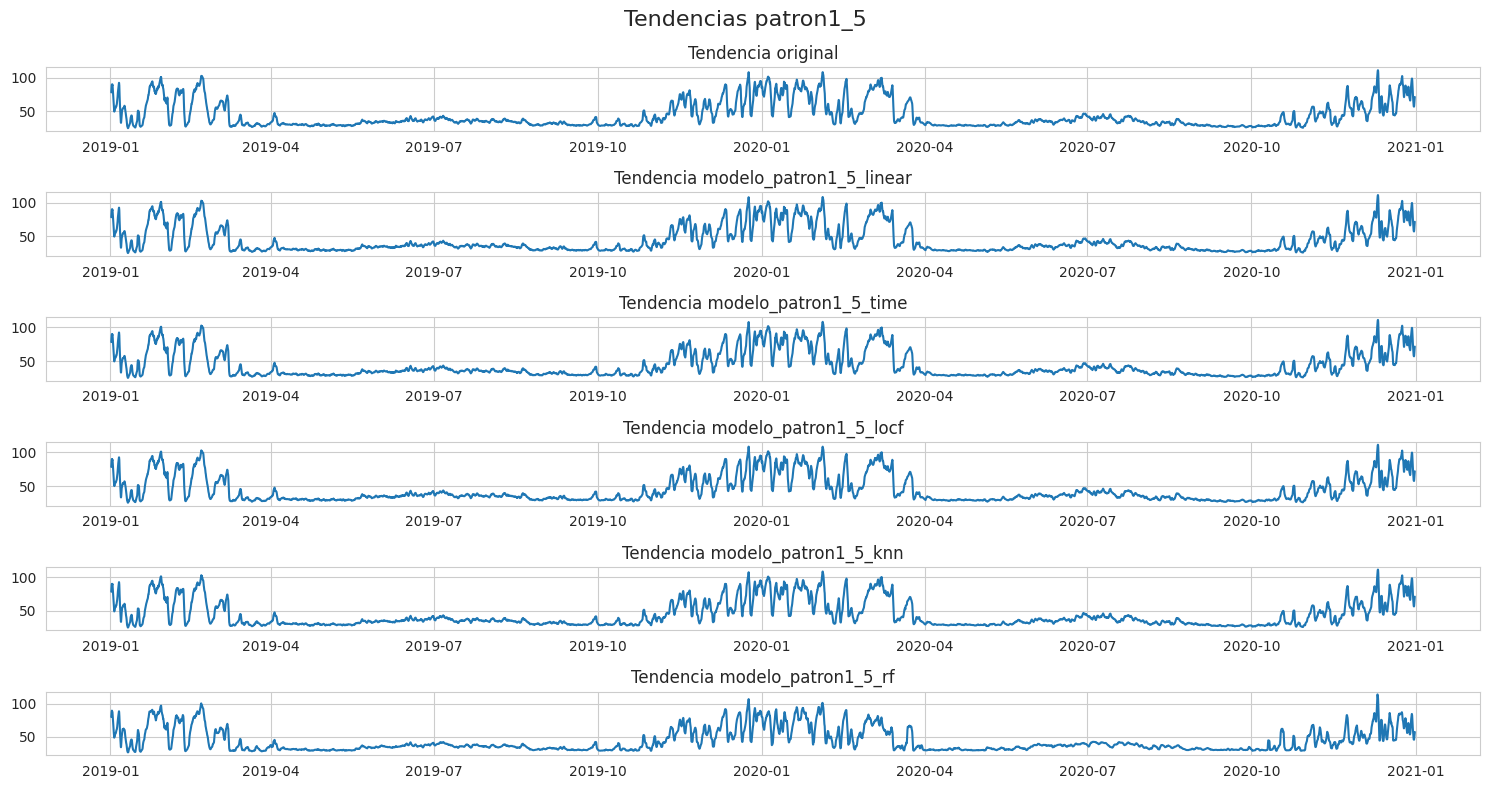

In [203]:
plt.figure(figsize=(15, 8))
plt.suptitle('Tendencias patron1_5', fontsize=16)

plt.subplot(611)
plt.plot(modelo_base.trend)
plt.title('Tendencia original')

plt.subplot(612)
plt.plot(modelo_patron1_5_linear.trend)
plt.title('Tendencia modelo_patron1_5_linear')

plt.subplot(613)
plt.plot(modelo_patron1_5_time.trend)
plt.title('Tendencia modelo_patron1_5_time')

plt.subplot(614)
plt.plot(modelo_patron1_5_locf.trend)
plt.title('Tendencia modelo_patron1_5_locf')

plt.subplot(615)
plt.plot(modelo_patron1_5_knn.trend)
plt.title('Tendencia modelo_patron1_5_knn')

plt.subplot(616)
plt.plot(modelo_patron1_5_rf.trend)
plt.title('Tendencia modelo_patron1_5_rf')

plt.tight_layout()
plt.show()


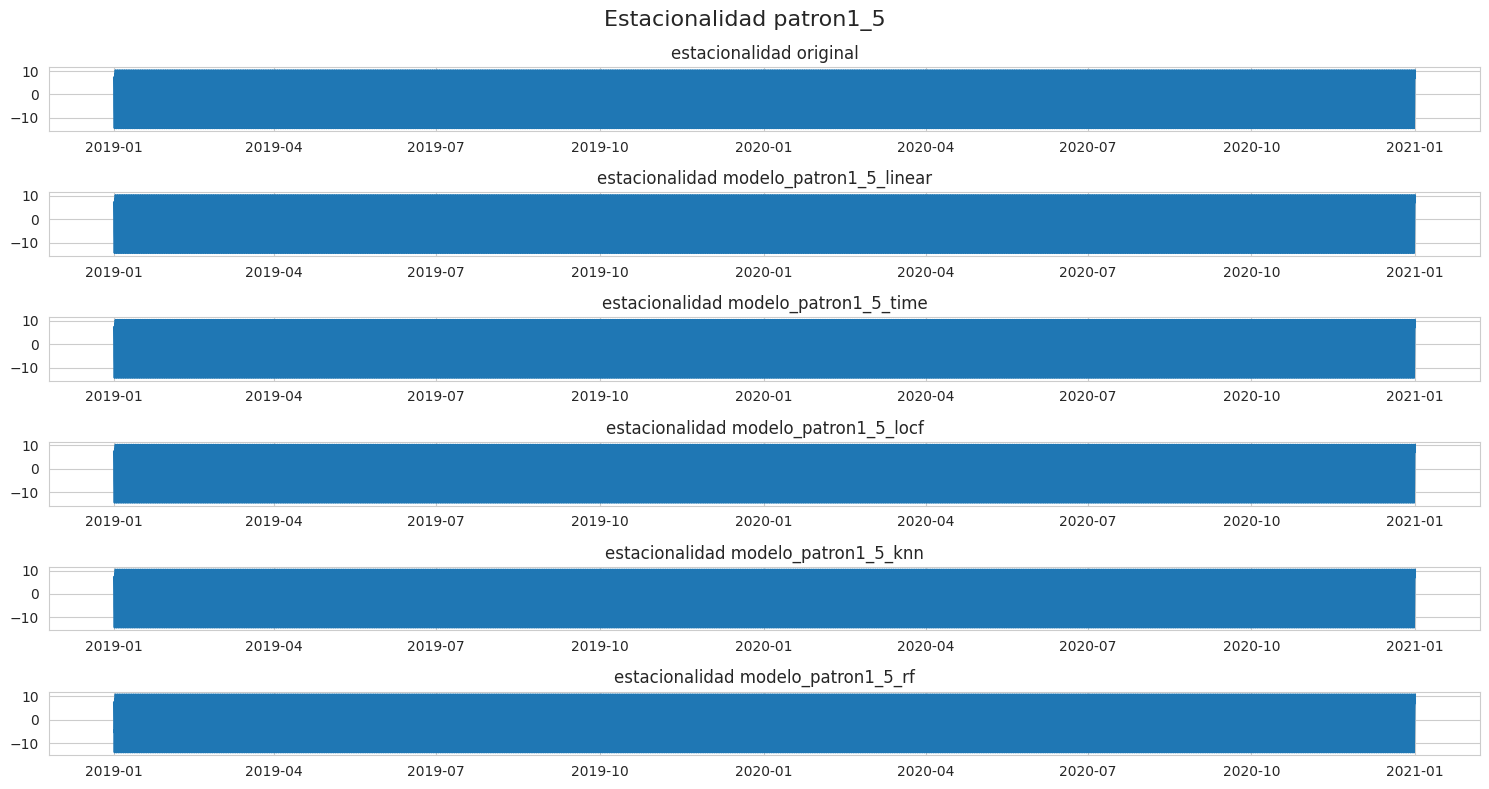

In [204]:
plt.figure(figsize=(15, 8))
plt.suptitle('Estacionalidad patron1_5', fontsize=16)

plt.subplot(611)
plt.plot(modelo_base.seasonal)
plt.title('estacionalidad original')

plt.subplot(612)
plt.plot(modelo_patron1_5_linear.seasonal)
plt.title('estacionalidad modelo_patron1_5_linear')

plt.subplot(613)
plt.plot(modelo_patron1_5_time.seasonal)
plt.title('estacionalidad modelo_patron1_5_time')

plt.subplot(614)
plt.plot(modelo_patron1_5_locf.seasonal)
plt.title('estacionalidad modelo_patron1_5_locf')

plt.subplot(615)
plt.plot(modelo_patron1_5_knn.seasonal)
plt.title('estacionalidad modelo_patron1_5_knn')

plt.subplot(616)
plt.plot(modelo_patron1_5_rf.seasonal)
plt.title('estacionalidad modelo_patron1_5_rf')

plt.tight_layout()
plt.show()

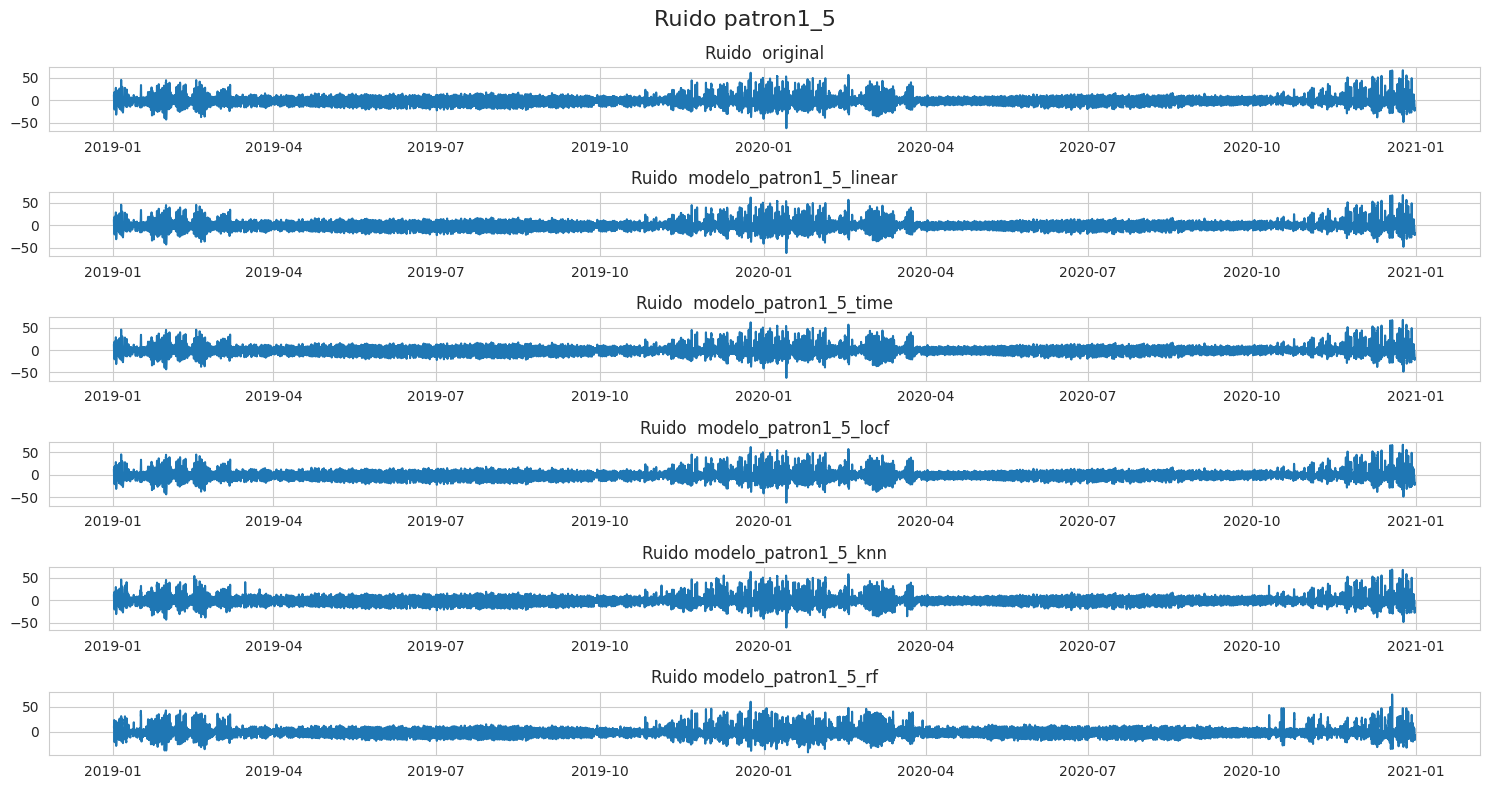

In [205]:
plt.figure(figsize=(15, 8))
plt.suptitle('Ruido patron1_5', fontsize=16)

plt.subplot(611)
plt.plot(modelo_base.resid)
plt.title('Ruido  original')

plt.subplot(612)
plt.plot(modelo_patron1_5_linear.resid)
plt.title('Ruido  modelo_patron1_5_linear')

plt.subplot(613)
plt.plot(modelo_patron1_5_time.resid)
plt.title('Ruido  modelo_patron1_5_time')

plt.subplot(614)
plt.plot(modelo_patron1_5_locf.resid)
plt.title('Ruido  modelo_patron1_5_locf')

plt.subplot(615)
plt.plot(modelo_patron1_5_knn.resid)
plt.title('Ruido modelo_patron1_5_knn')

plt.subplot(616)
plt.plot(modelo_patron1_5_rf.resid)
plt.title('Ruido modelo_patron1_5_rf')

plt.tight_layout()
plt.show()

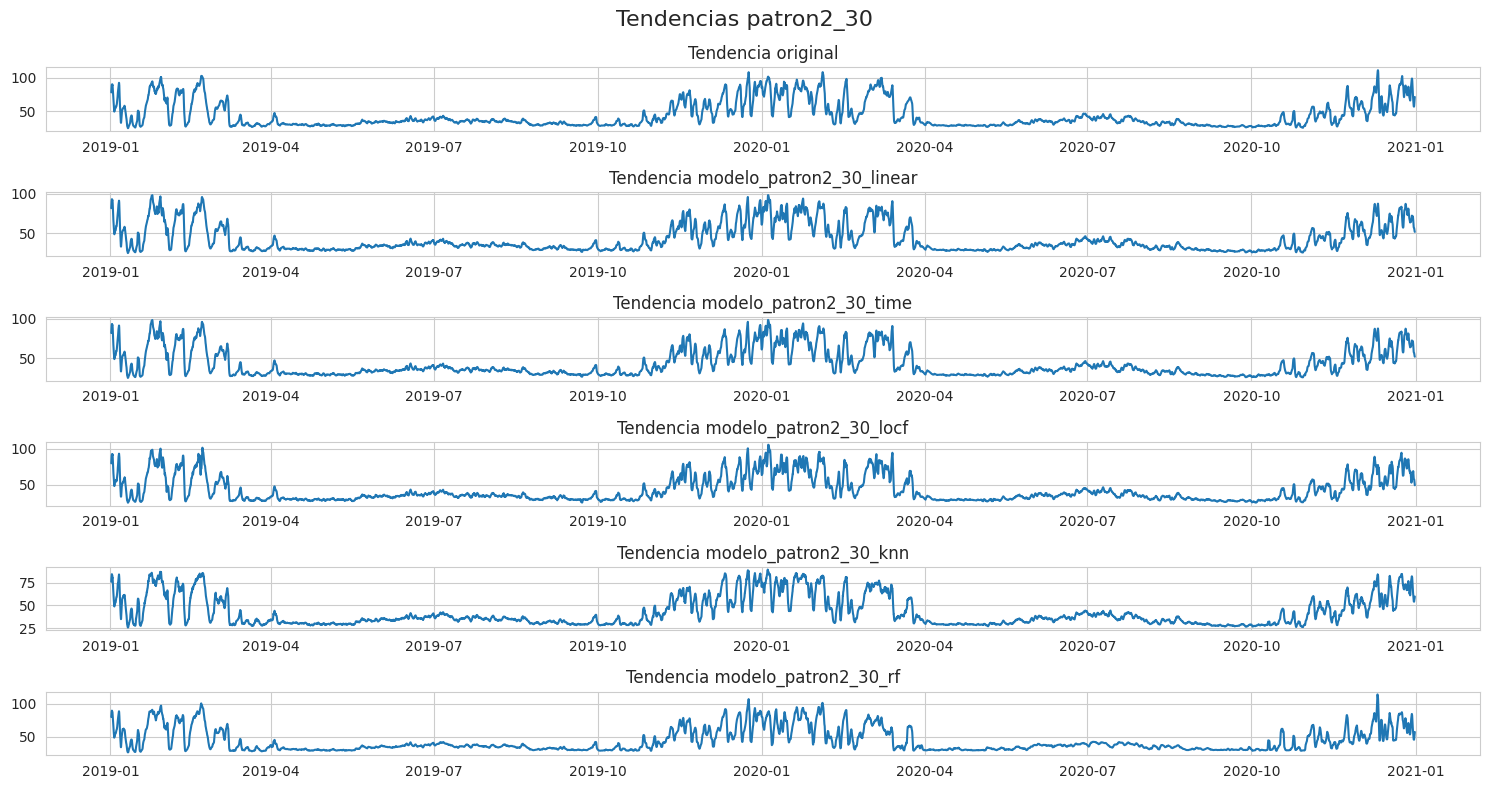

In [206]:
plt.figure(figsize=(15, 8))
plt.suptitle('Tendencias patron2_30', fontsize=16)

plt.subplot(611)
plt.plot(modelo_base.trend)
plt.title('Tendencia original')

plt.subplot(612)
plt.plot(modelo_patron2_30_linear.trend)
plt.title('Tendencia modelo_patron2_30_linear')

plt.subplot(613)
plt.plot(modelo_patron2_30_time.trend)
plt.title('Tendencia modelo_patron2_30_time')

plt.subplot(614)
plt.plot(modelo_patron2_30_locf.trend)
plt.title('Tendencia modelo_patron2_30_locf')

plt.subplot(615)
plt.plot(modelo_patron2_30_knn.trend)
plt.title('Tendencia modelo_patron2_30_knn')

plt.subplot(616)
plt.plot(modelo_patron2_30_rf.trend)
plt.title('Tendencia modelo_patron2_30_rf')

plt.tight_layout()
plt.show()


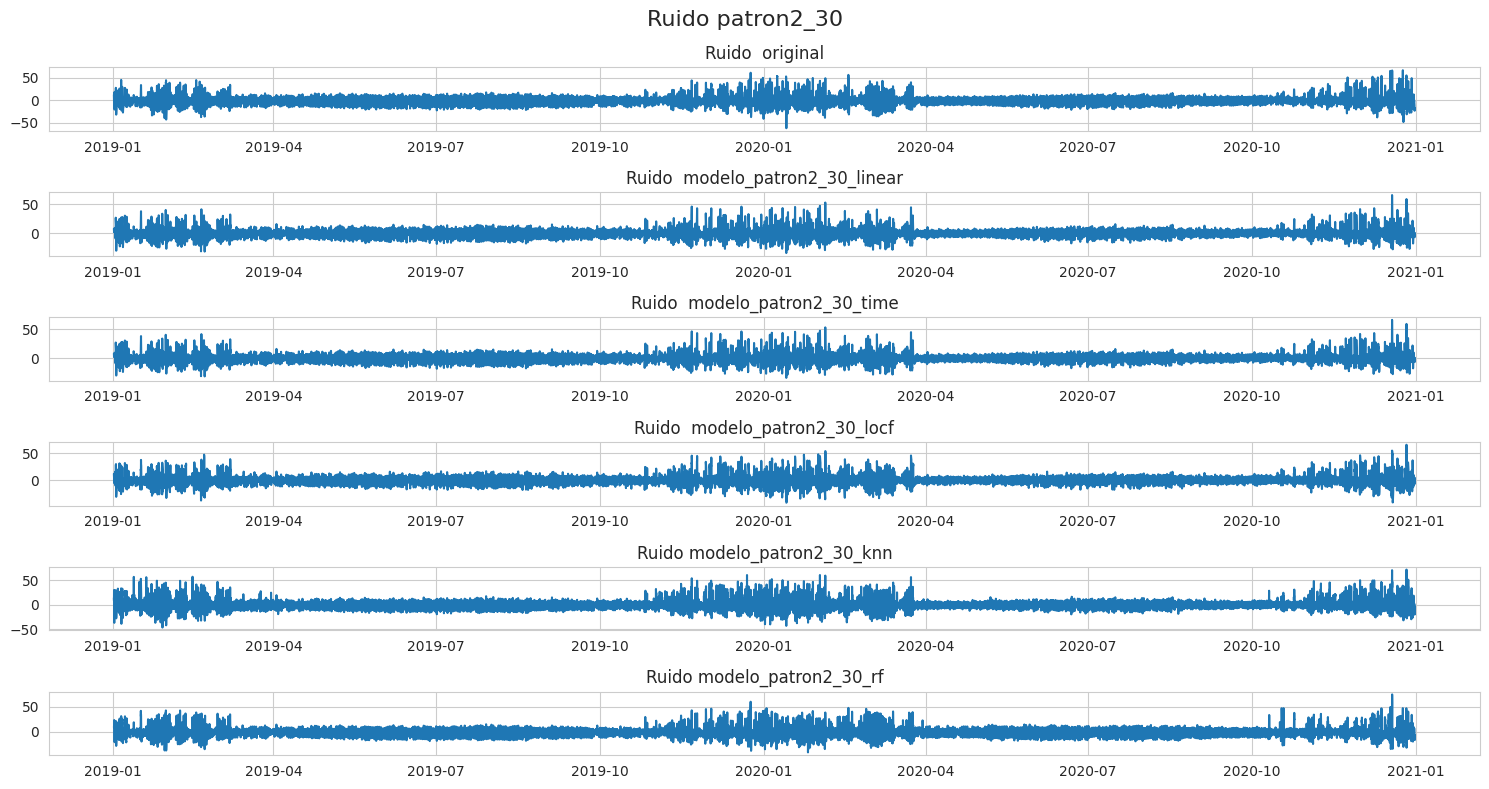

In [207]:
plt.figure(figsize=(15, 8))
plt.suptitle('Ruido patron2_30', fontsize=16)

plt.subplot(611)
plt.plot(modelo_base.resid)
plt.title('Ruido  original')

plt.subplot(612)
plt.plot(modelo_patron2_30_linear.resid)
plt.title('Ruido  modelo_patron2_30_linear')

plt.subplot(613)
plt.plot(modelo_patron2_30_time.resid)
plt.title('Ruido  modelo_patron2_30_time')

plt.subplot(614)
plt.plot(modelo_patron2_30_locf.resid)
plt.title('Ruido  modelo_patron2_30_locf')

plt.subplot(615)
plt.plot(modelo_patron2_30_knn.resid)
plt.title('Ruido modelo_patron2_30_knn')

plt.subplot(616)
plt.plot(modelo_patron2_30_rf.resid)
plt.title('Ruido modelo_patron2_30_rf')

plt.tight_layout()
plt.show()

In [208]:
modelo_base = seasonal_decompose(df_base['kW'], model='additive', period=24)

modelo_patron1_5_linear = seasonal_decompose(df_patron1_5_imputed_linear['kW'], model='additive', period=24)
modelo_patron1_5_time = seasonal_decompose(df_patron1_5_imputed_time['kW'], model='additive', period=24)
modelo_patron1_5_locf = seasonal_decompose(df_patron1_5_imputed_locf['kW'], model='additive', period=24)
modelo_patron1_5_knn = seasonal_decompose(df_patron1_5_imputed_knn['kW'], model='additive', period=24)
modelo_patron1_5_rf = seasonal_decompose(df_patron1_5_imputed_rf['kW_imputado'], model='additive', period=24)

modelo_patron2_30_linear = seasonal_decompose(df_patron2_30_imputed_linear['kW'], model='additive', period=24)
modelo_patron2_30_time = seasonal_decompose(df_patron2_30_imputed_time['kW'], model='additive', period=24)
modelo_patron2_30_locf = seasonal_decompose(df_patron2_30_imputed_locf['kW'], model='additive', period=24)
modelo_patron2_30_knn = seasonal_decompose(df_patron2_30_imputed_knn['kW'], model='additive', period=24)
modelo_patron2_30_rf = seasonal_decompose(df_patron2_30_imputed_rf['kW_imputado'], model='additive', period=24)